# Segmentation model using UNet architecture #

In [9]:
!nvidia-smi

Mon Feb 17 20:08:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/pet_seg


In [ ]:
from IPython import display
display.clear_output()


In [13]:
%cd /content/drive/MyDrive/pet_seg/

/content/drive/MyDrive/pet_seg


In [14]:
!pwd

/content/drive/MyDrive/pet_seg


In [8]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-02-17 19:25:42--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-02-17 19:25:42--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-02-17 19:25:43--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

## Importing Required Libraries

The following libraries are imported to facilitate image processing, data handling, model training, and evaluation

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import backend as K



## Defining Image Processing Parameters and Data Loading Function

- **H, W (256 x 256)**: Set the height and width for image resizing.
- **`process_data(data_path, file_path)`**:
  - Reads a CSV file containing image names.
  - Constructs full file paths for corresponding images and masks.
  - Returns lists of image and mask file paths.

In [ ]:
H = 256
W = 256

def process_data(data_path, file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    names = df[0].values

    images = [os.path.join(data_path, f"images/{name}.jpg") for name in names]
    masks = [os.path.join(data_path, f"annotations/trimaps/{name}.png") for name in names]

    return images, masks

## Data Loading and Splitting Function

- **`load_data(path)`**:
  - Reads training/validation and test file paths from the dataset directory.
  - Calls `process_data()` to retrieve image and mask paths.
  - Splits the dataset into:
    - **Training (80%)**
    - **Validation (20%)**
    - **Test (Separate test set)**
  - Uses `train_test_split` with a fixed random state for reproducibility.
  - Returns tuples for train, validation, and test data.


In [ ]:
def load_data(path):
    train_valid_path = os.path.join(path, "annotations/trainval.txt")
    test_path = os.path.join(path, "annotations/test.txt")

    # Load data paths for training, validation, and testing
    all_x, all_y = process_data(path, train_valid_path)
    test_x, test_y = process_data(path, test_path)

    # Split into train and validation (75% train, 15% validation)
    train_x, valid_x, train_y, valid_y = train_test_split(all_x, all_y, test_size=0.2, random_state=42)

    # Return train, validation, and test data paths
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

## Image Preprocessing Function

- **`read_image(x)`**:
  - Reads an image from the given file path using OpenCV (`cv2.imread`).
  - Resizes the image to `(256, 256)` to match the model input dimensions.
  - Normalizes pixel values to the range `[0, 1]` by dividing by 255.
  - Converts the image to `float32` for compatibility with deep learning models.
  - Returns the preprocessed image.


In [ ]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

## Mask Preprocessing Function

- **`read_mask(x)`**:
  - Reads a grayscale mask image from the given file path using OpenCV (`cv2.imread` with `IMREAD_GRAYSCALE`).
  - Resizes the mask to `(256, 256)` to match the model input dimensions.
  - Subtracts `1` from the mask values to adjust the class labels (assuming labels are in `{1,2,3}` and need to be `{0,1,2}`).
  - Converts the mask to `int32` for compatibility with the model.
  - Returns the processed mask.


In [ ]:
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x - 1
    x = x.astype(np.int32)
    return x

## Data Preprocessing Function

- **`preprocess(x, y)`**:
  - Converts file paths (`x`, `y`) from TensorFlow tensors to Python strings using `decode()`.
  - Uses `tf.numpy_function` to apply `read_image` and `read_mask` for loading and preprocessing images and masks.
  - Applies **one-hot encoding** to the mask (assuming 3 classes).
  - Ensures the final shapes of the image and mask are `(256, 256, 3)`.
  - Returns the preprocessed image and mask as TensorFlow tensors.


In [ ]:
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 3])

    return image, mask

## TensorFlow Dataset Function

- **`tf_dataset(x, y, batch=8)`**:
  - Creates a `tf.data.Dataset` from image (`x`) and mask (`y`) paths.
  - Shuffles the dataset with a buffer size of **5000**.
  - Applies the `preprocess` function to load and process the images and masks.
  - Batches the dataset into **mini-batches** of size `batch` (default: 8).
  - Repeats the dataset indefinitely for continuous training.
  - Uses **prefetching** to optimize performance by loading data while the model is training.


In [ ]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset


## Loading and Preparing the Dataset

- **`path`**: Directory containing the dataset (`/content/drive/MyDrive/pet_seg`).
- **`load_data(path)`**:
  - Loads image and mask file paths for training, validation, and testing.
  - Splits the dataset into **training (80%)** and **validation (20%)**.
- **Dataset Summary**:
  - Prints the number of images in training, validation, and test sets.
- **`tf_dataset(train_x, train_y, batch=8)`**:
  - Converts training images and masks into a TensorFlow dataset.
  - Prepares data for model training with batching and optimization.


In [ ]:
path = "/content/drive/MyDrive/pet_seg"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")
dataset = tf_dataset(train_x, train_y, batch=8)

Dataset: Train: 2944 - Valid: 736 - Test: 3669


## Convolutional Block

- Defines a **convolutional block** used in the model.
- Consists of two **Conv2D** layers with **batch normalization** and **ReLU activation**.
- Optionally includes **max pooling** to reduce spatial dimensions.
- Returns:
  - Both **convolutional output** and **pooled output** if pooling is enabled.
  - Only the **convolutional output** if pooling is disabled.


In [ ]:
def conv_block(inputs, filters, pool=True):
    """
    Creates a convolution block with batch normalization and ReLU activation
    
    Args:
        inputs: Input tensor
        filters (int): Number of filters
        pool (bool): Whether to include max pooling
    
    Returns:
        tuple: (conv_output, pooling_output) if pool=True, else conv_output
    """

    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


## U-Net Model Architecture

- Implements a **U-Net** model for image segmentation.
- Consists of three main parts:

  1. **Encoder**: 
     - Series of **convolutional blocks** with **max pooling** to extract features.
  
  2. **Bridge**:
     - A **bottleneck layer** that connects encoder and decoder.

  3. **Decoder**:
     - **UpSampling** followed by **concatenation** with encoder features for precise segmentation.

- The final **output layer** uses a **softmax activation** for multi-class segmentation.


In [ ]:
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)


In [ ]:
model = build_unet((256, 256, 3), 10)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 256, 256, 16)   │             64 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 256, 256, 16)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ activation_36[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 256, 256, 16)   │             64 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 256, 256, 16)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 16)   │              0 │ activation_37[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 128, 128, 32)   │            128 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ activation_38[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 128, 128, 32)   │            128 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9      

 Total params: 599,514 (2.29 MB)

 Trainable params: 597,722 (2.28 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Model Training Pipeline

- **Seeding**: Ensures reproducibility by setting fixed random seeds.

- **Dataset Preparation**:
  - Loads training, validation, and test sets.
  - Prints dataset statistics.

- **Hyperparameters**:
  - Input shape: **256x256x3**
  - Number of classes: **3**
  - Learning rate: **1e-4**
  - Batch size: **8**
  - Training epochs: **10**

- **Model Compilation**:
  - Uses **Adam optimizer** with **categorical cross-entropy loss**.
  
- **Data Pipeline**:
  - Converts datasets into TensorFlow datasets.
  - Configures batch processing.

- **Callbacks**:
  - **ModelCheckpoint**: Saves the best model during training.
  - **ReduceLROnPlateau**: Reduces learning rate when validation loss plateaus.
  - **EarlyStopping**: Stops training when validation loss doesn't improve.

- **Training Process**:
  - Trains the U-Net model on **train dataset**.
  - Evaluates on **validation dataset** after each epoch.


  ### Model Evaluation 
  - **Custom Metrics:**
  - **IoU Metric:** Measures intersection over union for segmentation accuracy.
  - **Dice Coefficient:** Evaluates overlap between predicted and ground truth masks.
  - **Pixel Accuracy:** Computes the proportion of correctly classified pixels.


Dataset: Train: 2944 - Valid: 736 - Test: 3669
Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - dice_metric: 0.4016 - iou_metric: 0.2539 - loss: 1.0935 - pixel_accuracy: 0.4875
Epoch 1: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 171s 244ms/step - dice_metric: 0.4018 - iou_metric: 0.2541 - loss: 1.0930 - pixel_accuracy: 0.4879 - val_dice_metric: 0.5104 - val_iou_metric: 0.3428 - val_loss: 0.8299 - val_pixel_accuracy: 0.6905 - learning_rate: 1.0000e-04
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - dice_metric: 0.5613 - iou_metric: 0.3904 - loss: 0.7159 - pixel_accuracy: 0.7476
Epoch 2: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 77s 209ms/step - dice_metric: 0.5613 - iou_metric: 0.3905 - loss: 0.7159 - pixel_accuracy: 0.7476 - val_dice_metric: 0.6260 - val_iou_metric: 0.4562 - val_loss: 0.6200 - val_pixel_accuracy: 0.7764 - learning_rate: 1.0000e-04
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - dice_metric: 0.6209 - iou_metric: 0.4506 - loss: 0.6191 - pixel_accuracy: 0.7781
Epoch 3: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 86s 233ms/step - dice_metric: 0.6210 - iou_metric: 0.4506 - loss: 0.6190 - pixel_accuracy: 0.7781 - val_dice_metric: 0.6570 - val_iou_metric: 0.4899 - val_loss: 0.5922 - val_pixel_accuracy: 0.7864 - learning_rate: 1.0000e-04
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - dice_metric: 0.6688 - iou_metric: 0.5028 - loss: 0.5460 - pixel_accuracy: 0.8045
Epoch 4: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 142s 387ms/step - dice_metric: 0.6688 - iou_metric: 0.5028 - loss: 0.5459 - pixel_accuracy: 0.8045 - val_dice_metric: 0.6892 - val_iou_metric: 0.5265 - val_loss: 0.5361 - val_pixel_accuracy: 0.8022 - learning_rate: 1.0000e-04
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - dice_metric: 0.7017 - iou_metric: 0.5409 - loss: 0.4987 - pixel_accuracy: 0.8173
Epoch 5: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 141s 385ms/step - dice_metric: 0.7017 - iou_metric: 0.5409 - loss: 0.4986 - pixel_accuracy: 0.8173 - val_dice_metric: 0.7259 - val_iou_metric: 0.5704 - val_loss: 0.4696 - val_pixel_accuracy: 0.8260 - learning_rate: 1.0000e-04
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_metric: 0.7240 - iou_metric: 0.5679 - loss: 0.4669 - pixel_accuracy: 0.8259
Epoch 6: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 82s 224ms/step - dice_metric: 0.7240 - iou_metric: 0.5679 - loss: 0.4668 - pixel_accuracy: 0.8259 - val_dice_metric: 0.7436 - val_iou_metric: 0.5929 - val_loss: 0.4607 - val_pixel_accuracy: 0.8248 - learning_rate: 1.0000e-04
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - dice_metric: 0.7466 - iou_metric: 0.5961 - loss: 0.4322 - pixel_accuracy: 0.8374
Epoch 7: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 140s 381ms/step - dice_metric: 0.7466 - iou_metric: 0.5961 - loss: 0.4322 - pixel_accuracy: 0.8374 - val_dice_metric: 0.7634 - val_iou_metric: 0.6184 - val_loss: 0.4284 - val_pixel_accuracy: 0.8378 - learning_rate: 1.0000e-04
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - dice_metric: 0.7577 - iou_metric: 0.6104 - loss: 0.4180 - pixel_accuracy: 0.8406
Epoch 8: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 143s 389ms/step - dice_metric: 0.7578 - iou_metric: 0.6105 - loss: 0.4180 - pixel_accuracy: 0.8406 - val_dice_metric: 0.7583 - val_iou_metric: 0.6114 - val_loss: 0.4106 - val_pixel_accuracy: 0.8436 - learning_rate: 1.0000e-04
Epoch 9/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - dice_metric: 0.7738 - iou_metric: 0.6315 - loss: 0.3942 - pixel_accuracy: 0.8490
Epoch 9: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 85s 230ms/step - dice_metric: 0.7738 - iou_metric: 0.6315 - loss: 0.3942 - pixel_accuracy: 0.8490 - val_dice_metric: 0.7819 - val_iou_metric: 0.6429 - val_loss: 0.4164 - val_pixel_accuracy: 0.8435 - learning_rate: 1.0000e-04
Epoch 10/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - dice_metric: 0.7840 - iou_metric: 0.6452 - loss: 0.3771 - pixel_accuracy: 0.8549
Epoch 10: saving model to model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 140s 381ms/step - dice_metric: 0.7840 - iou_metric: 0.6452 - loss: 0.3771 - pixel_accuracy: 0.8549 - val_dice_metric: 0.7752 - val_iou_metric: 0.6339 - val_loss: 0.4004 - val_pixel_accuracy: 0.8475 - learning_rate: 1.0000e-04
458/458 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - dice_metric: 0.7777 - iou_metric: 0.6369 - loss: 0.3987 - pixel_accuracy: 0.8476
Test metrics: [0.4021851122379303, 0.8469030857086182, 0.6355896592140198, 0.7766538262367249]


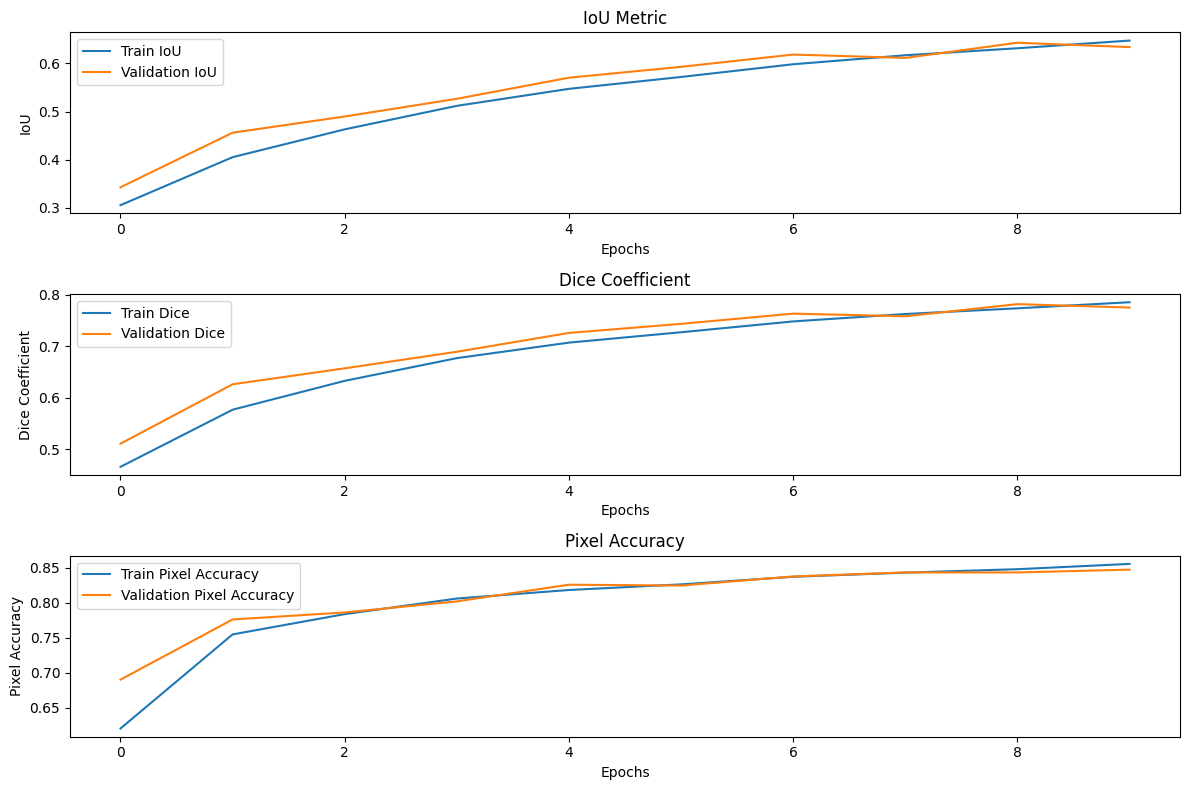

In [ ]:
# Custom metric for IoU
def iou_metric(y_true, y_pred):
    # Flatten the arrays
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Ensure y_true is float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))  # Ensure y_pred is float32

    # Calculate intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return intersection / (union + K.epsilon())  # Avoid division by zero

# Custom metric for Dice coefficient
def dice_metric(y_true, y_pred):
    # Flatten the arrays
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Ensure y_true is float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))  # Ensure y_pred is float32

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Custom metric for pixel accuracy
def pixel_accuracy(y_true, y_pred):
    correct_pixels = K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1))
    return K.mean(K.cast(correct_pixels, K.floatx()))

np.random.seed(42)
tf.random.set_seed(42)

""" Dataset """
path = "/content/drive/MyDrive/pet_seg"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

""" Hyperparameters """
shape = (256, 256, 3)
num_classes = 3
lr = 1e-4
batch_size = 8
epochs = 10

""" Model """
model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr),
                metrics=[pixel_accuracy, iou_metric, dice_metric])

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x) // batch_size
valid_steps = len(valid_x) // batch_size

callbacks = [
        ModelCheckpoint("model.h5", verbose=1),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]

# Track metrics
history = model.fit(train_dataset,
            steps_per_epoch=train_steps,
            validation_data=valid_dataset,
            validation_steps=valid_steps,
            epochs=epochs,
            callbacks=callbacks)

# Evaluate model on the test dataset
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)
test_metrics = model.evaluate(test_dataset, steps=len(test_x) // batch_size)
print(f"Test metrics: {test_metrics}")

# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plot the IoU metric
plt.subplot(3, 1, 1)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('IoU Metric')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Plot the Dice coefficient
plt.subplot(3, 1, 2)
plt.plot(history.history['dice_metric'], label='Train Dice')
plt.plot(history.history['val_dice_metric'], label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot the Pixel accuracy
plt.subplot(3, 1, 3)
plt.plot(history.history['pixel_accuracy'], label='Train Pixel Accuracy')
plt.plot(history.history['val_pixel_accuracy'], label='Validation Pixel Accuracy')
plt.title('Pixel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Pixel Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
H = 256
W = 256
num_classes = 3 #mask - boarder - background

### Model Inference and Mask Saving

- **Loads pre-trained model** to predict segmentation masks.
- **Processes test images** by resizing and normalizing.
- **Generates predictions**, applies class-based scaling, and formats output.
- **Saves results** by concatenating original images, ground truth masks, and predicted masks.


In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Dataset """
path = "/content/drive/MyDrive/pet_seg"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

""" Model """
model = tf.keras.models.load_model("model.h5")

""" Specify the output folder path """
output_folder = "/content/drive/MyDrive/pet_seg/results"  # Modify this path
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

""" Saving the masks """
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
      name = x.split("/")[-1]

      ## Read image
      x = cv2.imread(x, cv2.IMREAD_COLOR)
      x = cv2.resize(x, (W, H))
      x = x / 255.0
      x = x.astype(np.float32)

      ## Read mask
      y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
      y = cv2.resize(y, (W, H))   ## (256, 256)
      y = y - 1
      y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
      y = y * (255/num_classes)
      y = y.astype(np.int32)
      y = np.concatenate([y, y, y], axis=2)

      ## Prediction
      p = model.predict(np.expand_dims(x, axis=0))[0]
      p = np.argmax(p, axis=-1)
      p = np.expand_dims(p, axis=-1)
      p = p * (255/num_classes)
      p = p.astype(np.int32)
      p = np.concatenate([p, p, p], axis=2)

      x = x * 255.0
      x = x.astype(np.int32)

      h, w, _ = x.shape
      line = np.ones((h, 10, 3)) * 255

      # print(x.shape, line.shape, y.shape, line.shape, p.shape)

      # Concatenate the image, ground truth mask, and predicted mask
      final_image = np.concatenate([x, line, y, line, p], axis=1)

      # Save the final image in the specified output folder
      output_path = os.path.join(output_folder, name)
      cv2.imwrite(output_path, final_image)

print(f"Results saved in: {output_folder}")

Dataset: Train: 2944 - Valid: 736 - Test: 3669


  0%|          | 0/3669 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 1/3669 [00:02<2:42:22,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 2/3669 [00:02<1:12:48,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 3/3669 [00:02<43:17,  1.41it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 4/3669 [00:03<28:44,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 5/3669 [00:03<21:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 6/3669 [00:03<16:17,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 7/3669 [00:03<13:14,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 8/3669 [00:03<11:35,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 9/3669 [00:03<10:37,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 10/3669 [00:03<10:08,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 11/3669 [00:03<08:57,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 12/3669 [00:04<08:06,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 13/3669 [00:04<07:31,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 14/3669 [00:04<07:17,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 15/3669 [00:04<07:14,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 16/3669 [00:04<07:41,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 17/3669 [00:04<07:40,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 18/3669 [00:04<07:48,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 19/3669 [00:04<07:22,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 20/3669 [00:05<07:34,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 21/3669 [00:05<07:08,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 22/3669 [00:05<06:51,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 23/3669 [00:05<06:39,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 24/3669 [00:05<06:49,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 25/3669 [00:05<06:52,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 26/3669 [00:05<07:14,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 27/3669 [00:05<06:59,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 28/3669 [00:05<07:20,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|          | 29/3669 [00:06<07:37,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 30/3669 [00:06<08:13,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 31/3669 [00:06<07:55,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 32/3669 [00:06<07:59,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 33/3669 [00:06<07:59,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 34/3669 [00:06<08:23,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 35/3669 [00:06<07:42,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 36/3669 [00:06<07:19,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 37/3669 [00:07<07:12,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 38/3669 [00:07<06:55,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  1%|          | 39/3669 [00:07<08:01,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 40/3669 [00:07<07:40,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 41/3669 [00:07<07:34,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 42/3669 [00:07<07:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 43/3669 [00:07<06:49,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|          | 44/3669 [00:07<06:44,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 45/3669 [00:08<06:32,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 46/3669 [00:08<06:25,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 47/3669 [00:08<06:40,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  1%|▏         | 48/3669 [00:08<07:19,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▏         | 49/3669 [00:08<07:15,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 50/3669 [00:08<06:58,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|▏         | 51/3669 [00:08<06:43,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 52/3669 [00:08<06:33,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▏         | 53/3669 [00:08<06:31,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 54/3669 [00:09<06:48,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|▏         | 55/3669 [00:09<06:39,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 56/3669 [00:09<07:03,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 57/3669 [00:09<07:40,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 58/3669 [00:09<07:29,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 59/3669 [00:09<07:05,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 60/3669 [00:09<06:46,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 61/3669 [00:09<07:06,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 62/3669 [00:09<07:11,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 64/3669 [00:10<07:00,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▏         | 65/3669 [00:10<07:22,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 66/3669 [00:10<07:43,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 67/3669 [00:10<07:25,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 68/3669 [00:10<07:04,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 69/3669 [00:10<07:40,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 70/3669 [00:10<07:17,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 72/3669 [00:11<07:04,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 73/3669 [00:11<06:48,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|▏         | 74/3669 [00:11<07:04,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 75/3669 [00:11<07:17,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 76/3669 [00:11<07:11,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 77/3669 [00:11<07:01,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 78/3669 [00:11<07:32,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  2%|▏         | 79/3669 [00:12<08:20,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  2%|▏         | 80/3669 [00:12<08:43,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  2%|▏         | 81/3669 [00:12<09:13,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  2%|▏         | 82/3669 [00:12<08:57,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  2%|▏         | 83/3669 [00:12<09:32,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|▏         | 84/3669 [00:12<09:19,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 85/3669 [00:13<09:29,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  2%|▏         | 86/3669 [00:13<09:07,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  2%|▏         | 87/3669 [00:13<09:10,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  2%|▏         | 88/3669 [00:13<09:23,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  2%|▏         | 89/3669 [00:13<09:07,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|▏         | 90/3669 [00:13<09:12,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  2%|▏         | 91/3669 [00:14<09:20,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  3%|▎         | 92/3669 [00:14<08:57,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  3%|▎         | 93/3669 [00:14<09:32,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|▎         | 94/3669 [00:14<09:51,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  3%|▎         | 95/3669 [00:14<10:04,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  3%|▎         | 96/3669 [00:14<10:01,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  3%|▎         | 97/3669 [00:15<10:01,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 98/3669 [00:15<09:19,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 99/3669 [00:15<08:59,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 100/3669 [00:15<08:24,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 101/3669 [00:15<08:11,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 102/3669 [00:15<07:45,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 103/3669 [00:15<07:52,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 104/3669 [00:15<07:58,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 105/3669 [00:16<07:57,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 106/3669 [00:16<07:24,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 107/3669 [00:16<07:35,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 108/3669 [00:16<07:51,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 109/3669 [00:16<08:21,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 110/3669 [00:16<07:44,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 111/3669 [00:16<07:46,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 112/3669 [00:16<07:47,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 113/3669 [00:17<07:54,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 114/3669 [00:17<08:00,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 115/3669 [00:17<08:03,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 116/3669 [00:17<08:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 117/3669 [00:17<08:04,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 118/3669 [00:17<08:29,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 119/3669 [00:17<07:49,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 120/3669 [00:18<07:52,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 121/3669 [00:18<07:20,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 122/3669 [00:18<06:57,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 123/3669 [00:18<07:44,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 124/3669 [00:18<07:48,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 125/3669 [00:18<08:07,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 126/3669 [00:18<08:10,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 127/3669 [00:18<07:37,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 128/3669 [00:19<07:46,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 129/3669 [00:19<07:19,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 130/3669 [00:19<07:49,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 131/3669 [00:19<08:02,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▎         | 132/3669 [00:19<08:07,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 133/3669 [00:19<07:35,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 134/3669 [00:19<07:42,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▎         | 135/3669 [00:20<08:16,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 136/3669 [00:20<07:35,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▎         | 137/3669 [00:20<07:41,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  4%|▍         | 138/3669 [00:20<08:02,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 139/3669 [00:20<08:08,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  4%|▍         | 140/3669 [00:20<07:44,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 141/3669 [00:20<07:49,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 142/3669 [00:20<07:42,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 143/3669 [00:21<07:49,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 144/3669 [00:21<07:44,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 145/3669 [00:21<07:53,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 146/3669 [00:21<07:29,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 147/3669 [00:21<07:35,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 148/3669 [00:21<07:16,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 149/3669 [00:21<07:02,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 150/3669 [00:21<07:21,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 151/3669 [00:22<07:49,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 152/3669 [00:22<07:51,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  4%|▍         | 153/3669 [00:22<07:57,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 154/3669 [00:22<08:08,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 155/3669 [00:22<08:08,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 156/3669 [00:22<08:19,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 157/3669 [00:22<07:43,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 158/3669 [00:23<07:34,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 159/3669 [00:23<07:09,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 160/3669 [00:23<06:49,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  4%|▍         | 161/3669 [00:23<06:59,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 162/3669 [00:23<06:59,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 163/3669 [00:23<07:15,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▍         | 164/3669 [00:23<07:14,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▍         | 165/3669 [00:23<07:49,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 166/3669 [00:24<07:56,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 167/3669 [00:24<07:21,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▍         | 168/3669 [00:24<07:02,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▍         | 169/3669 [00:24<07:27,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 170/3669 [00:24<07:35,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 171/3669 [00:24<07:10,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▍         | 172/3669 [00:24<07:25,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▍         | 173/3669 [00:24<08:19,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  5%|▍         | 174/3669 [00:25<08:57,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  5%|▍         | 175/3669 [00:25<09:08,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  5%|▍         | 176/3669 [00:25<09:49,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  5%|▍         | 177/3669 [00:25<09:23,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  5%|▍         | 178/3669 [00:25<09:43,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  5%|▍         | 179/3669 [00:26<09:58,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  5%|▍         | 180/3669 [00:26<09:31,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  5%|▍         | 181/3669 [00:26<09:42,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  5%|▍         | 182/3669 [00:26<09:41,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  5%|▍         | 183/3669 [00:26<09:21,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 184/3669 [00:26<08:57,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  5%|▌         | 185/3669 [00:27<09:33,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  5%|▌         | 186/3669 [00:27<09:42,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  5%|▌         | 187/3669 [00:27<09:58,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  5%|▌         | 188/3669 [00:27<09:42,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  5%|▌         | 189/3669 [00:27<09:27,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  5%|▌         | 190/3669 [00:27<09:38,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  5%|▌         | 191/3669 [00:28<09:36,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  5%|▌         | 192/3669 [00:28<09:36,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▌         | 193/3669 [00:28<09:34,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 194/3669 [00:28<09:05,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▌         | 195/3669 [00:28<08:49,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 196/3669 [00:28<08:00,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 197/3669 [00:28<08:02,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 198/3669 [00:28<07:32,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▌         | 199/3669 [00:29<07:45,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 200/3669 [00:29<07:14,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 201/3669 [00:29<07:43,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 202/3669 [00:29<07:43,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 203/3669 [00:29<07:09,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 204/3669 [00:29<06:49,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 205/3669 [00:29<06:40,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 206/3669 [00:29<06:27,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 207/3669 [00:30<06:47,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 208/3669 [00:30<07:32,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 209/3669 [00:30<07:14,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|▌         | 210/3669 [00:30<07:41,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 211/3669 [00:30<07:40,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 212/3669 [00:30<07:44,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 213/3669 [00:30<07:24,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 214/3669 [00:31<07:31,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 215/3669 [00:31<07:34,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 216/3669 [00:31<07:40,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 217/3669 [00:31<07:29,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  6%|▌         | 218/3669 [00:31<07:58,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 219/3669 [00:31<07:27,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 220/3669 [00:31<07:05,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▌         | 221/3669 [00:31<06:55,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 222/3669 [00:32<07:05,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 223/3669 [00:32<06:59,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 224/3669 [00:32<06:57,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|▌         | 225/3669 [00:32<07:17,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 226/3669 [00:32<07:13,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 227/3669 [00:32<07:23,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 228/3669 [00:32<07:36,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 229/3669 [00:32<08:17,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 230/3669 [00:33<07:46,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▋         | 231/3669 [00:33<07:29,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 232/3669 [00:33<07:06,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▋         | 233/3669 [00:33<07:32,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▋         | 234/3669 [00:33<07:15,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▋         | 235/3669 [00:33<07:00,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▋         | 236/3669 [00:33<07:34,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▋         | 237/3669 [00:33<07:40,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▋         | 238/3669 [00:34<07:45,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 239/3669 [00:34<07:37,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 240/3669 [00:34<07:40,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 241/3669 [00:34<07:34,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 242/3669 [00:34<07:39,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 243/3669 [00:34<08:08,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 244/3669 [00:34<07:32,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 245/3669 [00:35<07:37,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|▋         | 246/3669 [00:35<07:30,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 247/3669 [00:35<07:40,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 248/3669 [00:35<08:00,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 249/3669 [00:35<07:31,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 250/3669 [00:35<07:39,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 251/3669 [00:35<07:51,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 252/3669 [00:36<09:16,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|▋         | 253/3669 [00:36<08:27,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 254/3669 [00:36<07:48,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|▋         | 255/3669 [00:36<08:33,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 256/3669 [00:36<08:28,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 257/3669 [00:36<07:42,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 258/3669 [00:36<07:54,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|▋         | 259/3669 [00:37<07:41,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 260/3669 [00:37<07:47,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 261/3669 [00:37<07:56,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|▋         | 262/3669 [00:37<08:31,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 263/3669 [00:37<08:19,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 264/3669 [00:37<07:48,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 265/3669 [00:37<07:46,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 266/3669 [00:38<07:49,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 267/3669 [00:38<07:31,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|▋         | 268/3669 [00:38<07:50,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  7%|▋         | 269/3669 [00:38<08:40,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  7%|▋         | 270/3669 [00:38<09:02,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|▋         | 271/3669 [00:38<08:38,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|▋         | 272/3669 [00:38<08:45,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  7%|▋         | 273/3669 [00:39<08:53,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|▋         | 274/3669 [00:39<08:25,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


  7%|▋         | 275/3669 [00:39<08:49,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|▊         | 276/3669 [00:39<09:49,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  8%|▊         | 277/3669 [00:39<09:39,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|▊         | 278/3669 [00:39<09:08,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  8%|▊         | 279/3669 [00:40<08:59,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  8%|▊         | 280/3669 [00:40<09:02,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  8%|▊         | 281/3669 [00:40<10:52,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  8%|▊         | 282/3669 [00:40<10:06,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  8%|▊         | 283/3669 [00:40<09:50,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  8%|▊         | 284/3669 [00:41<10:08,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  8%|▊         | 285/3669 [00:41<09:49,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  8%|▊         | 286/3669 [00:41<09:46,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  8%|▊         | 287/3669 [00:41<10:07,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 288/3669 [00:41<09:23,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 289/3669 [00:41<08:51,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 290/3669 [00:41<08:33,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 291/3669 [00:42<08:35,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 292/3669 [00:42<08:31,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  8%|▊         | 293/3669 [00:42<08:25,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 294/3669 [00:42<08:26,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 295/3669 [00:42<08:17,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 296/3669 [00:42<08:13,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 297/3669 [00:42<07:55,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 298/3669 [00:43<07:26,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 299/3669 [00:43<07:01,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 300/3669 [00:43<06:43,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 301/3669 [00:43<07:06,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|▊         | 302/3669 [00:43<07:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 303/3669 [00:43<06:54,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 304/3669 [00:43<06:36,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 305/3669 [00:43<07:18,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 306/3669 [00:44<07:06,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 307/3669 [00:44<06:50,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 308/3669 [00:44<07:08,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|▊         | 309/3669 [00:44<07:36,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  8%|▊         | 310/3669 [00:44<07:54,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 311/3669 [00:44<07:56,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▊         | 312/3669 [00:44<07:47,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▊         | 313/3669 [00:45<07:20,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▊         | 314/3669 [00:45<07:28,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 315/3669 [00:45<07:29,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▊         | 316/3669 [00:45<07:39,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▊         | 317/3669 [00:45<07:11,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▊         | 318/3669 [00:45<07:04,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▊         | 319/3669 [00:45<07:08,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▊         | 320/3669 [00:45<06:50,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▊         | 321/3669 [00:46<07:06,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▉         | 322/3669 [00:46<07:24,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 323/3669 [00:46<07:33,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▉         | 324/3669 [00:46<07:27,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|▉         | 325/3669 [00:46<07:34,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 326/3669 [00:46<07:39,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 327/3669 [00:46<07:21,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 328/3669 [00:47<07:23,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▉         | 329/3669 [00:47<07:06,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 330/3669 [00:47<07:20,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  9%|▉         | 331/3669 [00:47<07:38,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 332/3669 [00:47<07:57,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 333/3669 [00:47<07:40,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 334/3669 [00:47<07:40,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 335/3669 [00:47<07:14,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 336/3669 [00:48<07:26,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▉         | 337/3669 [00:48<07:34,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 338/3669 [00:48<07:45,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 339/3669 [00:48<08:05,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 340/3669 [00:48<07:54,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 341/3669 [00:48<07:49,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 342/3669 [00:48<07:28,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 343/3669 [00:49<07:03,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▉         | 344/3669 [00:49<07:26,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▉         | 345/3669 [00:49<07:31,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 346/3669 [00:49<08:03,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 347/3669 [00:49<07:54,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 348/3669 [00:49<08:12,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 349/3669 [00:49<07:34,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|▉         | 350/3669 [00:50<07:04,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|▉         | 351/3669 [00:50<06:42,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|▉         | 352/3669 [00:50<07:17,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|▉         | 353/3669 [00:50<07:25,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 354/3669 [00:50<07:11,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 355/3669 [00:50<07:19,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|▉         | 356/3669 [00:50<07:08,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|▉         | 357/3669 [00:50<06:49,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 10%|▉         | 358/3669 [00:51<06:45,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|▉         | 359/3669 [00:51<07:03,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 360/3669 [00:51<07:03,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 361/3669 [00:51<07:37,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|▉         | 362/3669 [00:51<07:30,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|▉         | 363/3669 [00:51<08:00,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|▉         | 364/3669 [00:51<08:17,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|▉         | 365/3669 [00:52<08:02,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|▉         | 366/3669 [00:52<08:01,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 10%|█         | 367/3669 [00:52<08:16,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 10%|█         | 368/3669 [00:52<08:54,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|█         | 369/3669 [00:52<08:54,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|█         | 370/3669 [00:52<09:11,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|█         | 371/3669 [00:53<08:56,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 10%|█         | 372/3669 [00:53<08:42,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|█         | 373/3669 [00:53<08:47,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|█         | 374/3669 [00:53<09:05,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|█         | 375/3669 [00:53<08:47,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 10%|█         | 376/3669 [00:53<09:21,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|█         | 377/3669 [00:54<08:55,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|█         | 378/3669 [00:54<09:09,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|█         | 379/3669 [00:54<09:23,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 10%|█         | 380/3669 [00:54<09:41,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|█         | 381/3669 [00:54<09:12,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 10%|█         | 382/3669 [00:54<09:12,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|█         | 383/3669 [00:55<09:13,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|█         | 384/3669 [00:55<08:42,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 385/3669 [00:55<07:51,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█         | 386/3669 [00:55<08:01,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 387/3669 [00:55<07:43,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 388/3669 [00:55<07:10,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 389/3669 [00:55<07:15,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|█         | 390/3669 [00:55<07:52,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 391/3669 [00:56<07:52,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 392/3669 [00:56<07:20,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█         | 393/3669 [00:56<07:31,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█         | 394/3669 [00:56<07:10,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 395/3669 [00:56<06:52,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 396/3669 [00:56<07:08,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 11%|█         | 397/3669 [00:56<07:33,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 398/3669 [00:57<07:14,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 399/3669 [00:57<07:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 400/3669 [00:57<07:05,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 401/3669 [00:57<07:34,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 402/3669 [00:57<07:39,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|█         | 403/3669 [00:57<07:39,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 404/3669 [00:57<07:30,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 11%|█         | 405/3669 [00:58<07:50,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 406/3669 [00:58<07:45,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 407/3669 [00:58<07:16,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█         | 408/3669 [00:58<07:28,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 409/3669 [00:58<07:05,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 410/3669 [00:58<07:09,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 411/3669 [00:58<07:30,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 412/3669 [00:58<07:32,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█▏        | 413/3669 [00:59<07:08,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█▏        | 414/3669 [00:59<07:18,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█▏        | 415/3669 [00:59<07:26,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 11%|█▏        | 416/3669 [00:59<07:13,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█▏        | 417/3669 [00:59<07:20,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█▏        | 418/3669 [00:59<06:57,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█▏        | 419/3669 [00:59<07:27,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|█▏        | 420/3669 [01:00<07:40,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█▏        | 421/3669 [01:00<07:11,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 422/3669 [01:00<06:49,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 12%|█▏        | 423/3669 [01:00<07:12,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 424/3669 [01:00<07:14,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 425/3669 [01:00<07:09,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 426/3669 [01:00<07:25,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 427/3669 [01:00<07:28,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 428/3669 [01:01<07:41,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 429/3669 [01:01<07:41,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 12%|█▏        | 430/3669 [01:01<07:37,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 431/3669 [01:01<07:38,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 432/3669 [01:01<07:32,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 433/3669 [01:01<07:22,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 434/3669 [01:01<06:54,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 435/3669 [01:02<06:34,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 436/3669 [01:02<07:02,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 437/3669 [01:02<06:38,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 12%|█▏        | 438/3669 [01:02<07:09,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 439/3669 [01:02<07:14,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 440/3669 [01:02<07:24,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 441/3669 [01:02<06:59,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 442/3669 [01:02<06:43,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 443/3669 [01:03<06:28,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 444/3669 [01:03<06:55,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 445/3669 [01:03<07:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 446/3669 [01:03<07:19,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 447/3669 [01:03<07:45,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 448/3669 [01:03<07:12,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 449/3669 [01:03<07:19,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 450/3669 [01:04<07:40,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 451/3669 [01:04<07:43,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 452/3669 [01:04<07:19,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 453/3669 [01:04<07:13,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 454/3669 [01:04<07:46,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 455/3669 [01:04<07:44,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 12%|█▏        | 456/3669 [01:04<07:43,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 12%|█▏        | 457/3669 [01:05<08:05,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 12%|█▏        | 458/3669 [01:05<08:34,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 13%|█▎        | 459/3669 [01:05<08:44,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 13%|█▎        | 460/3669 [01:05<08:48,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 13%|█▎        | 461/3669 [01:05<08:23,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 13%|█▎        | 462/3669 [01:05<08:27,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 13%|█▎        | 463/3669 [01:06<08:29,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 13%|█▎        | 464/3669 [01:06<08:39,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 13%|█▎        | 465/3669 [01:06<09:04,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 13%|█▎        | 466/3669 [01:06<10:30,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 13%|█▎        | 467/3669 [01:06<10:26,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|█▎        | 468/3669 [01:07<09:41,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|█▎        | 469/3669 [01:07<09:20,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 13%|█▎        | 470/3669 [01:07<09:22,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 13%|█▎        | 471/3669 [01:07<09:18,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 472/3669 [01:07<09:05,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 473/3669 [01:07<09:10,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 13%|█▎        | 474/3669 [01:08<09:13,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 475/3669 [01:08<09:12,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|█▎        | 476/3669 [01:08<09:10,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 477/3669 [01:08<08:54,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 478/3669 [01:08<08:27,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 479/3669 [01:08<08:06,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|█▎        | 480/3669 [01:08<07:37,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 481/3669 [01:09<07:04,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 482/3669 [01:09<06:42,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 483/3669 [01:09<06:45,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|█▎        | 484/3669 [01:09<07:10,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 485/3669 [01:09<06:40,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 13%|█▎        | 486/3669 [01:09<07:00,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 487/3669 [01:09<07:11,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 488/3669 [01:10<07:19,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 489/3669 [01:10<07:23,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 490/3669 [01:10<07:17,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 13%|█▎        | 491/3669 [01:10<07:50,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 492/3669 [01:10<07:20,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 493/3669 [01:10<06:57,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 494/3669 [01:10<07:08,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 13%|█▎        | 495/3669 [01:10<07:16,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▎        | 496/3669 [01:11<06:48,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▎        | 497/3669 [01:11<07:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▎        | 498/3669 [01:11<07:16,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▎        | 499/3669 [01:12<16:25,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▎        | 500/3669 [01:12<13:45,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 14%|█▎        | 501/3669 [01:12<11:39,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 14%|█▎        | 502/3669 [01:12<10:40,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▎        | 503/3669 [01:12<09:24,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▎        | 504/3669 [01:12<09:12,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 505/3669 [01:12<08:24,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 506/3669 [01:13<08:08,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▍        | 507/3669 [01:13<08:06,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 508/3669 [01:13<07:43,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 14%|█▍        | 509/3669 [01:13<08:02,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 510/3669 [01:13<07:41,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 14%|█▍        | 511/3669 [01:13<07:46,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 14%|█▍        | 512/3669 [01:13<07:55,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 513/3669 [01:14<07:53,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 514/3669 [01:14<07:27,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 515/3669 [01:14<07:17,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 14%|█▍        | 516/3669 [01:14<07:22,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 517/3669 [01:14<07:35,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 518/3669 [01:14<07:52,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 519/3669 [01:14<07:48,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 520/3669 [01:15<07:45,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 521/3669 [01:15<07:39,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 14%|█▍        | 522/3669 [01:15<07:49,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 14%|█▍        | 523/3669 [01:15<09:08,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 524/3669 [01:15<09:00,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 525/3669 [01:15<08:16,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█▍        | 526/3669 [01:16<08:05,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█▍        | 527/3669 [01:16<07:34,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 528/3669 [01:16<07:41,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 529/3669 [01:16<07:29,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 14%|█▍        | 530/3669 [01:16<07:38,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 531/3669 [01:16<07:37,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 532/3669 [01:16<07:13,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 15%|█▍        | 533/3669 [01:17<07:20,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 534/3669 [01:17<07:03,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 15%|█▍        | 535/3669 [01:17<07:15,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▍        | 536/3669 [01:17<07:09,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 15%|█▍        | 537/3669 [01:17<07:18,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 15%|█▍        | 538/3669 [01:17<07:59,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 539/3669 [01:17<07:29,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▍        | 540/3669 [01:18<07:08,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 15%|█▍        | 541/3669 [01:18<07:56,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 15%|█▍        | 542/3669 [01:18<10:42,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 15%|█▍        | 543/3669 [01:18<10:09,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 15%|█▍        | 544/3669 [01:18<09:29,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 15%|█▍        | 545/3669 [01:19<09:11,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 15%|█▍        | 546/3669 [01:19<09:15,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 15%|█▍        | 547/3669 [01:19<09:24,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 15%|█▍        | 548/3669 [01:19<09:22,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 15%|█▍        | 549/3669 [01:19<09:15,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 15%|█▍        | 550/3669 [01:19<09:10,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 15%|█▌        | 551/3669 [01:20<08:57,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 15%|█▌        | 552/3669 [01:20<09:14,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 15%|█▌        | 553/3669 [01:20<09:09,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 15%|█▌        | 554/3669 [01:20<09:01,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 15%|█▌        | 555/3669 [01:20<08:49,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 15%|█▌        | 556/3669 [01:20<08:47,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 15%|█▌        | 557/3669 [01:21<09:05,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 15%|█▌        | 558/3669 [01:21<10:22,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 15%|█▌        | 559/3669 [01:21<10:20,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 15%|█▌        | 560/3669 [01:21<09:38,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▌        | 561/3669 [01:21<08:44,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▌        | 562/3669 [01:22<08:19,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 563/3669 [01:22<08:02,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 564/3669 [01:22<08:05,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▌        | 565/3669 [01:22<07:48,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▌        | 566/3669 [01:22<07:19,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 567/3669 [01:22<06:56,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▌        | 568/3669 [01:22<06:54,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 569/3669 [01:22<06:39,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 570/3669 [01:23<06:30,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 571/3669 [01:23<06:52,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 572/3669 [01:23<07:20,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 573/3669 [01:23<07:12,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 574/3669 [01:23<07:16,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 575/3669 [01:23<07:19,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 576/3669 [01:23<07:07,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 577/3669 [01:24<06:53,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 578/3669 [01:24<07:06,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 579/3669 [01:24<07:34,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 580/3669 [01:24<07:11,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 581/3669 [01:24<07:15,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 582/3669 [01:24<07:15,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 583/3669 [01:24<07:25,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|█▌        | 584/3669 [01:25<07:30,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 585/3669 [01:25<07:20,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 586/3669 [01:25<07:37,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 587/3669 [01:25<07:44,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 588/3669 [01:25<07:42,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▌        | 589/3669 [01:25<07:16,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 16%|█▌        | 590/3669 [01:25<07:20,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 591/3669 [01:26<07:02,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 592/3669 [01:26<07:07,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 16%|█▌        | 593/3669 [01:26<07:31,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 594/3669 [01:26<07:08,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 595/3669 [01:26<07:22,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 596/3669 [01:26<07:06,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 16%|█▋        | 597/3669 [01:26<07:11,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 16%|█▋        | 598/3669 [01:27<11:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 16%|█▋        | 599/3669 [01:27<12:20,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▋        | 600/3669 [01:27<11:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▋        | 601/3669 [01:27<09:58,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▋        | 602/3669 [01:28<09:49,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 16%|█▋        | 603/3669 [01:28<16:15,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▋        | 604/3669 [01:28<13:11,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▋        | 605/3669 [01:29<11:22,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 606/3669 [01:29<09:40,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 607/3669 [01:29<08:38,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 17%|█▋        | 608/3669 [01:29<08:36,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 609/3669 [01:29<08:18,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 610/3669 [01:29<08:03,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 611/3669 [01:29<07:50,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 612/3669 [01:29<07:40,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 613/3669 [01:30<07:19,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 614/3669 [01:30<07:13,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 17%|█▋        | 615/3669 [01:30<07:18,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 616/3669 [01:30<06:52,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 617/3669 [01:30<06:35,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 17%|█▋        | 618/3669 [01:30<06:31,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 619/3669 [01:30<06:26,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 17%|█▋        | 620/3669 [01:31<06:46,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 621/3669 [01:31<07:03,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█▋        | 622/3669 [01:31<06:44,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 17%|█▋        | 623/3669 [01:31<07:12,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 624/3669 [01:31<07:18,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 17%|█▋        | 625/3669 [01:31<07:39,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 17%|█▋        | 626/3669 [01:31<07:52,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 17%|█▋        | 627/3669 [01:32<08:08,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 17%|█▋        | 628/3669 [01:32<08:07,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 17%|█▋        | 629/3669 [01:32<08:20,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 17%|█▋        | 630/3669 [01:32<08:39,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 17%|█▋        | 631/3669 [01:32<08:47,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 17%|█▋        | 632/3669 [01:32<08:29,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 17%|█▋        | 633/3669 [01:33<08:16,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 17%|█▋        | 634/3669 [01:33<08:27,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 17%|█▋        | 635/3669 [01:33<08:42,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 17%|█▋        | 636/3669 [01:33<08:53,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 17%|█▋        | 637/3669 [01:33<08:50,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 17%|█▋        | 638/3669 [01:34<08:55,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 17%|█▋        | 639/3669 [01:34<08:30,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 17%|█▋        | 640/3669 [01:34<08:46,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 17%|█▋        | 641/3669 [01:34<08:39,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 17%|█▋        | 642/3669 [01:34<08:39,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 18%|█▊        | 643/3669 [01:34<08:55,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 18%|█▊        | 644/3669 [01:35<08:46,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 645/3669 [01:35<08:29,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 646/3669 [01:35<08:17,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 647/3669 [01:35<08:05,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 648/3669 [01:35<07:48,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 649/3669 [01:35<07:34,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 650/3669 [01:35<07:29,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 651/3669 [01:36<07:25,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 652/3669 [01:36<07:18,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 653/3669 [01:36<07:22,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 654/3669 [01:36<07:26,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 655/3669 [01:36<07:03,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 656/3669 [01:36<06:48,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 657/3669 [01:36<06:56,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 658/3669 [01:37<06:42,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 659/3669 [01:37<06:30,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 660/3669 [01:37<06:51,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 18%|█▊        | 661/3669 [01:37<06:54,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 662/3669 [01:37<06:43,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 663/3669 [01:37<06:30,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 664/3669 [01:37<06:41,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 665/3669 [01:37<06:30,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 666/3669 [01:38<06:18,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 667/3669 [01:38<06:51,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 18%|█▊        | 668/3669 [01:38<07:04,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 669/3669 [01:38<07:11,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 18%|█▊        | 670/3669 [01:38<07:16,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 671/3669 [01:38<06:52,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 672/3669 [01:38<07:30,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 673/3669 [01:39<07:18,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 674/3669 [01:39<07:00,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 18%|█▊        | 675/3669 [01:39<07:06,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 676/3669 [01:39<07:09,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 677/3669 [01:39<07:06,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 678/3669 [01:39<07:01,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 19%|█▊        | 679/3669 [01:39<07:22,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▊        | 680/3669 [01:40<07:28,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▊        | 681/3669 [01:40<07:22,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 19%|█▊        | 682/3669 [01:40<07:27,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▊        | 683/3669 [01:40<07:28,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▊        | 684/3669 [01:40<07:27,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▊        | 685/3669 [01:40<07:22,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▊        | 686/3669 [01:41<07:18,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▊        | 687/3669 [01:41<07:14,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▉        | 688/3669 [01:41<06:49,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 19%|█▉        | 689/3669 [01:41<07:02,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▉        | 690/3669 [01:41<06:43,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 691/3669 [01:41<06:36,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▉        | 692/3669 [01:41<06:45,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▉        | 693/3669 [01:41<06:51,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▉        | 694/3669 [01:42<06:51,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 695/3669 [01:42<06:58,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 19%|█▉        | 696/3669 [01:42<07:03,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 697/3669 [01:42<07:14,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▉        | 698/3669 [01:42<06:49,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 699/3669 [01:42<06:54,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▉        | 700/3669 [01:42<06:33,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▉        | 701/3669 [01:43<06:30,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▉        | 702/3669 [01:43<06:17,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▉        | 703/3669 [01:43<06:32,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 704/3669 [01:43<06:34,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▉        | 705/3669 [01:43<06:59,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▉        | 706/3669 [01:43<06:59,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 707/3669 [01:43<07:01,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|█▉        | 708/3669 [01:44<07:02,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 709/3669 [01:44<06:59,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 710/3669 [01:44<06:44,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 711/3669 [01:44<07:03,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▉        | 712/3669 [01:44<06:49,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 713/3669 [01:44<06:46,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 714/3669 [01:44<06:32,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▉        | 715/3669 [01:45<07:09,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 20%|█▉        | 716/3669 [01:45<07:43,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 20%|█▉        | 717/3669 [01:45<09:12,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 20%|█▉        | 718/3669 [01:45<09:11,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 20%|█▉        | 719/3669 [01:45<09:10,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|█▉        | 720/3669 [01:46<08:36,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 20%|█▉        | 721/3669 [01:46<08:24,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 20%|█▉        | 722/3669 [01:46<08:42,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 20%|█▉        | 723/3669 [01:46<08:39,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 20%|█▉        | 724/3669 [01:46<08:41,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|█▉        | 725/3669 [01:46<08:25,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 20%|█▉        | 726/3669 [01:47<08:10,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 20%|█▉        | 727/3669 [01:47<08:29,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 20%|█▉        | 728/3669 [01:47<08:31,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 20%|█▉        | 729/3669 [01:47<08:21,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 20%|█▉        | 730/3669 [01:47<08:49,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 20%|█▉        | 731/3669 [01:47<08:45,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|█▉        | 732/3669 [01:48<08:35,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 20%|█▉        | 733/3669 [01:48<08:37,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 20%|██        | 734/3669 [01:48<09:03,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|██        | 735/3669 [01:48<08:48,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|██        | 736/3669 [01:48<08:05,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|██        | 737/3669 [01:48<07:43,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|██        | 738/3669 [01:49<07:22,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 739/3669 [01:49<06:52,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 740/3669 [01:49<06:32,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|██        | 741/3669 [01:49<06:46,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|██        | 742/3669 [01:49<06:30,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|██        | 743/3669 [01:49<06:42,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 744/3669 [01:49<06:54,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 745/3669 [01:50<07:12,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 746/3669 [01:50<06:46,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|██        | 747/3669 [01:50<06:26,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 20%|██        | 748/3669 [01:50<06:39,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 749/3669 [01:50<06:28,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 750/3669 [01:50<06:38,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 20%|██        | 751/3669 [01:50<06:46,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|██        | 752/3669 [01:50<07:13,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██        | 753/3669 [01:51<07:10,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 754/3669 [01:51<07:07,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 21%|██        | 755/3669 [01:51<07:13,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 21%|██        | 756/3669 [01:51<07:16,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 757/3669 [01:51<07:10,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 21%|██        | 758/3669 [01:51<07:09,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|██        | 759/3669 [01:52<07:28,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 760/3669 [01:52<07:17,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 761/3669 [01:52<07:10,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 762/3669 [01:52<07:16,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██        | 763/3669 [01:52<07:13,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 764/3669 [01:52<06:52,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 21%|██        | 765/3669 [01:52<07:01,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██        | 766/3669 [01:53<07:01,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|██        | 767/3669 [01:53<07:10,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 768/3669 [01:53<06:44,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██        | 769/3669 [01:53<06:36,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 21%|██        | 770/3669 [01:53<06:43,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 771/3669 [01:53<06:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|██        | 772/3669 [01:53<06:38,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 773/3669 [01:54<06:42,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 774/3669 [01:54<06:23,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 21%|██        | 775/3669 [01:54<06:47,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 21%|██        | 776/3669 [01:54<06:44,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██        | 777/3669 [01:54<06:45,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|██        | 778/3669 [01:54<06:47,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 779/3669 [01:54<06:31,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██▏       | 780/3669 [01:54<06:41,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 21%|██▏       | 781/3669 [01:55<06:47,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 21%|██▏       | 782/3669 [01:55<08:37,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██▏       | 783/3669 [01:55<08:14,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██▏       | 784/3669 [01:55<07:46,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██▏       | 785/3669 [01:55<07:23,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 21%|██▏       | 786/3669 [01:55<07:11,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|██▏       | 787/3669 [01:56<07:14,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██▏       | 788/3669 [01:56<07:13,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 22%|██▏       | 789/3669 [01:56<08:54,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 22%|██▏       | 790/3669 [01:56<08:19,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|██▏       | 791/3669 [01:56<07:34,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|██▏       | 792/3669 [01:56<07:28,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 793/3669 [01:57<07:19,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 794/3669 [01:57<07:14,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 22%|██▏       | 795/3669 [01:57<06:57,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|██▏       | 796/3669 [01:57<07:23,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|██▏       | 797/3669 [01:57<07:14,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▏       | 798/3669 [01:57<06:52,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 799/3669 [01:57<07:06,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▏       | 800/3669 [01:58<06:45,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 801/3669 [01:58<06:26,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 802/3669 [01:58<06:33,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 803/3669 [01:58<06:55,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 22%|██▏       | 804/3669 [01:58<07:35,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 22%|██▏       | 805/3669 [01:58<07:41,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 22%|██▏       | 806/3669 [01:59<08:58,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 22%|██▏       | 807/3669 [01:59<08:32,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 22%|██▏       | 808/3669 [01:59<08:43,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 22%|██▏       | 809/3669 [01:59<08:32,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 22%|██▏       | 810/3669 [01:59<10:04,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 22%|██▏       | 811/3669 [02:00<09:37,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 22%|██▏       | 812/3669 [02:00<09:06,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 813/3669 [02:00<09:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 22%|██▏       | 814/3669 [02:00<09:57,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 22%|██▏       | 815/3669 [02:00<08:59,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 22%|██▏       | 816/3669 [02:01<08:59,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 22%|██▏       | 817/3669 [02:01<09:08,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 22%|██▏       | 818/3669 [02:01<09:00,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 22%|██▏       | 819/3669 [02:01<08:39,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 22%|██▏       | 820/3669 [02:01<08:48,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 22%|██▏       | 821/3669 [02:01<08:43,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 822/3669 [02:02<08:30,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 823/3669 [02:02<08:00,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|██▏       | 824/3669 [02:02<07:53,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|██▏       | 825/3669 [02:02<07:30,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 826/3669 [02:02<06:58,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 827/3669 [02:02<06:37,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 828/3669 [02:02<06:38,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 829/3669 [02:03<06:41,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|██▎       | 830/3669 [02:03<06:28,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 831/3669 [02:03<06:42,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██▎       | 832/3669 [02:03<06:22,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 833/3669 [02:03<06:41,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 834/3669 [02:03<06:20,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 835/3669 [02:03<06:33,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 836/3669 [02:04<06:36,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 837/3669 [02:04<06:23,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 23%|██▎       | 838/3669 [02:04<06:38,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 23%|██▎       | 839/3669 [02:04<06:36,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 840/3669 [02:04<07:00,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 841/3669 [02:04<06:34,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 842/3669 [02:04<06:36,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 843/3669 [02:05<06:28,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 844/3669 [02:05<06:14,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 23%|██▎       | 845/3669 [02:05<06:10,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 846/3669 [02:05<06:21,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|██▎       | 847/3669 [02:05<06:43,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 23%|██▎       | 848/3669 [02:05<07:11,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 849/3669 [02:05<06:47,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 850/3669 [02:06<06:26,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 851/3669 [02:06<06:10,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 852/3669 [02:06<06:20,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|██▎       | 853/3669 [02:06<06:27,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 23%|██▎       | 854/3669 [02:06<06:40,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 855/3669 [02:06<06:42,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 856/3669 [02:06<06:41,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 857/3669 [02:07<06:21,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 858/3669 [02:07<06:09,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 23%|██▎       | 859/3669 [02:07<06:08,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 23%|██▎       | 860/3669 [02:07<06:36,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 861/3669 [02:07<06:45,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 862/3669 [02:07<06:41,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 24%|██▎       | 863/3669 [02:07<06:40,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▎       | 864/3669 [02:08<06:42,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▎       | 865/3669 [02:08<06:26,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▎       | 866/3669 [02:08<06:29,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 24%|██▎       | 867/3669 [02:08<06:41,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▎       | 868/3669 [02:08<06:26,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▎       | 869/3669 [02:08<06:30,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▎       | 870/3669 [02:08<06:30,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▎       | 871/3669 [02:09<06:46,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|██▍       | 872/3669 [02:09<06:24,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 873/3669 [02:09<06:17,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 24%|██▍       | 874/3669 [02:09<06:15,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 875/3669 [02:09<06:39,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 876/3669 [02:09<06:41,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 877/3669 [02:09<07:00,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 878/3669 [02:10<06:59,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 879/3669 [02:10<07:05,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 880/3669 [02:10<06:36,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 24%|██▍       | 881/3669 [02:10<06:45,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 882/3669 [02:10<06:36,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 24%|██▍       | 883/3669 [02:10<06:24,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 884/3669 [02:10<06:32,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 885/3669 [02:11<06:49,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 24%|██▍       | 886/3669 [02:11<06:46,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 887/3669 [02:11<06:24,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▍       | 888/3669 [02:11<06:16,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 24%|██▍       | 889/3669 [02:11<06:11,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 24%|██▍       | 890/3669 [02:11<05:58,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 891/3669 [02:11<05:54,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 892/3669 [02:11<06:03,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 893/3669 [02:12<06:23,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 24%|██▍       | 894/3669 [02:12<06:59,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 24%|██▍       | 895/3669 [02:12<07:21,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 24%|██▍       | 896/3669 [02:12<07:51,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 24%|██▍       | 897/3669 [02:12<08:11,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 24%|██▍       | 898/3669 [02:12<07:59,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 25%|██▍       | 899/3669 [02:13<07:33,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▍       | 900/3669 [02:13<07:27,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 25%|██▍       | 901/3669 [02:13<07:43,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 25%|██▍       | 902/3669 [02:13<08:01,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 25%|██▍       | 903/3669 [02:13<07:58,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 25%|██▍       | 904/3669 [02:14<09:02,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▍       | 905/3669 [02:14<08:31,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 25%|██▍       | 906/3669 [02:14<08:13,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 25%|██▍       | 907/3669 [02:14<08:07,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 25%|██▍       | 908/3669 [02:14<08:08,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 25%|██▍       | 909/3669 [02:14<07:49,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 25%|██▍       | 910/3669 [02:15<08:13,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 25%|██▍       | 911/3669 [02:15<08:12,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 25%|██▍       | 912/3669 [02:15<08:12,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 25%|██▍       | 913/3669 [02:15<08:21,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▍       | 914/3669 [02:15<08:12,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 915/3669 [02:15<07:25,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 916/3669 [02:16<07:20,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 917/3669 [02:16<07:03,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 918/3669 [02:16<06:44,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▌       | 919/3669 [02:16<06:38,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▌       | 920/3669 [02:16<06:22,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 25%|██▌       | 921/3669 [02:16<06:24,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 922/3669 [02:16<06:26,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 923/3669 [02:17<06:44,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 924/3669 [02:17<06:24,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 925/3669 [02:17<06:27,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▌       | 926/3669 [02:17<06:19,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|██▌       | 927/3669 [02:17<06:24,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▌       | 928/3669 [02:17<06:42,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 929/3669 [02:17<06:42,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 930/3669 [02:18<06:39,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 931/3669 [02:18<06:58,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 25%|██▌       | 932/3669 [02:18<06:50,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▌       | 933/3669 [02:18<07:00,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 25%|██▌       | 934/3669 [02:18<06:39,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▌       | 935/3669 [02:18<06:39,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 936/3669 [02:18<06:18,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▌       | 937/3669 [02:19<06:21,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 938/3669 [02:19<06:20,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 939/3669 [02:19<06:22,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██▌       | 940/3669 [02:19<06:34,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▌       | 941/3669 [02:19<06:30,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 26%|██▌       | 942/3669 [02:19<06:28,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 943/3669 [02:19<06:42,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 944/3669 [02:20<06:38,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 945/3669 [02:20<06:34,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 26%|██▌       | 946/3669 [02:20<06:44,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 26%|██▌       | 947/3669 [02:20<06:51,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 948/3669 [02:20<06:43,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 26%|██▌       | 949/3669 [02:20<06:26,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 950/3669 [02:21<06:56,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 951/3669 [02:21<06:50,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 952/3669 [02:21<06:31,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 953/3669 [02:21<06:32,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 954/3669 [02:21<06:30,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██▌       | 955/3669 [02:21<06:14,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 956/3669 [02:21<06:19,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 957/3669 [02:22<06:54,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▌       | 958/3669 [02:22<06:44,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 959/3669 [02:22<06:38,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 960/3669 [02:22<06:27,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██▌       | 961/3669 [02:22<06:09,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▌       | 962/3669 [02:22<06:00,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 963/3669 [02:22<06:13,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▋       | 964/3669 [02:22<06:34,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▋       | 965/3669 [02:23<06:30,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▋       | 966/3669 [02:23<06:30,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 26%|██▋       | 967/3669 [02:23<06:53,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▋       | 968/3669 [02:23<06:40,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▋       | 969/3669 [02:23<06:40,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▋       | 970/3669 [02:23<06:21,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 26%|██▋       | 971/3669 [02:24<06:44,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▋       | 972/3669 [02:24<06:19,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 973/3669 [02:24<06:24,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 27%|██▋       | 974/3669 [02:24<06:31,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 27%|██▋       | 975/3669 [02:24<06:42,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 976/3669 [02:24<06:37,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 977/3669 [02:24<06:13,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 978/3669 [02:25<06:32,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|██▋       | 979/3669 [02:25<06:17,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 27%|██▋       | 980/3669 [02:25<06:19,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 27%|██▋       | 981/3669 [02:25<06:49,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 982/3669 [02:25<06:46,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 27%|██▋       | 983/3669 [02:25<06:40,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 27%|██▋       | 984/3669 [02:25<06:56,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 27%|██▋       | 985/3669 [02:26<07:47,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 27%|██▋       | 986/3669 [02:26<07:26,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 27%|██▋       | 987/3669 [02:26<07:22,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 27%|██▋       | 988/3669 [02:26<07:45,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 27%|██▋       | 989/3669 [02:26<07:34,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 27%|██▋       | 990/3669 [02:27<07:39,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 27%|██▋       | 991/3669 [02:27<08:00,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 27%|██▋       | 992/3669 [02:27<07:55,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 27%|██▋       | 993/3669 [02:27<08:08,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 27%|██▋       | 994/3669 [02:27<08:01,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 27%|██▋       | 995/3669 [02:27<08:04,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 27%|██▋       | 996/3669 [02:28<07:58,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 27%|██▋       | 997/3669 [02:28<07:53,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 27%|██▋       | 998/3669 [02:28<08:34,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 27%|██▋       | 999/3669 [02:28<08:39,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 27%|██▋       | 1000/3669 [02:28<08:32,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 27%|██▋       | 1001/3669 [02:29<08:20,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 27%|██▋       | 1002/3669 [02:29<08:13,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 27%|██▋       | 1003/3669 [02:29<08:06,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 1004/3669 [02:29<07:15,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 1005/3669 [02:29<07:00,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 1006/3669 [02:29<06:49,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|██▋       | 1007/3669 [02:29<06:27,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██▋       | 1008/3669 [02:30<06:20,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 1009/3669 [02:30<06:21,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 1010/3669 [02:30<06:23,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 1011/3669 [02:30<06:29,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 1012/3669 [02:30<06:27,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██▊       | 1013/3669 [02:30<06:29,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 1014/3669 [02:30<06:07,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 1015/3669 [02:31<06:28,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 1016/3669 [02:31<06:34,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 28%|██▊       | 1017/3669 [02:31<06:41,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 1018/3669 [02:31<06:38,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 1019/3669 [02:31<06:31,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 1020/3669 [02:31<06:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██▊       | 1021/3669 [02:31<06:12,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██▊       | 1022/3669 [02:32<06:15,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██▊       | 1023/3669 [02:32<06:19,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 28%|██▊       | 1024/3669 [02:32<06:09,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 28%|██▊       | 1025/3669 [02:32<06:25,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 1026/3669 [02:32<06:32,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 28%|██▊       | 1027/3669 [02:32<06:42,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 1028/3669 [02:33<06:22,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 1029/3669 [02:33<06:27,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 1030/3669 [02:33<06:43,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 1031/3669 [02:33<06:48,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 1032/3669 [02:33<06:17,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 1033/3669 [02:33<06:16,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 1034/3669 [02:33<06:14,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 1035/3669 [02:33<05:54,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██▊       | 1036/3669 [02:34<05:38,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 1037/3669 [02:34<05:47,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 28%|██▊       | 1038/3669 [02:34<05:50,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 1039/3669 [02:34<06:11,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 1040/3669 [02:34<06:12,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 1041/3669 [02:34<05:58,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 1042/3669 [02:34<06:03,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 1043/3669 [02:35<05:49,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 1044/3669 [02:35<05:41,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 1045/3669 [02:35<06:08,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▊       | 1046/3669 [02:35<06:17,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▊       | 1047/3669 [02:35<06:06,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▊       | 1048/3669 [02:35<06:14,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▊       | 1049/3669 [02:35<05:52,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▊       | 1050/3669 [02:36<06:03,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 1051/3669 [02:36<05:53,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▊       | 1052/3669 [02:36<06:14,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 29%|██▊       | 1053/3669 [02:36<06:15,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 1054/3669 [02:36<06:13,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██▉       | 1055/3669 [02:36<05:56,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 1056/3669 [02:36<05:58,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1057/3669 [02:37<06:03,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1058/3669 [02:37<05:49,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1059/3669 [02:37<06:15,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 29%|██▉       | 1060/3669 [02:37<06:39,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▉       | 1061/3669 [02:37<06:28,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▉       | 1062/3669 [02:37<06:03,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1063/3669 [02:37<06:25,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██▉       | 1064/3669 [02:38<06:23,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1065/3669 [02:38<06:01,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 29%|██▉       | 1066/3669 [02:38<06:16,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▉       | 1067/3669 [02:38<06:12,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1068/3669 [02:38<06:14,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██▉       | 1069/3669 [02:38<05:53,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 1070/3669 [02:38<06:01,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▉       | 1071/3669 [02:39<06:04,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▉       | 1072/3669 [02:39<06:09,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 1073/3669 [02:39<05:54,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 29%|██▉       | 1074/3669 [02:39<06:41,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 29%|██▉       | 1075/3669 [02:39<07:02,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 29%|██▉       | 1076/3669 [02:39<07:19,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 29%|██▉       | 1077/3669 [02:40<07:42,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 29%|██▉       | 1078/3669 [02:40<08:48,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 29%|██▉       | 1079/3669 [02:40<08:48,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 29%|██▉       | 1080/3669 [02:40<08:36,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 29%|██▉       | 1081/3669 [02:40<08:20,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 29%|██▉       | 1082/3669 [02:41<09:27,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|██▉       | 1083/3669 [02:41<10:25,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 30%|██▉       | 1084/3669 [02:41<10:04,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 30%|██▉       | 1085/3669 [02:41<09:08,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 30%|██▉       | 1086/3669 [02:42<08:46,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 30%|██▉       | 1087/3669 [02:42<08:45,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 30%|██▉       | 1088/3669 [02:42<08:29,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 30%|██▉       | 1089/3669 [02:42<08:14,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 30%|██▉       | 1090/3669 [02:42<08:24,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 30%|██▉       | 1091/3669 [02:42<07:57,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|██▉       | 1092/3669 [02:43<07:21,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|██▉       | 1093/3669 [02:43<07:15,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 30%|██▉       | 1094/3669 [02:43<07:25,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|██▉       | 1095/3669 [02:43<07:01,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|██▉       | 1096/3669 [02:43<06:40,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 1097/3669 [02:43<06:27,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 1098/3669 [02:44<06:16,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 1099/3669 [02:44<06:22,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 1100/3669 [02:44<06:20,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 30%|███       | 1101/3669 [02:44<06:20,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 1102/3669 [02:44<06:16,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 1103/3669 [02:44<06:17,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 30%|███       | 1104/3669 [02:44<06:13,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|███       | 1105/3669 [02:45<05:53,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 1106/3669 [02:45<06:00,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 1107/3669 [02:45<05:59,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|███       | 1108/3669 [02:45<06:25,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 1109/3669 [02:45<06:17,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███       | 1110/3669 [02:45<05:53,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 1111/3669 [02:45<06:10,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 1112/3669 [02:46<05:54,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 1113/3669 [02:46<06:00,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 1114/3669 [02:46<06:03,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|███       | 1115/3669 [02:46<06:31,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 30%|███       | 1116/3669 [02:46<06:16,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 1117/3669 [02:46<06:11,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███       | 1118/3669 [02:46<06:34,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 1119/3669 [02:47<06:20,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 1120/3669 [02:47<06:13,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 1121/3669 [02:47<06:08,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███       | 1122/3669 [02:47<06:11,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 1123/3669 [02:47<05:54,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 1124/3669 [02:47<05:55,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 31%|███       | 1125/3669 [02:47<06:09,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███       | 1126/3669 [02:48<06:08,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 1127/3669 [02:48<06:06,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███       | 1128/3669 [02:48<06:04,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 1129/3669 [02:48<06:32,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 1130/3669 [02:48<06:09,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 1131/3669 [02:48<06:09,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 1132/3669 [02:48<05:55,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 1133/3669 [02:49<05:56,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 1134/3669 [02:49<05:56,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███       | 1135/3669 [02:49<05:45,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███       | 1136/3669 [02:49<06:09,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███       | 1137/3669 [02:49<05:50,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 1138/3669 [02:49<05:52,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 31%|███       | 1139/3669 [02:49<05:46,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 1140/3669 [02:50<05:53,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 1141/3669 [02:50<05:56,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███       | 1142/3669 [02:50<06:02,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 1143/3669 [02:50<06:19,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 1144/3669 [02:50<05:54,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 1145/3669 [02:50<05:37,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 31%|███       | 1146/3669 [02:50<05:35,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███▏      | 1147/3669 [02:51<05:53,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███▏      | 1148/3669 [02:51<05:59,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███▏      | 1149/3669 [02:51<05:43,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 31%|███▏      | 1150/3669 [02:51<05:50,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███▏      | 1151/3669 [02:51<06:11,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|███▏      | 1152/3669 [02:51<06:01,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███▏      | 1153/3669 [02:51<06:01,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███▏      | 1154/3669 [02:52<05:54,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███▏      | 1155/3669 [02:52<05:56,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 1156/3669 [02:52<05:37,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1157/3669 [02:52<05:35,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 1158/3669 [02:52<05:38,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1159/3669 [02:52<05:49,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 1160/3669 [02:52<05:45,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 32%|███▏      | 1161/3669 [02:52<05:47,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 32%|███▏      | 1162/3669 [02:53<06:22,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 32%|███▏      | 1163/3669 [02:53<06:36,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 32%|███▏      | 1164/3669 [02:53<07:54,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 32%|███▏      | 1165/3669 [02:53<07:40,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 32%|███▏      | 1166/3669 [02:53<07:13,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 32%|███▏      | 1167/3669 [02:54<07:37,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|███▏      | 1168/3669 [02:54<07:32,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 32%|███▏      | 1169/3669 [02:54<07:23,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 32%|███▏      | 1170/3669 [02:54<07:14,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 32%|███▏      | 1171/3669 [02:54<08:12,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 32%|███▏      | 1172/3669 [02:55<07:53,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 32%|███▏      | 1173/3669 [02:55<07:54,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 32%|███▏      | 1174/3669 [02:55<08:10,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 32%|███▏      | 1175/3669 [02:55<08:59,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 32%|███▏      | 1176/3669 [02:55<08:28,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 32%|███▏      | 1177/3669 [02:56<07:59,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 32%|███▏      | 1178/3669 [02:56<07:57,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 32%|███▏      | 1179/3669 [02:56<07:44,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 32%|███▏      | 1180/3669 [02:56<07:39,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 1181/3669 [02:56<07:11,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 32%|███▏      | 1182/3669 [02:56<07:01,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 1183/3669 [02:57<06:33,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 1184/3669 [02:57<06:26,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 1185/3669 [02:57<06:25,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 32%|███▏      | 1186/3669 [02:57<06:14,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 32%|███▏      | 1187/3669 [02:57<06:11,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 1188/3669 [02:57<06:12,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 32%|███▏      | 1189/3669 [02:57<06:19,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 1190/3669 [02:58<06:14,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 1191/3669 [02:58<06:11,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 32%|███▏      | 1192/3669 [02:58<06:10,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 1193/3669 [02:58<05:47,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 1194/3669 [02:58<05:47,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 1195/3669 [02:58<05:53,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 1196/3669 [02:58<05:53,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 1197/3669 [02:59<05:52,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 1198/3669 [02:59<05:39,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 1199/3669 [02:59<05:49,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 1200/3669 [02:59<06:03,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 1201/3669 [02:59<05:58,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 1202/3669 [02:59<05:39,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1203/3669 [02:59<05:37,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 1204/3669 [03:00<05:41,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1205/3669 [03:00<05:44,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 1206/3669 [03:00<05:45,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1207/3669 [03:00<06:01,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 33%|███▎      | 1208/3669 [03:00<05:52,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 1209/3669 [03:00<05:54,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1210/3669 [03:00<05:51,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 1211/3669 [03:01<05:51,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1212/3669 [03:01<05:58,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 1213/3669 [03:01<05:57,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 1214/3669 [03:01<05:52,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 1215/3669 [03:01<05:54,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1216/3669 [03:01<05:56,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 1217/3669 [03:01<06:14,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 33%|███▎      | 1218/3669 [03:02<07:21,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 1219/3669 [03:02<06:59,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 1220/3669 [03:02<06:51,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 1221/3669 [03:02<06:23,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 1222/3669 [03:02<06:21,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 1223/3669 [03:02<06:26,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 1224/3669 [03:03<06:01,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1225/3669 [03:03<05:58,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 1226/3669 [03:03<05:59,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 1227/3669 [03:03<05:46,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 1228/3669 [03:03<05:45,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1229/3669 [03:03<05:44,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 34%|███▎      | 1230/3669 [03:03<06:00,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▎      | 1231/3669 [03:04<06:01,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▎      | 1232/3669 [03:04<05:43,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▎      | 1233/3669 [03:04<05:46,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 34%|███▎      | 1234/3669 [03:04<05:59,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▎      | 1235/3669 [03:04<05:44,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▎      | 1236/3669 [03:04<05:30,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▎      | 1237/3669 [03:04<05:26,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▎      | 1238/3669 [03:05<05:35,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 1239/3669 [03:05<05:38,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 1240/3669 [03:05<05:39,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 1241/3669 [03:05<05:37,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▍      | 1242/3669 [03:05<05:23,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 1243/3669 [03:05<05:16,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 1244/3669 [03:05<05:33,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▍      | 1245/3669 [03:06<05:38,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▍      | 1246/3669 [03:06<05:53,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 1247/3669 [03:06<05:50,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 34%|███▍      | 1248/3669 [03:06<05:48,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 1249/3669 [03:06<05:38,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 34%|███▍      | 1250/3669 [03:06<06:05,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 34%|███▍      | 1251/3669 [03:06<06:27,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 1252/3669 [03:07<06:37,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 1253/3669 [03:07<06:49,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▍      | 1254/3669 [03:07<06:44,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 34%|███▍      | 1255/3669 [03:07<07:58,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 34%|███▍      | 1256/3669 [03:07<07:55,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 34%|███▍      | 1257/3669 [03:08<07:43,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 34%|███▍      | 1258/3669 [03:08<07:28,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 34%|███▍      | 1259/3669 [03:08<07:29,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 34%|███▍      | 1260/3669 [03:08<07:25,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|███▍      | 1261/3669 [03:08<06:58,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 34%|███▍      | 1262/3669 [03:09<07:12,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 34%|███▍      | 1263/3669 [03:09<07:04,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 1264/3669 [03:09<07:15,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 34%|███▍      | 1265/3669 [03:09<07:11,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 35%|███▍      | 1266/3669 [03:09<07:03,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 35%|███▍      | 1267/3669 [03:09<07:27,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 35%|███▍      | 1268/3669 [03:10<07:22,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 35%|███▍      | 1269/3669 [03:10<07:39,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▍      | 1270/3669 [03:10<07:24,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▍      | 1271/3669 [03:10<06:35,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 1272/3669 [03:10<06:22,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 1273/3669 [03:10<06:13,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▍      | 1274/3669 [03:11<05:49,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▍      | 1275/3669 [03:11<05:57,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▍      | 1276/3669 [03:11<05:52,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 1277/3669 [03:11<06:00,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▍      | 1278/3669 [03:11<05:56,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▍      | 1279/3669 [03:11<06:03,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 1280/3669 [03:11<06:00,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 1281/3669 [03:12<05:54,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 1282/3669 [03:12<05:48,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▍      | 1283/3669 [03:12<05:39,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▍      | 1284/3669 [03:12<06:00,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▌      | 1285/3669 [03:12<06:01,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▌      | 1286/3669 [03:12<05:58,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▌      | 1287/3669 [03:12<05:38,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▌      | 1288/3669 [03:13<05:21,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 1289/3669 [03:13<05:37,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▌      | 1290/3669 [03:13<05:39,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▌      | 1291/3669 [03:13<05:36,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▌      | 1292/3669 [03:13<05:38,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▌      | 1293/3669 [03:13<05:41,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▌      | 1294/3669 [03:13<05:49,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 1295/3669 [03:14<05:58,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▌      | 1296/3669 [03:14<05:53,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 35%|███▌      | 1297/3669 [03:14<06:08,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▌      | 1298/3669 [03:14<06:01,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 1299/3669 [03:14<05:56,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▌      | 1300/3669 [03:14<05:32,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|███▌      | 1301/3669 [03:14<05:42,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 1302/3669 [03:15<05:31,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 1303/3669 [03:15<05:27,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 36%|███▌      | 1304/3669 [03:15<05:50,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 1305/3669 [03:15<05:36,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 1306/3669 [03:15<05:24,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 1307/3669 [03:15<05:15,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▌      | 1308/3669 [03:15<05:17,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 1309/3669 [03:16<05:26,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 1310/3669 [03:16<05:15,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▌      | 1311/3669 [03:16<05:28,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 1312/3669 [03:16<05:44,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 1313/3669 [03:16<05:39,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 1314/3669 [03:16<05:40,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▌      | 1315/3669 [03:16<05:43,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 1316/3669 [03:17<05:41,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 1317/3669 [03:17<05:43,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 36%|███▌      | 1318/3669 [03:17<05:49,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 1319/3669 [03:17<05:44,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 1320/3669 [03:17<05:46,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 36%|███▌      | 1321/3669 [03:17<05:47,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 1322/3669 [03:17<05:37,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 1323/3669 [03:18<05:43,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 1324/3669 [03:18<05:43,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 1325/3669 [03:18<05:47,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 1326/3669 [03:18<05:54,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 1327/3669 [03:18<05:54,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▌      | 1328/3669 [03:18<05:36,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 1329/3669 [03:19<05:27,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|███▌      | 1330/3669 [03:19<05:46,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▋      | 1331/3669 [03:19<05:45,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 36%|███▋      | 1332/3669 [03:19<05:50,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▋      | 1333/3669 [03:19<05:59,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▋      | 1334/3669 [03:19<05:54,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▋      | 1335/3669 [03:19<05:49,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▋      | 1336/3669 [03:20<05:32,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▋      | 1337/3669 [03:20<05:23,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 1338/3669 [03:20<05:21,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 36%|███▋      | 1339/3669 [03:20<06:04,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 37%|███▋      | 1340/3669 [03:20<06:25,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 37%|███▋      | 1341/3669 [03:20<06:50,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|███▋      | 1342/3669 [03:21<06:33,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 37%|███▋      | 1343/3669 [03:21<06:47,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 37%|███▋      | 1344/3669 [03:21<06:56,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 37%|███▋      | 1345/3669 [03:21<06:55,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 37%|███▋      | 1346/3669 [03:21<06:47,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 37%|███▋      | 1347/3669 [03:21<07:01,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|███▋      | 1348/3669 [03:22<07:02,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 37%|███▋      | 1349/3669 [03:22<07:05,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 37%|███▋      | 1350/3669 [03:22<07:07,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 37%|███▋      | 1351/3669 [03:22<06:54,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 37%|███▋      | 1352/3669 [03:22<07:05,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 37%|███▋      | 1353/3669 [03:23<07:06,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 37%|███▋      | 1354/3669 [03:23<07:10,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 37%|███▋      | 1355/3669 [03:23<07:31,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 37%|███▋      | 1356/3669 [03:23<08:34,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 37%|███▋      | 1357/3669 [03:23<08:04,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 37%|███▋      | 1358/3669 [03:24<07:49,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 37%|███▋      | 1359/3669 [03:24<07:17,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 1360/3669 [03:24<07:12,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 1361/3669 [03:24<06:39,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 1362/3669 [03:24<06:01,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 1363/3669 [03:24<05:57,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 1364/3669 [03:25<05:34,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 37%|███▋      | 1365/3669 [03:25<05:22,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 1366/3669 [03:25<05:23,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 37%|███▋      | 1367/3669 [03:25<05:48,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 1368/3669 [03:25<05:35,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 37%|███▋      | 1369/3669 [03:25<05:38,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 1370/3669 [03:25<05:50,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 1371/3669 [03:26<05:47,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 1372/3669 [03:26<05:23,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 1373/3669 [03:26<05:24,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███▋      | 1374/3669 [03:26<05:57,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 1375/3669 [03:26<05:53,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1376/3669 [03:26<05:45,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 1377/3669 [03:26<05:27,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 1378/3669 [03:27<05:33,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1379/3669 [03:27<05:16,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1380/3669 [03:27<05:29,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1381/3669 [03:27<05:30,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 1382/3669 [03:27<05:23,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 1383/3669 [03:27<05:26,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1384/3669 [03:27<05:29,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 1385/3669 [03:28<05:11,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 1386/3669 [03:28<05:00,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 1387/3669 [03:28<05:17,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 38%|███▊      | 1388/3669 [03:28<05:38,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 1389/3669 [03:28<05:57,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 1390/3669 [03:28<05:51,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 1391/3669 [03:28<05:33,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1392/3669 [03:29<05:20,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 1393/3669 [03:29<05:05,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 1394/3669 [03:29<05:11,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1395/3669 [03:29<05:27,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 1396/3669 [03:29<05:33,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 1397/3669 [03:29<05:31,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1398/3669 [03:29<05:11,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1399/3669 [03:30<05:25,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1400/3669 [03:30<05:31,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 38%|███▊      | 1401/3669 [03:30<05:30,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1402/3669 [03:30<05:26,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|███▊      | 1403/3669 [03:30<05:21,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1404/3669 [03:30<05:39,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 1405/3669 [03:30<05:24,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1406/3669 [03:31<05:24,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1407/3669 [03:31<05:28,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 1408/3669 [03:31<05:17,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1409/3669 [03:31<05:15,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|███▊      | 1410/3669 [03:31<05:08,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 38%|███▊      | 1411/3669 [03:31<05:15,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 1412/3669 [03:31<05:22,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███▊      | 1413/3669 [03:32<05:10,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▊      | 1414/3669 [03:32<05:02,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▊      | 1415/3669 [03:32<05:03,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▊      | 1416/3669 [03:32<05:17,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▊      | 1417/3669 [03:32<05:23,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▊      | 1418/3669 [03:32<05:17,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▊      | 1419/3669 [03:32<05:29,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▊      | 1420/3669 [03:33<05:11,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▊      | 1421/3669 [03:33<05:12,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 1422/3669 [03:33<05:13,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███▉      | 1423/3669 [03:33<05:19,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███▉      | 1424/3669 [03:33<05:26,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 1425/3669 [03:33<05:44,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███▉      | 1426/3669 [03:33<05:45,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 1427/3669 [03:34<05:40,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 1428/3669 [03:34<05:42,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 39%|███▉      | 1429/3669 [03:34<05:39,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 39%|███▉      | 1430/3669 [03:34<06:06,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 39%|███▉      | 1431/3669 [03:34<07:30,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 39%|███▉      | 1432/3669 [03:35<08:09,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 39%|███▉      | 1433/3669 [03:35<07:39,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 39%|███▉      | 1434/3669 [03:35<07:20,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 39%|███▉      | 1435/3669 [03:35<07:17,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 39%|███▉      | 1436/3669 [03:35<07:20,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 39%|███▉      | 1437/3669 [03:36<07:23,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 1438/3669 [03:36<07:18,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 39%|███▉      | 1439/3669 [03:36<07:09,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 39%|███▉      | 1440/3669 [03:36<07:10,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 1441/3669 [03:36<06:53,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 1442/3669 [03:37<07:07,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 39%|███▉      | 1443/3669 [03:37<07:01,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 39%|███▉      | 1444/3669 [03:37<06:56,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 39%|███▉      | 1445/3669 [03:37<06:58,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 39%|███▉      | 1446/3669 [03:37<07:01,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 39%|███▉      | 1447/3669 [03:38<07:31,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███▉      | 1448/3669 [03:38<06:54,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 1449/3669 [03:38<06:13,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|███▉      | 1450/3669 [03:38<05:55,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|███▉      | 1451/3669 [03:38<05:53,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 40%|███▉      | 1452/3669 [03:38<05:43,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 1453/3669 [03:38<05:43,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 1454/3669 [03:39<05:42,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███▉      | 1455/3669 [03:39<05:40,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███▉      | 1456/3669 [03:39<05:22,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|███▉      | 1457/3669 [03:39<05:39,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 1458/3669 [03:39<05:32,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 1459/3669 [03:39<05:30,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|███▉      | 1460/3669 [03:39<05:28,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|███▉      | 1461/3669 [03:40<05:28,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 1462/3669 [03:40<05:25,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|███▉      | 1463/3669 [03:40<05:13,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|███▉      | 1464/3669 [03:40<05:22,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███▉      | 1465/3669 [03:40<05:29,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███▉      | 1466/3669 [03:40<05:29,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 1467/3669 [03:40<05:24,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 1468/3669 [03:41<05:23,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 1469/3669 [03:41<05:08,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|████      | 1470/3669 [03:41<05:13,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 40%|████      | 1471/3669 [03:41<05:40,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 40%|████      | 1472/3669 [03:41<05:24,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|████      | 1473/3669 [03:41<05:26,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 40%|████      | 1474/3669 [03:41<05:26,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 1475/3669 [03:42<05:21,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|████      | 1476/3669 [03:42<06:04,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 40%|████      | 1477/3669 [03:42<06:00,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 1478/3669 [03:42<05:48,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 40%|████      | 1479/3669 [03:42<05:38,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 1480/3669 [03:42<05:37,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 40%|████      | 1481/3669 [03:43<05:32,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|████      | 1482/3669 [03:43<05:14,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 40%|████      | 1483/3669 [03:43<05:30,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 1484/3669 [03:43<05:32,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|████      | 1485/3669 [03:43<05:31,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1486/3669 [03:43<05:15,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 1487/3669 [03:43<05:19,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 41%|████      | 1488/3669 [03:44<05:29,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 1489/3669 [03:44<05:43,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 1490/3669 [03:44<05:44,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 41%|████      | 1491/3669 [03:44<05:41,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1492/3669 [03:44<05:31,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 1493/3669 [03:44<05:08,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████      | 1494/3669 [03:45<05:07,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 41%|████      | 1495/3669 [03:45<05:16,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 1496/3669 [03:45<05:01,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 41%|████      | 1497/3669 [03:45<05:11,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████      | 1498/3669 [03:45<05:23,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████      | 1499/3669 [03:45<05:04,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 1500/3669 [03:45<04:52,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 1501/3669 [03:45<04:46,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████      | 1502/3669 [03:46<05:08,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1503/3669 [03:46<05:02,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 41%|████      | 1504/3669 [03:46<05:10,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████      | 1505/3669 [03:46<05:12,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████      | 1506/3669 [03:46<05:13,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 1507/3669 [03:46<05:01,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1508/3669 [03:46<04:51,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 1509/3669 [03:47<04:58,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 1510/3669 [03:47<05:04,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████      | 1511/3669 [03:47<05:23,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 1512/3669 [03:47<05:06,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████      | 1513/3669 [03:47<05:09,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████▏     | 1514/3669 [03:47<05:15,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████▏     | 1515/3669 [03:48<05:19,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 41%|████▏     | 1516/3669 [03:48<05:24,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 41%|████▏     | 1517/3669 [03:48<06:08,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████▏     | 1518/3669 [03:48<06:13,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████▏     | 1519/3669 [03:48<06:02,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 41%|████▏     | 1520/3669 [03:48<06:05,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 41%|████▏     | 1521/3669 [03:49<06:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████▏     | 1522/3669 [03:49<06:12,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 42%|████▏     | 1523/3669 [03:49<06:20,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 42%|████▏     | 1524/3669 [03:49<06:23,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 42%|████▏     | 1525/3669 [03:49<06:38,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 42%|████▏     | 1526/3669 [03:49<06:30,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 42%|████▏     | 1527/3669 [03:50<06:28,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 42%|████▏     | 1528/3669 [03:50<06:24,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 1529/3669 [03:50<06:16,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 1530/3669 [03:50<06:18,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 42%|████▏     | 1531/3669 [03:50<06:20,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 42%|████▏     | 1532/3669 [03:51<06:29,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 1533/3669 [03:51<06:17,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 42%|████▏     | 1534/3669 [03:51<06:22,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 42%|████▏     | 1535/3669 [03:51<06:46,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 42%|████▏     | 1536/3669 [03:51<06:43,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 42%|████▏     | 1537/3669 [03:52<06:38,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 42%|████▏     | 1538/3669 [03:52<06:44,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 1539/3669 [03:52<06:07,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 1540/3669 [03:52<05:52,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 1541/3669 [03:52<05:45,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 1542/3669 [03:52<05:30,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 1543/3669 [03:52<05:27,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 1544/3669 [03:53<05:22,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 1545/3669 [03:53<05:16,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 1546/3669 [03:53<05:09,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 1547/3669 [03:53<05:27,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 1548/3669 [03:53<05:15,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 1549/3669 [03:53<04:58,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 1550/3669 [03:53<05:12,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 1551/3669 [03:54<04:55,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|████▏     | 1552/3669 [03:54<05:00,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 1553/3669 [03:54<05:01,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 1554/3669 [03:54<05:20,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████▏     | 1555/3669 [03:54<05:25,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 1556/3669 [03:54<05:23,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 1557/3669 [03:54<05:18,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████▏     | 1558/3669 [03:55<05:03,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 1559/3669 [03:55<05:11,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|████▎     | 1560/3669 [03:55<05:12,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 1561/3669 [03:55<05:07,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 1562/3669 [03:55<05:19,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1563/3669 [03:55<05:16,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 1564/3669 [03:56<05:17,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 1565/3669 [03:56<05:14,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 1566/3669 [03:56<05:07,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 43%|████▎     | 1567/3669 [03:56<05:17,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 43%|████▎     | 1568/3669 [03:56<05:30,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 1569/3669 [03:56<05:24,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1570/3669 [03:56<05:19,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 1571/3669 [03:57<05:00,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 1572/3669 [03:57<05:01,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 1573/3669 [03:57<05:03,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|████▎     | 1574/3669 [03:57<05:07,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 1575/3669 [03:57<05:10,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 1576/3669 [03:57<05:23,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 1577/3669 [03:57<05:05,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 1578/3669 [03:58<04:50,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1579/3669 [03:58<04:46,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 1580/3669 [03:58<04:45,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 43%|████▎     | 1581/3669 [03:58<04:53,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|████▎     | 1582/3669 [03:58<04:55,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 43%|████▎     | 1583/3669 [03:58<05:04,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1584/3669 [03:58<05:03,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1585/3669 [03:59<05:02,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 1586/3669 [03:59<05:03,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 43%|████▎     | 1587/3669 [03:59<05:04,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 1588/3669 [03:59<05:08,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 1589/3669 [03:59<04:49,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 43%|████▎     | 1590/3669 [03:59<04:56,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 1591/3669 [03:59<05:01,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|████▎     | 1592/3669 [04:00<05:00,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 1593/3669 [04:00<04:49,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 43%|████▎     | 1594/3669 [04:00<04:57,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1595/3669 [04:00<05:12,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1596/3669 [04:00<04:59,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 44%|████▎     | 1597/3669 [04:00<05:14,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▎     | 1598/3669 [04:00<05:12,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 44%|████▎     | 1599/3669 [04:01<05:07,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▎     | 1600/3669 [04:01<05:08,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▎     | 1601/3669 [04:01<05:03,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▎     | 1602/3669 [04:01<04:50,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▎     | 1603/3669 [04:01<04:50,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▎     | 1604/3669 [04:01<04:55,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▎     | 1605/3669 [04:01<04:56,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1606/3669 [04:02<04:57,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 1607/3669 [04:02<04:58,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 44%|████▍     | 1608/3669 [04:02<05:23,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 44%|████▍     | 1609/3669 [04:02<05:42,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 1610/3669 [04:02<05:46,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 44%|████▍     | 1611/3669 [04:03<06:07,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 44%|████▍     | 1612/3669 [04:03<06:10,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▍     | 1613/3669 [04:03<06:06,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1614/3669 [04:03<05:59,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 44%|████▍     | 1615/3669 [04:03<06:19,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|████▍     | 1616/3669 [04:03<06:20,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 44%|████▍     | 1617/3669 [04:04<06:11,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 44%|████▍     | 1618/3669 [04:04<06:22,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 44%|████▍     | 1619/3669 [04:04<06:31,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 44%|████▍     | 1620/3669 [04:04<06:22,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 44%|████▍     | 1621/3669 [04:04<06:44,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 44%|████▍     | 1622/3669 [04:05<06:48,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 44%|████▍     | 1623/3669 [04:05<08:05,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 44%|████▍     | 1624/3669 [04:05<07:31,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 44%|████▍     | 1625/3669 [04:05<07:07,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 1626/3669 [04:06<06:59,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 44%|████▍     | 1627/3669 [04:06<06:55,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 1628/3669 [04:06<06:20,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 44%|████▍     | 1629/3669 [04:06<06:13,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|████▍     | 1630/3669 [04:06<05:41,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 1631/3669 [04:06<05:31,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▍     | 1632/3669 [04:06<05:07,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▍     | 1633/3669 [04:07<04:52,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▍     | 1634/3669 [04:07<05:14,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 45%|████▍     | 1635/3669 [04:07<05:14,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▍     | 1636/3669 [04:07<05:10,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▍     | 1637/3669 [04:07<05:02,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▍     | 1638/3669 [04:07<04:44,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 45%|████▍     | 1639/3669 [04:07<04:55,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 1640/3669 [04:08<04:53,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▍     | 1641/3669 [04:08<04:55,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▍     | 1642/3669 [04:08<04:57,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 45%|████▍     | 1643/3669 [04:08<05:09,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▍     | 1644/3669 [04:08<05:10,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▍     | 1645/3669 [04:08<04:53,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▍     | 1646/3669 [04:08<04:44,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▍     | 1647/3669 [04:09<04:46,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 1648/3669 [04:09<04:51,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▍     | 1649/3669 [04:09<05:03,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 1650/3669 [04:09<05:00,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▍     | 1651/3669 [04:09<04:58,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 45%|████▌     | 1652/3669 [04:09<04:45,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 45%|████▌     | 1653/3669 [04:10<04:58,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 1654/3669 [04:10<04:58,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 1655/3669 [04:10<04:48,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 45%|████▌     | 1656/3669 [04:10<05:14,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▌     | 1657/3669 [04:10<05:10,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 1658/3669 [04:10<05:04,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 1659/3669 [04:10<04:59,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▌     | 1660/3669 [04:11<04:39,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 45%|████▌     | 1661/3669 [04:11<04:33,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 45%|████▌     | 1662/3669 [04:11<04:41,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 45%|████▌     | 1663/3669 [04:11<05:05,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 45%|████▌     | 1664/3669 [04:11<05:05,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▌     | 1665/3669 [04:11<04:53,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 45%|████▌     | 1666/3669 [04:11<04:44,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 1667/3669 [04:12<04:47,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 1668/3669 [04:12<04:52,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▌     | 1669/3669 [04:12<04:49,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 1670/3669 [04:12<04:58,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 1671/3669 [04:12<04:51,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▌     | 1672/3669 [04:12<04:40,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 1673/3669 [04:12<04:34,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 1674/3669 [04:13<04:45,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 1675/3669 [04:13<04:51,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▌     | 1676/3669 [04:13<04:59,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████▌     | 1677/3669 [04:13<05:10,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████▌     | 1678/3669 [04:13<05:11,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 1679/3669 [04:13<05:02,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 1680/3669 [04:13<04:58,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▌     | 1681/3669 [04:14<04:53,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 1682/3669 [04:14<04:39,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 46%|████▌     | 1683/3669 [04:14<04:40,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 46%|████▌     | 1684/3669 [04:14<04:38,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 1685/3669 [04:14<04:40,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 1686/3669 [04:14<04:41,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 46%|████▌     | 1687/3669 [04:14<04:46,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 1688/3669 [04:15<04:44,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 1689/3669 [04:15<04:45,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▌     | 1690/3669 [04:15<04:54,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 46%|████▌     | 1691/3669 [04:15<04:59,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████▌     | 1692/3669 [04:15<05:06,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 1693/3669 [04:15<05:09,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████▌     | 1694/3669 [04:16<05:03,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 1695/3669 [04:16<04:43,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 46%|████▌     | 1696/3669 [04:16<04:58,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▋     | 1697/3669 [04:16<05:19,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▋     | 1698/3669 [04:16<05:23,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 46%|████▋     | 1699/3669 [04:16<05:31,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 46%|████▋     | 1700/3669 [04:17<06:27,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 46%|████▋     | 1701/3669 [04:17<06:06,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 46%|████▋     | 1702/3669 [04:17<06:23,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 46%|████▋     | 1703/3669 [04:17<06:33,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 46%|████▋     | 1704/3669 [04:17<07:07,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 46%|████▋     | 1705/3669 [04:18<06:54,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 46%|████▋     | 1706/3669 [04:18<06:33,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 47%|████▋     | 1707/3669 [04:18<06:39,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 47%|████▋     | 1708/3669 [04:18<06:15,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1709/3669 [04:18<06:10,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 1710/3669 [04:19<05:49,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 1711/3669 [04:19<05:58,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 47%|████▋     | 1712/3669 [04:19<06:49,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 47%|████▋     | 1713/3669 [04:19<06:46,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 47%|████▋     | 1714/3669 [04:19<06:28,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 47%|████▋     | 1715/3669 [04:20<06:30,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 1716/3669 [04:20<05:45,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 47%|████▋     | 1717/3669 [04:20<05:29,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1718/3669 [04:20<05:03,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1719/3669 [04:20<04:58,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 1720/3669 [04:20<04:55,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 1721/3669 [04:20<04:49,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 1722/3669 [04:21<05:06,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1723/3669 [04:21<05:03,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 47%|████▋     | 1724/3669 [04:21<05:02,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1725/3669 [04:21<04:46,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 1726/3669 [04:21<04:49,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 1727/3669 [04:21<04:35,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 1728/3669 [04:21<04:41,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 1729/3669 [04:22<04:51,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1730/3669 [04:22<04:35,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 47%|████▋     | 1731/3669 [04:22<04:34,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 1732/3669 [04:22<04:37,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1733/3669 [04:22<04:30,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|████▋     | 1734/3669 [04:22<04:36,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1735/3669 [04:22<04:34,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 1736/3669 [04:23<04:50,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 1737/3669 [04:23<04:47,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 47%|████▋     | 1738/3669 [04:23<04:48,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 1739/3669 [04:23<04:48,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 1740/3669 [04:23<04:50,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 1741/3669 [04:23<04:52,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 1742/3669 [04:24<04:37,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 1743/3669 [04:24<04:43,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 1744/3669 [04:24<04:43,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 1745/3669 [04:24<04:37,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 1746/3669 [04:24<04:26,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 1747/3669 [04:24<04:35,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 1748/3669 [04:24<04:31,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 1749/3669 [04:25<04:25,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1750/3669 [04:25<04:29,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 1751/3669 [04:25<04:31,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 1752/3669 [04:25<04:49,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 1753/3669 [04:25<04:32,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 1754/3669 [04:25<04:39,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 1755/3669 [04:25<04:41,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 48%|████▊     | 1756/3669 [04:26<05:42,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 1757/3669 [04:26<05:07,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 48%|████▊     | 1758/3669 [04:26<06:07,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1759/3669 [04:26<05:45,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 48%|████▊     | 1760/3669 [04:26<05:29,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 48%|████▊     | 1761/3669 [04:27<05:17,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 1762/3669 [04:27<05:05,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 48%|████▊     | 1763/3669 [04:27<05:00,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1764/3669 [04:27<05:01,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1765/3669 [04:27<04:55,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1766/3669 [04:27<04:44,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 48%|████▊     | 1767/3669 [04:27<04:42,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 1768/3669 [04:28<04:36,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 1769/3669 [04:28<04:37,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 1770/3669 [04:28<04:35,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 1771/3669 [04:28<04:51,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 1772/3669 [04:28<04:34,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 48%|████▊     | 1773/3669 [04:28<04:40,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 1774/3669 [04:28<04:39,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1775/3669 [04:29<04:53,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1776/3669 [04:29<04:47,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 48%|████▊     | 1777/3669 [04:29<04:51,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 1778/3669 [04:29<04:40,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 1779/3669 [04:29<04:29,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▊     | 1780/3669 [04:29<04:32,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▊     | 1781/3669 [04:29<04:32,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▊     | 1782/3669 [04:30<04:31,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▊     | 1783/3669 [04:30<04:58,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 49%|████▊     | 1784/3669 [04:30<05:11,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 49%|████▊     | 1785/3669 [04:30<05:28,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 49%|████▊     | 1786/3669 [04:30<05:34,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 49%|████▊     | 1787/3669 [04:31<05:35,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 49%|████▊     | 1788/3669 [04:31<05:36,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 49%|████▉     | 1789/3669 [04:31<05:46,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 49%|████▉     | 1790/3669 [04:31<06:46,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 49%|████▉     | 1791/3669 [04:31<06:29,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▉     | 1792/3669 [04:32<06:13,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▉     | 1793/3669 [04:32<06:01,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 49%|████▉     | 1794/3669 [04:32<05:52,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 49%|████▉     | 1795/3669 [04:32<05:53,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 49%|████▉     | 1796/3669 [04:32<05:55,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 49%|████▉     | 1797/3669 [04:33<05:56,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|████▉     | 1798/3669 [04:33<05:55,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▉     | 1799/3669 [04:33<06:03,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 49%|████▉     | 1800/3669 [04:33<05:56,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|████▉     | 1801/3669 [04:33<06:00,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 49%|████▉     | 1802/3669 [04:33<05:56,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▉     | 1803/3669 [04:34<05:53,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 1804/3669 [04:34<05:43,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 1805/3669 [04:34<05:27,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▉     | 1806/3669 [04:34<05:08,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 1807/3669 [04:34<04:49,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 1808/3669 [04:34<04:42,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 1809/3669 [04:35<04:46,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 49%|████▉     | 1810/3669 [04:35<04:43,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 1811/3669 [04:35<04:45,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 1812/3669 [04:35<04:48,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 1813/3669 [04:35<04:31,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 1814/3669 [04:35<04:33,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 1815/3669 [04:35<04:29,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 1816/3669 [04:36<04:28,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 1817/3669 [04:36<04:21,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 1818/3669 [04:36<04:28,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|████▉     | 1819/3669 [04:36<04:28,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 1820/3669 [04:36<04:23,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 1821/3669 [04:36<04:26,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 1822/3669 [04:36<04:17,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 1823/3669 [04:37<04:23,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 50%|████▉     | 1824/3669 [04:37<04:25,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 1825/3669 [04:37<04:20,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 1826/3669 [04:37<04:40,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 1827/3669 [04:37<04:37,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 1828/3669 [04:37<04:32,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 1829/3669 [04:37<04:34,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 1830/3669 [04:38<04:32,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 1831/3669 [04:38<04:26,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|████▉     | 1832/3669 [04:38<04:32,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 1833/3669 [04:38<04:42,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|████▉     | 1834/3669 [04:38<04:38,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 1835/3669 [04:38<04:37,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|█████     | 1836/3669 [04:39<04:34,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|█████     | 1837/3669 [04:39<04:20,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|█████     | 1838/3669 [04:39<04:29,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|█████     | 1839/3669 [04:39<04:32,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|█████     | 1840/3669 [04:39<04:36,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|█████     | 1841/3669 [04:39<04:30,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|█████     | 1842/3669 [04:39<04:17,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 1843/3669 [04:40<04:25,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|█████     | 1844/3669 [04:40<04:29,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|█████     | 1845/3669 [04:40<04:19,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 50%|█████     | 1846/3669 [04:40<04:34,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 1847/3669 [04:40<04:42,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 1848/3669 [04:40<04:37,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|█████     | 1849/3669 [04:40<04:20,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|█████     | 1850/3669 [04:41<04:24,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|█████     | 1851/3669 [04:41<04:23,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|█████     | 1852/3669 [04:41<04:23,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 1853/3669 [04:41<04:20,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 1854/3669 [04:41<04:30,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████     | 1855/3669 [04:41<04:21,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1856/3669 [04:41<04:23,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1857/3669 [04:42<04:12,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1858/3669 [04:42<04:16,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 1859/3669 [04:42<04:27,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 51%|█████     | 1860/3669 [04:42<04:45,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 51%|█████     | 1861/3669 [04:42<04:42,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 51%|█████     | 1862/3669 [04:42<04:31,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1863/3669 [04:42<04:29,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 1864/3669 [04:43<04:27,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 1865/3669 [04:43<04:24,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████     | 1866/3669 [04:43<04:28,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1867/3669 [04:43<04:23,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 1868/3669 [04:43<04:32,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████     | 1869/3669 [04:43<04:19,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████     | 1870/3669 [04:44<04:25,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 51%|█████     | 1871/3669 [04:44<04:30,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████     | 1872/3669 [04:44<04:47,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 51%|█████     | 1873/3669 [04:44<05:04,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 51%|█████     | 1874/3669 [04:44<05:05,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 51%|█████     | 1875/3669 [04:44<05:25,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 51%|█████     | 1876/3669 [04:45<05:22,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████     | 1877/3669 [04:45<05:17,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 51%|█████     | 1878/3669 [04:45<05:26,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 51%|█████     | 1879/3669 [04:45<05:53,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 51%|█████     | 1880/3669 [04:45<05:49,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 51%|█████▏    | 1881/3669 [04:46<05:49,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 51%|█████▏    | 1882/3669 [04:46<05:39,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 51%|█████▏    | 1883/3669 [04:46<05:31,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 51%|█████▏    | 1884/3669 [04:46<05:50,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 51%|█████▏    | 1885/3669 [04:46<05:44,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████▏    | 1886/3669 [04:47<06:06,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 51%|█████▏    | 1887/3669 [04:47<05:32,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 51%|█████▏    | 1888/3669 [04:47<06:33,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 51%|█████▏    | 1889/3669 [04:47<06:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 52%|█████▏    | 1890/3669 [04:47<06:05,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 52%|█████▏    | 1891/3669 [04:48<05:56,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 52%|█████▏    | 1892/3669 [04:48<05:43,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 52%|█████▏    | 1893/3669 [04:48<05:37,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1894/3669 [04:48<05:16,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1895/3669 [04:48<04:59,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 1896/3669 [04:48<05:04,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 52%|█████▏    | 1897/3669 [04:49<04:59,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 1898/3669 [04:49<04:47,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 1899/3669 [04:49<04:37,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 52%|█████▏    | 1900/3669 [04:49<04:34,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 1901/3669 [04:49<04:29,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 1902/3669 [04:49<04:22,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 1903/3669 [04:50<04:47,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 52%|█████▏    | 1904/3669 [04:50<04:41,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 1905/3669 [04:50<04:35,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 1906/3669 [04:50<04:33,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 1907/3669 [04:50<04:30,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 1908/3669 [04:50<04:29,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 1909/3669 [04:50<04:29,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1910/3669 [04:51<04:34,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 1911/3669 [04:51<04:18,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 1912/3669 [04:51<04:16,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 1913/3669 [04:51<04:16,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 1914/3669 [04:51<04:04,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1915/3669 [04:51<04:09,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 52%|█████▏    | 1916/3669 [04:51<04:07,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 1917/3669 [04:52<04:14,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1918/3669 [04:52<04:21,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 52%|█████▏    | 1919/3669 [04:52<04:17,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 1920/3669 [04:52<04:17,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 1921/3669 [04:52<04:17,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 1922/3669 [04:52<04:07,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 52%|█████▏    | 1923/3669 [04:52<04:18,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 1924/3669 [04:53<04:02,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 1925/3669 [04:53<04:16,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 52%|█████▏    | 1926/3669 [04:53<04:14,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 53%|█████▎    | 1927/3669 [04:53<04:23,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 1928/3669 [04:53<04:26,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 1929/3669 [04:53<04:14,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 53%|█████▎    | 1930/3669 [04:54<04:27,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1931/3669 [04:54<04:21,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1932/3669 [04:54<04:19,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 1933/3669 [04:54<04:35,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 1934/3669 [04:54<04:30,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1935/3669 [04:54<04:25,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 1936/3669 [04:54<04:22,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 1937/3669 [04:55<04:08,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 1938/3669 [04:55<04:07,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 1939/3669 [04:55<04:29,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 1940/3669 [04:55<04:31,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1941/3669 [04:55<04:14,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1942/3669 [04:55<04:04,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 53%|█████▎    | 1943/3669 [04:55<03:56,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 53%|█████▎    | 1944/3669 [04:56<04:02,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 53%|█████▎    | 1945/3669 [04:56<04:20,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 53%|█████▎    | 1946/3669 [04:56<04:17,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 1947/3669 [04:56<04:24,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 1948/3669 [04:56<04:19,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 1949/3669 [04:56<04:15,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 1950/3669 [04:56<04:11,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|█████▎    | 1951/3669 [04:57<04:19,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1952/3669 [04:57<04:19,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 53%|█████▎    | 1953/3669 [04:57<04:14,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 53%|█████▎    | 1954/3669 [04:57<04:23,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 1955/3669 [04:57<04:29,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████▎    | 1956/3669 [04:57<04:25,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 1957/3669 [04:58<04:23,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|█████▎    | 1958/3669 [04:58<04:20,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 1959/3669 [04:58<04:19,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 53%|█████▎    | 1960/3669 [04:58<04:41,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 53%|█████▎    | 1961/3669 [04:58<04:57,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 53%|█████▎    | 1962/3669 [04:58<05:01,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 54%|█████▎    | 1963/3669 [04:59<05:27,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▎    | 1964/3669 [04:59<05:27,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 54%|█████▎    | 1965/3669 [04:59<05:19,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▎    | 1966/3669 [04:59<05:12,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 54%|█████▎    | 1967/3669 [04:59<05:08,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 54%|█████▎    | 1968/3669 [05:00<05:27,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▎    | 1969/3669 [05:00<05:31,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▎    | 1970/3669 [05:00<05:26,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 54%|█████▎    | 1971/3669 [05:00<05:26,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 54%|█████▎    | 1972/3669 [05:00<05:33,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 54%|█████▍    | 1973/3669 [05:01<05:22,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 54%|█████▍    | 1974/3669 [05:01<05:28,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 54%|█████▍    | 1975/3669 [05:01<05:45,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 54%|█████▍    | 1976/3669 [05:01<05:53,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 54%|█████▍    | 1977/3669 [05:01<05:53,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 54%|█████▍    | 1978/3669 [05:02<05:43,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 54%|█████▍    | 1979/3669 [05:02<05:32,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 54%|█████▍    | 1980/3669 [05:02<05:38,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 1981/3669 [05:02<05:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 1982/3669 [05:02<04:36,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▍    | 1983/3669 [05:02<04:36,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 1984/3669 [05:03<04:14,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 1985/3669 [05:03<04:10,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 1986/3669 [05:03<04:07,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 54%|█████▍    | 1987/3669 [05:03<04:58,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 54%|█████▍    | 1988/3669 [05:03<04:35,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 1989/3669 [05:03<04:14,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|█████▍    | 1990/3669 [05:04<04:22,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 1991/3669 [05:04<04:05,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████▍    | 1992/3669 [05:04<03:54,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▍    | 1993/3669 [05:04<04:03,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 1994/3669 [05:04<04:10,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 1995/3669 [05:04<04:08,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 1996/3669 [05:04<04:06,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 1997/3669 [05:05<04:02,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▍    | 1998/3669 [05:05<04:03,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 1999/3669 [05:05<04:08,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▍    | 2000/3669 [05:05<04:16,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▍    | 2001/3669 [05:05<04:15,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 2002/3669 [05:05<04:13,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 2003/3669 [05:05<04:08,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▍    | 2004/3669 [05:06<03:56,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▍    | 2005/3669 [05:06<04:11,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▍    | 2006/3669 [05:06<04:10,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▍    | 2007/3669 [05:06<04:07,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 2008/3669 [05:06<04:16,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 2009/3669 [05:06<04:01,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 2010/3669 [05:06<03:52,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 55%|█████▍    | 2011/3669 [05:07<03:53,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 2012/3669 [05:07<04:05,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 2013/3669 [05:07<04:00,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▍    | 2014/3669 [05:07<04:02,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▍    | 2015/3669 [05:07<04:02,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 2016/3669 [05:07<04:17,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▍    | 2017/3669 [05:07<04:08,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▌    | 2018/3669 [05:08<04:09,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 2019/3669 [05:08<04:04,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 55%|█████▌    | 2020/3669 [05:08<04:15,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▌    | 2021/3669 [05:08<04:11,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▌    | 2022/3669 [05:08<04:09,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▌    | 2023/3669 [05:08<04:16,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 2024/3669 [05:09<04:11,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▌    | 2025/3669 [05:09<03:56,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 2026/3669 [05:09<03:57,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▌    | 2027/3669 [05:09<04:09,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 2028/3669 [05:09<04:08,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 55%|█████▌    | 2029/3669 [05:09<04:03,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 2030/3669 [05:09<03:50,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 2031/3669 [05:10<03:54,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 2032/3669 [05:10<03:42,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▌    | 2033/3669 [05:10<03:45,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 55%|█████▌    | 2034/3669 [05:10<03:55,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▌    | 2035/3669 [05:10<03:48,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 2036/3669 [05:10<04:01,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 2037/3669 [05:10<04:04,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 2038/3669 [05:11<04:02,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 2039/3669 [05:11<03:51,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 56%|█████▌    | 2040/3669 [05:11<03:52,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 2041/3669 [05:11<04:02,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 2042/3669 [05:11<04:09,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 2043/3669 [05:11<04:08,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 2044/3669 [05:11<04:06,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 2045/3669 [05:12<04:02,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 2046/3669 [05:12<03:50,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 2047/3669 [05:12<04:00,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▌    | 2048/3669 [05:12<04:00,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▌    | 2049/3669 [05:12<04:16,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 56%|█████▌    | 2050/3669 [05:12<04:34,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▌    | 2051/3669 [05:13<04:50,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 56%|█████▌    | 2052/3669 [05:13<05:17,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 56%|█████▌    | 2053/3669 [05:13<05:17,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 56%|█████▌    | 2054/3669 [05:13<05:20,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▌    | 2055/3669 [05:13<05:08,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 56%|█████▌    | 2056/3669 [05:14<05:53,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 56%|█████▌    | 2057/3669 [05:14<05:36,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 56%|█████▌    | 2058/3669 [05:14<05:25,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████▌    | 2059/3669 [05:14<05:30,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 56%|█████▌    | 2060/3669 [05:15<05:29,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 56%|█████▌    | 2061/3669 [05:15<05:17,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 2062/3669 [05:15<05:09,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▌    | 2063/3669 [05:15<05:02,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 56%|█████▋    | 2064/3669 [05:15<05:50,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 56%|█████▋    | 2065/3669 [05:16<05:41,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 56%|█████▋    | 2066/3669 [05:16<05:26,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 56%|█████▋    | 2067/3669 [05:16<05:16,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 56%|█████▋    | 2068/3669 [05:16<05:10,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▋    | 2069/3669 [05:16<04:46,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▋    | 2070/3669 [05:16<04:19,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▋    | 2071/3669 [05:17<04:19,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▋    | 2072/3669 [05:17<04:21,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 2073/3669 [05:17<04:12,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 2074/3669 [05:17<04:20,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 2075/3669 [05:17<04:02,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 2076/3669 [05:17<04:00,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 2077/3669 [05:17<03:50,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 57%|█████▋    | 2078/3669 [05:18<04:13,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2079/3669 [05:18<03:56,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 2080/3669 [05:18<03:57,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 2081/3669 [05:18<03:57,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 2082/3669 [05:18<03:55,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 2083/3669 [05:18<03:47,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 2084/3669 [05:18<03:53,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 2085/3669 [05:19<03:56,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 2086/3669 [05:19<04:02,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|█████▋    | 2087/3669 [05:19<04:01,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 2088/3669 [05:19<03:56,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 2089/3669 [05:19<03:47,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2090/3669 [05:19<03:46,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████▋    | 2091/3669 [05:19<03:34,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 57%|█████▋    | 2092/3669 [05:20<03:33,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2093/3669 [05:20<03:28,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|█████▋    | 2094/3669 [05:20<03:45,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 2095/3669 [05:20<04:00,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 2096/3669 [05:20<03:50,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 2097/3669 [05:20<03:57,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 2098/3669 [05:21<03:55,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 2099/3669 [05:21<04:00,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2100/3669 [05:21<03:59,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 57%|█████▋    | 2101/3669 [05:21<04:12,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 57%|█████▋    | 2102/3669 [05:21<03:59,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2103/3669 [05:21<03:59,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2104/3669 [05:21<03:56,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 2105/3669 [05:22<03:51,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████▋    | 2106/3669 [05:22<03:45,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 2107/3669 [05:22<03:53,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 2108/3669 [05:22<03:54,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 2109/3669 [05:22<03:53,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 2110/3669 [05:22<03:44,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2111/3669 [05:22<03:54,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 2112/3669 [05:23<03:52,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 2113/3669 [05:23<03:48,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 2114/3669 [05:23<03:53,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2115/3669 [05:23<03:43,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 2116/3669 [05:23<03:52,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 2117/3669 [05:23<03:51,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 2118/3669 [05:24<03:49,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2119/3669 [05:24<03:50,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 2120/3669 [05:24<04:01,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 58%|█████▊    | 2121/3669 [05:24<03:57,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 2122/3669 [05:24<04:05,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 2123/3669 [05:24<04:00,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 2124/3669 [05:24<03:54,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 2125/3669 [05:25<03:52,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 2126/3669 [05:25<03:52,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 2127/3669 [05:25<03:40,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2128/3669 [05:25<03:51,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 2129/3669 [05:25<03:49,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 58%|█████▊    | 2130/3669 [05:25<03:52,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2131/3669 [05:25<03:53,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2132/3669 [05:26<03:45,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 2133/3669 [05:26<03:51,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 58%|█████▊    | 2134/3669 [05:26<04:09,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 58%|█████▊    | 2135/3669 [05:26<04:07,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 58%|█████▊    | 2136/3669 [05:26<04:20,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 58%|█████▊    | 2137/3669 [05:27<04:47,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 58%|█████▊    | 2138/3669 [05:27<04:41,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 58%|█████▊    | 2139/3669 [05:27<04:44,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 2140/3669 [05:27<04:43,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 58%|█████▊    | 2141/3669 [05:27<04:49,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 58%|█████▊    | 2142/3669 [05:27<04:46,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 58%|█████▊    | 2143/3669 [05:28<04:43,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 58%|█████▊    | 2144/3669 [05:28<05:06,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 58%|█████▊    | 2145/3669 [05:28<05:12,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 58%|█████▊    | 2146/3669 [05:28<06:21,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 59%|█████▊    | 2147/3669 [05:29<05:54,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 59%|█████▊    | 2148/3669 [05:29<05:31,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 59%|█████▊    | 2149/3669 [05:29<05:30,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▊    | 2150/3669 [05:29<05:10,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 59%|█████▊    | 2151/3669 [05:29<04:57,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 59%|█████▊    | 2152/3669 [05:30<04:54,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 59%|█████▊    | 2153/3669 [05:30<04:49,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 59%|█████▊    | 2154/3669 [05:30<04:50,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 59%|█████▊    | 2155/3669 [05:30<05:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 59%|█████▉    | 2156/3669 [05:30<05:06,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 2157/3669 [05:31<05:16,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 2158/3669 [05:31<04:41,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▉    | 2159/3669 [05:31<04:27,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 2160/3669 [05:31<04:15,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 2161/3669 [05:31<04:05,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 2162/3669 [05:31<03:58,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 2163/3669 [05:32<03:54,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 2164/3669 [05:32<03:54,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 59%|█████▉    | 2165/3669 [05:32<03:44,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▉    | 2166/3669 [05:32<03:49,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▉    | 2167/3669 [05:32<03:47,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 2168/3669 [05:32<03:48,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 2169/3669 [05:32<03:47,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 2170/3669 [05:33<03:45,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2171/3669 [05:33<03:54,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 2172/3669 [05:33<03:53,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2173/3669 [05:33<03:50,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 2174/3669 [05:33<03:49,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2175/3669 [05:33<03:47,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 2176/3669 [05:33<03:32,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 59%|█████▉    | 2177/3669 [05:34<03:28,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 2178/3669 [05:34<03:31,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 59%|█████▉    | 2179/3669 [05:34<03:46,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2180/3669 [05:34<03:37,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 59%|█████▉    | 2181/3669 [05:34<03:40,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 2182/3669 [05:34<03:45,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 2183/3669 [05:35<03:43,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 2184/3669 [05:35<03:42,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 2185/3669 [05:35<03:41,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 60%|█████▉    | 2186/3669 [05:35<03:46,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|█████▉    | 2187/3669 [05:35<03:49,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|█████▉    | 2188/3669 [05:35<03:49,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|█████▉    | 2189/3669 [05:35<03:40,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 2190/3669 [05:36<03:38,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 2191/3669 [05:36<03:39,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|█████▉    | 2192/3669 [05:36<03:31,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|█████▉    | 2193/3669 [05:36<03:41,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 2194/3669 [05:36<03:46,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|█████▉    | 2195/3669 [05:36<03:47,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|█████▉    | 2196/3669 [05:36<03:47,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|█████▉    | 2197/3669 [05:37<03:45,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 2198/3669 [05:37<03:31,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|█████▉    | 2199/3669 [05:37<03:34,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 2200/3669 [05:37<03:37,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 2201/3669 [05:37<03:33,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 60%|██████    | 2202/3669 [05:37<04:13,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 2203/3669 [05:38<03:55,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|██████    | 2204/3669 [05:38<03:43,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 60%|██████    | 2205/3669 [05:38<03:48,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|██████    | 2206/3669 [05:38<03:49,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 2207/3669 [05:38<03:37,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|██████    | 2208/3669 [05:38<03:48,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 2209/3669 [05:38<03:44,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 2210/3669 [05:39<03:40,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|██████    | 2211/3669 [05:39<03:41,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|██████    | 2212/3669 [05:39<03:41,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 2213/3669 [05:39<03:37,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 2214/3669 [05:39<03:34,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 60%|██████    | 2215/3669 [05:39<03:45,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|██████    | 2216/3669 [05:40<03:41,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 2217/3669 [05:40<03:32,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 2218/3669 [05:40<03:38,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|██████    | 2219/3669 [05:40<03:46,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 2220/3669 [05:40<03:34,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████    | 2221/3669 [05:40<03:26,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 61%|██████    | 2222/3669 [05:40<03:42,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 61%|██████    | 2223/3669 [05:41<03:50,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 61%|██████    | 2224/3669 [05:41<04:00,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 61%|██████    | 2225/3669 [05:41<04:02,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 61%|██████    | 2226/3669 [05:41<04:01,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 61%|██████    | 2227/3669 [05:41<04:53,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|██████    | 2228/3669 [05:42<04:46,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 61%|██████    | 2229/3669 [05:42<04:44,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 61%|██████    | 2230/3669 [05:42<05:12,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 61%|██████    | 2231/3669 [05:42<05:02,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 61%|██████    | 2232/3669 [05:42<04:56,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 61%|██████    | 2233/3669 [05:43<04:48,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 61%|██████    | 2234/3669 [05:43<04:43,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 61%|██████    | 2235/3669 [05:43<04:35,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 61%|██████    | 2236/3669 [05:43<04:36,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 61%|██████    | 2237/3669 [05:43<04:45,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 61%|██████    | 2238/3669 [05:44<04:53,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 61%|██████    | 2239/3669 [05:44<04:47,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 61%|██████    | 2240/3669 [05:44<04:53,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 61%|██████    | 2241/3669 [05:44<04:47,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|██████    | 2242/3669 [05:44<04:47,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 61%|██████    | 2243/3669 [05:45<04:50,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 61%|██████    | 2244/3669 [05:45<05:32,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 2245/3669 [05:45<05:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 2246/3669 [05:45<04:35,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 2247/3669 [05:45<04:16,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 2248/3669 [05:46<04:02,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████▏   | 2249/3669 [05:46<03:54,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 2250/3669 [05:46<03:45,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 61%|██████▏   | 2251/3669 [05:46<03:39,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████▏   | 2252/3669 [05:46<03:35,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 61%|██████▏   | 2253/3669 [05:46<03:39,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████▏   | 2254/3669 [05:46<03:36,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 61%|██████▏   | 2255/3669 [05:47<03:34,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 61%|██████▏   | 2256/3669 [05:47<03:32,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 2257/3669 [05:47<03:34,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2258/3669 [05:47<03:24,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2259/3669 [05:47<03:25,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 2260/3669 [05:47<03:15,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 2261/3669 [05:47<03:20,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 2262/3669 [05:48<03:20,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2263/3669 [05:48<03:14,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 62%|██████▏   | 2264/3669 [05:48<03:29,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 2265/3669 [05:48<03:32,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 2266/3669 [05:48<03:24,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 2267/3669 [05:48<03:29,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 62%|██████▏   | 2268/3669 [05:49<03:33,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2269/3669 [05:49<03:33,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2270/3669 [05:49<03:21,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 62%|██████▏   | 2271/3669 [05:49<03:51,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2272/3669 [05:49<03:49,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2273/3669 [05:49<04:11,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 2274/3669 [05:50<03:56,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2275/3669 [05:50<03:50,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 2276/3669 [05:50<03:42,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 62%|██████▏   | 2277/3669 [05:50<03:52,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2278/3669 [05:50<03:35,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 2279/3669 [05:50<03:30,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2280/3669 [05:50<03:29,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 62%|██████▏   | 2281/3669 [05:51<03:26,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 2282/3669 [05:51<03:26,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 2283/3669 [05:51<03:23,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2284/3669 [05:51<03:30,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2285/3669 [05:51<03:30,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 62%|██████▏   | 2286/3669 [05:51<03:27,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 2287/3669 [05:51<03:32,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2288/3669 [05:52<03:34,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 2289/3669 [05:52<03:21,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████▏   | 2290/3669 [05:52<03:22,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 2291/3669 [05:52<03:32,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 2292/3669 [05:52<03:30,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 2293/3669 [05:52<03:25,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2294/3669 [05:53<03:33,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 2295/3669 [05:53<03:28,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 2296/3669 [05:53<03:23,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 2297/3669 [05:53<03:27,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 2298/3669 [05:53<03:27,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 63%|██████▎   | 2299/3669 [05:53<03:33,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 63%|██████▎   | 2300/3669 [05:53<03:24,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 2301/3669 [05:54<03:27,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 2302/3669 [05:54<03:26,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 63%|██████▎   | 2303/3669 [05:54<03:27,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 63%|██████▎   | 2304/3669 [05:54<03:33,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 2305/3669 [05:54<03:31,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2306/3669 [05:54<03:17,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2307/3669 [05:54<03:16,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 2308/3669 [05:55<03:18,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 2309/3669 [05:55<03:16,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 63%|██████▎   | 2310/3669 [05:55<03:30,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 63%|██████▎   | 2311/3669 [05:55<03:47,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 63%|██████▎   | 2312/3669 [05:55<04:01,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 63%|██████▎   | 2313/3669 [05:56<04:03,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 63%|██████▎   | 2314/3669 [05:56<04:41,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 63%|██████▎   | 2315/3669 [05:56<04:31,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 63%|██████▎   | 2316/3669 [05:56<04:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|██████▎   | 2317/3669 [05:56<04:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 63%|██████▎   | 2318/3669 [05:57<04:41,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 63%|██████▎   | 2319/3669 [05:57<04:29,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 63%|██████▎   | 2320/3669 [05:57<04:27,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 63%|██████▎   | 2321/3669 [05:57<04:22,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 63%|██████▎   | 2322/3669 [05:57<04:26,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 63%|██████▎   | 2323/3669 [05:58<04:26,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 63%|██████▎   | 2324/3669 [05:58<04:25,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 63%|██████▎   | 2325/3669 [05:58<04:38,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 63%|██████▎   | 2326/3669 [05:58<05:04,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 63%|██████▎   | 2327/3669 [05:59<05:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 63%|██████▎   | 2328/3669 [05:59<04:56,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 63%|██████▎   | 2329/3669 [05:59<04:47,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 64%|██████▎   | 2330/3669 [05:59<04:46,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 2331/3669 [05:59<04:22,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|██████▎   | 2332/3669 [05:59<04:14,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 2333/3669 [06:00<03:57,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▎   | 2334/3669 [06:00<03:42,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 64%|██████▎   | 2335/3669 [06:00<03:41,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|██████▎   | 2336/3669 [06:00<03:34,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▎   | 2337/3669 [06:00<03:35,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▎   | 2338/3669 [06:00<03:23,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2339/3669 [06:01<03:24,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 2340/3669 [06:01<03:20,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 2341/3669 [06:01<03:11,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 64%|██████▍   | 2342/3669 [06:01<03:20,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 2343/3669 [06:01<03:18,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 2344/3669 [06:01<03:09,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 2345/3669 [06:01<03:11,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 2346/3669 [06:02<03:15,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 2347/3669 [06:02<03:22,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 2348/3669 [06:02<03:15,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 2349/3669 [06:02<03:25,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 2350/3669 [06:02<03:24,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 2351/3669 [06:02<03:21,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2352/3669 [06:02<03:24,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 2353/3669 [06:03<03:20,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2354/3669 [06:03<03:24,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 2355/3669 [06:03<03:32,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 2356/3669 [06:03<03:16,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 2357/3669 [06:03<03:18,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 2358/3669 [06:03<03:09,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 64%|██████▍   | 2359/3669 [06:04<03:16,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 2360/3669 [06:04<03:15,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2361/3669 [06:04<03:15,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 64%|██████▍   | 2362/3669 [06:04<03:30,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 2363/3669 [06:04<03:20,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 2364/3669 [06:04<03:19,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 2365/3669 [06:04<03:09,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 2366/3669 [06:05<03:16,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 2367/3669 [06:05<03:15,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 65%|██████▍   | 2368/3669 [06:05<03:17,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 2369/3669 [06:05<03:21,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▍   | 2370/3669 [06:05<03:17,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 2371/3669 [06:05<03:23,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▍   | 2372/3669 [06:06<03:12,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 65%|██████▍   | 2373/3669 [06:06<03:17,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▍   | 2374/3669 [06:06<03:16,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 2375/3669 [06:06<03:13,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▍   | 2376/3669 [06:06<03:18,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▍   | 2377/3669 [06:06<03:09,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 2378/3669 [06:06<03:03,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▍   | 2379/3669 [06:07<02:59,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▍   | 2380/3669 [06:07<03:09,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 2381/3669 [06:07<03:13,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▍   | 2382/3669 [06:07<03:12,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 2383/3669 [06:07<03:06,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▍   | 2384/3669 [06:07<03:01,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 2385/3669 [06:07<03:06,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▌   | 2386/3669 [06:08<03:06,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▌   | 2387/3669 [06:08<03:12,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▌   | 2388/3669 [06:08<03:15,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▌   | 2389/3669 [06:08<03:13,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 65%|██████▌   | 2390/3669 [06:08<03:54,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▌   | 2391/3669 [06:08<03:46,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▌   | 2392/3669 [06:09<03:36,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 2393/3669 [06:09<03:29,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 2394/3669 [06:09<03:24,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 2395/3669 [06:09<03:14,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|██████▌   | 2396/3669 [06:09<03:16,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▌   | 2397/3669 [06:09<03:22,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|██████▌   | 2398/3669 [06:10<03:48,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 65%|██████▌   | 2399/3669 [06:10<04:22,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 65%|██████▌   | 2400/3669 [06:10<04:19,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 2401/3669 [06:10<04:13,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▌   | 2402/3669 [06:10<04:09,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▌   | 2403/3669 [06:11<04:01,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 66%|██████▌   | 2404/3669 [06:11<03:55,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 66%|██████▌   | 2405/3669 [06:11<03:58,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 66%|██████▌   | 2406/3669 [06:11<04:22,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 66%|██████▌   | 2407/3669 [06:11<04:01,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 66%|██████▌   | 2408/3669 [06:12<04:30,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 66%|██████▌   | 2409/3669 [06:12<04:47,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 66%|██████▌   | 2410/3669 [06:12<04:33,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 66%|██████▌   | 2411/3669 [06:12<04:26,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 66%|██████▌   | 2412/3669 [06:13<04:15,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 66%|██████▌   | 2413/3669 [06:13<04:29,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 66%|██████▌   | 2414/3669 [06:13<04:23,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 66%|██████▌   | 2415/3669 [06:13<04:19,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 66%|██████▌   | 2416/3669 [06:13<04:16,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 2417/3669 [06:14<04:03,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 2418/3669 [06:14<03:46,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 2419/3669 [06:14<03:31,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████▌   | 2420/3669 [06:14<03:38,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|██████▌   | 2421/3669 [06:14<03:21,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 2422/3669 [06:14<03:18,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 2423/3669 [06:14<03:14,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 2424/3669 [06:15<03:03,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 2425/3669 [06:15<03:05,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|██████▌   | 2426/3669 [06:15<02:58,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▌   | 2427/3669 [06:15<03:23,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 2428/3669 [06:15<03:17,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 2429/3669 [06:15<03:08,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 2430/3669 [06:15<03:07,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▋   | 2431/3669 [06:16<02:56,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▋   | 2432/3669 [06:16<03:03,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████▋   | 2433/3669 [06:16<03:07,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 66%|██████▋   | 2434/3669 [06:16<03:11,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▋   | 2435/3669 [06:16<03:14,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▋   | 2436/3669 [06:16<03:04,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▋   | 2437/3669 [06:17<03:05,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▋   | 2438/3669 [06:17<02:59,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▋   | 2439/3669 [06:17<03:01,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2440/3669 [06:17<03:09,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 2441/3669 [06:17<03:08,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 2442/3669 [06:17<03:10,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 2443/3669 [06:17<03:08,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 2444/3669 [06:18<03:08,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2445/3669 [06:18<03:06,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 67%|██████▋   | 2446/3669 [06:18<03:02,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 2447/3669 [06:18<02:58,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 2448/3669 [06:18<03:05,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2449/3669 [06:18<03:09,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2450/3669 [06:19<03:02,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2451/3669 [06:19<03:04,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 2452/3669 [06:19<03:03,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 2453/3669 [06:19<03:08,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 2454/3669 [06:19<02:56,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 67%|██████▋   | 2455/3669 [06:19<03:04,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 2456/3669 [06:19<03:01,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2457/3669 [06:20<03:06,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2458/3669 [06:20<02:56,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 2459/3669 [06:20<02:53,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 2460/3669 [06:20<03:09,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 67%|██████▋   | 2461/3669 [06:20<03:07,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2462/3669 [06:20<03:07,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 2463/3669 [06:20<03:05,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2464/3669 [06:21<02:57,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 2465/3669 [06:21<03:05,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 67%|██████▋   | 2466/3669 [06:21<03:04,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 2467/3669 [06:21<03:01,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 2468/3669 [06:21<02:57,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 2469/3669 [06:21<02:57,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 2470/3669 [06:22<02:58,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 2471/3669 [06:22<02:58,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 67%|██████▋   | 2472/3669 [06:22<03:05,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2473/3669 [06:22<03:06,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 2474/3669 [06:22<03:06,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 67%|██████▋   | 2475/3669 [06:22<03:05,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 2476/3669 [06:22<03:04,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 2477/3669 [06:23<03:03,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 2478/3669 [06:23<03:02,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 2479/3669 [06:23<03:09,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 2480/3669 [06:23<03:02,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 2481/3669 [06:23<03:02,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 2482/3669 [06:23<03:02,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 2483/3669 [06:24<03:14,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 68%|██████▊   | 2484/3669 [06:24<03:25,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 68%|██████▊   | 2485/3669 [06:24<03:32,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 68%|██████▊   | 2486/3669 [06:24<03:44,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 68%|██████▊   | 2487/3669 [06:24<03:38,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 68%|██████▊   | 2488/3669 [06:25<04:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 68%|██████▊   | 2489/3669 [06:25<03:58,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 68%|██████▊   | 2490/3669 [06:25<03:47,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 68%|██████▊   | 2491/3669 [06:25<03:34,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 68%|██████▊   | 2492/3669 [06:25<03:40,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 68%|██████▊   | 2493/3669 [06:26<03:43,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 68%|██████▊   | 2494/3669 [06:26<04:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 68%|██████▊   | 2495/3669 [06:26<04:04,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 68%|██████▊   | 2496/3669 [06:26<03:59,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 68%|██████▊   | 2497/3669 [06:26<04:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 68%|██████▊   | 2498/3669 [06:27<04:05,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 68%|██████▊   | 2499/3669 [06:27<04:05,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 68%|██████▊   | 2500/3669 [06:27<04:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 68%|██████▊   | 2501/3669 [06:27<04:12,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 68%|██████▊   | 2502/3669 [06:27<04:06,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 68%|██████▊   | 2503/3669 [06:28<04:08,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 68%|██████▊   | 2504/3669 [06:28<03:58,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 2505/3669 [06:28<03:55,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 2506/3669 [06:28<03:36,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 2507/3669 [06:28<03:17,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 2508/3669 [06:29<03:27,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 2509/3669 [06:29<03:12,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 68%|██████▊   | 2510/3669 [06:29<03:11,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 2511/3669 [06:29<03:10,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 2512/3669 [06:29<03:05,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 2513/3669 [06:29<02:51,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2514/3669 [06:29<02:49,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|██████▊   | 2515/3669 [06:30<03:00,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 2516/3669 [06:30<02:47,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▊   | 2517/3669 [06:30<02:47,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▊   | 2518/3669 [06:30<02:58,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▊   | 2519/3669 [06:30<02:58,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▊   | 2520/3669 [06:30<02:55,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▊   | 2521/3669 [06:30<02:54,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 69%|██████▊   | 2522/3669 [06:31<03:07,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 2523/3669 [06:31<03:03,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 69%|██████▉   | 2524/3669 [06:31<03:30,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 2525/3669 [06:31<03:16,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 2526/3669 [06:31<03:18,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 2527/3669 [06:32<03:11,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 2528/3669 [06:32<03:00,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 2529/3669 [06:32<03:02,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 2530/3669 [06:32<02:53,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 2531/3669 [06:32<02:58,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 2532/3669 [06:32<02:57,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 2533/3669 [06:32<03:02,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 2534/3669 [06:33<02:59,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 2535/3669 [06:33<02:58,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 2536/3669 [06:33<02:58,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 2537/3669 [06:33<02:54,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 2538/3669 [06:33<02:52,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 2539/3669 [06:33<02:42,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 2540/3669 [06:34<02:55,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 2541/3669 [06:34<02:55,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▉   | 2542/3669 [06:34<02:49,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▉   | 2543/3669 [06:34<02:59,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 2544/3669 [06:34<02:48,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 2545/3669 [06:34<02:48,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 2546/3669 [06:34<02:50,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 2547/3669 [06:35<02:48,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 2548/3669 [06:35<02:54,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 69%|██████▉   | 2549/3669 [06:35<02:55,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 2550/3669 [06:35<02:54,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 2551/3669 [06:35<02:50,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 2552/3669 [06:35<02:43,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 2553/3669 [06:36<02:47,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|██████▉   | 2554/3669 [06:36<02:46,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 70%|██████▉   | 2555/3669 [06:36<02:53,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 2556/3669 [06:36<02:55,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|██████▉   | 2557/3669 [06:36<02:55,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|██████▉   | 2558/3669 [06:36<02:51,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 2559/3669 [06:36<02:49,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 2560/3669 [06:37<02:47,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 2561/3669 [06:37<02:46,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|██████▉   | 2562/3669 [06:37<02:54,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 70%|██████▉   | 2563/3669 [06:37<02:51,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 2564/3669 [06:37<02:48,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 2565/3669 [06:37<02:47,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 2566/3669 [06:38<02:48,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 2567/3669 [06:38<02:50,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|██████▉   | 2568/3669 [06:38<02:48,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|███████   | 2569/3669 [06:38<03:02,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 70%|███████   | 2570/3669 [06:38<03:07,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 70%|███████   | 2571/3669 [06:38<03:20,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|███████   | 2572/3669 [06:39<03:21,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 70%|███████   | 2573/3669 [06:39<03:27,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 70%|███████   | 2574/3669 [06:39<03:31,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|███████   | 2575/3669 [06:39<03:32,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 70%|███████   | 2576/3669 [06:39<03:39,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 70%|███████   | 2577/3669 [06:40<03:45,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 70%|███████   | 2578/3669 [06:40<04:02,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 70%|███████   | 2579/3669 [06:40<03:56,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 70%|███████   | 2580/3669 [06:40<03:46,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|███████   | 2581/3669 [06:40<03:34,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████   | 2582/3669 [06:41<03:30,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 70%|███████   | 2583/3669 [06:41<04:06,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 70%|███████   | 2584/3669 [06:41<03:56,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 70%|███████   | 2585/3669 [06:41<04:03,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|███████   | 2586/3669 [06:42<03:52,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 71%|███████   | 2587/3669 [06:42<03:43,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 71%|███████   | 2588/3669 [06:42<03:40,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 71%|███████   | 2589/3669 [06:42<03:41,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 2590/3669 [06:42<03:33,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 71%|███████   | 2591/3669 [06:43<03:19,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████   | 2592/3669 [06:43<03:07,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 2593/3669 [06:43<02:56,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 71%|███████   | 2594/3669 [06:43<02:52,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 2595/3669 [06:43<02:48,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 2596/3669 [06:43<02:49,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2597/3669 [06:43<02:44,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 2598/3669 [06:44<02:41,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 2599/3669 [06:44<02:40,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2600/3669 [06:44<02:43,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 2601/3669 [06:44<02:39,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 2602/3669 [06:44<02:42,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 2603/3669 [06:44<02:43,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2604/3669 [06:44<02:36,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 2605/3669 [06:45<02:39,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 2606/3669 [06:45<02:38,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 2607/3669 [06:45<02:47,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2608/3669 [06:45<02:40,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████   | 2609/3669 [06:45<02:44,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2610/3669 [06:45<02:46,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2611/3669 [06:46<02:42,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 2612/3669 [06:46<02:43,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 2613/3669 [06:46<02:42,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 2614/3669 [06:46<02:46,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████▏  | 2615/3669 [06:46<02:38,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████▏  | 2616/3669 [06:46<02:49,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████▏  | 2617/3669 [06:46<02:46,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████▏  | 2618/3669 [06:47<02:41,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 2619/3669 [06:47<02:38,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████▏  | 2620/3669 [06:47<02:39,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████▏  | 2621/3669 [06:47<02:37,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████▏  | 2622/3669 [06:47<02:27,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 71%|███████▏  | 2623/3669 [06:47<02:35,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2624/3669 [06:48<02:41,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 2625/3669 [06:48<02:42,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2626/3669 [06:48<02:40,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 2627/3669 [06:48<02:43,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 2628/3669 [06:48<02:42,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2629/3669 [06:48<02:32,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 2630/3669 [06:48<02:39,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2631/3669 [06:49<02:43,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 2632/3669 [06:49<02:41,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 2633/3669 [06:49<02:42,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2634/3669 [06:49<02:35,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2635/3669 [06:49<02:28,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2636/3669 [06:49<02:32,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 2637/3669 [06:50<02:36,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2638/3669 [06:50<02:34,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 2639/3669 [06:50<02:40,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 2640/3669 [06:50<02:43,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 2641/3669 [06:50<02:34,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 2642/3669 [06:50<02:38,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|███████▏  | 2643/3669 [06:50<02:34,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2644/3669 [06:51<02:35,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2645/3669 [06:51<02:25,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2646/3669 [06:51<02:30,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 2647/3669 [06:51<02:38,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 2648/3669 [06:51<02:39,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 72%|███████▏  | 2649/3669 [06:51<02:46,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 2650/3669 [06:52<02:45,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 2651/3669 [06:52<02:50,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2652/3669 [06:52<02:46,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2653/3669 [06:52<02:50,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2654/3669 [06:52<02:38,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 72%|███████▏  | 2655/3669 [06:52<02:40,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 72%|███████▏  | 2656/3669 [06:53<02:55,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 72%|███████▏  | 2657/3669 [06:53<02:52,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 72%|███████▏  | 2658/3669 [06:53<02:58,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 72%|███████▏  | 2659/3669 [06:53<03:00,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|███████▏  | 2660/3669 [06:53<03:05,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 73%|███████▎  | 2661/3669 [06:53<03:12,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 73%|███████▎  | 2662/3669 [06:54<03:32,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 73%|███████▎  | 2663/3669 [06:54<03:24,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 73%|███████▎  | 2664/3669 [06:54<03:24,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 73%|███████▎  | 2665/3669 [06:54<03:24,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 73%|███████▎  | 2666/3669 [06:55<03:26,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|███████▎  | 2667/3669 [06:55<03:16,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 73%|███████▎  | 2668/3669 [06:55<03:15,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 73%|███████▎  | 2669/3669 [06:55<03:22,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 73%|███████▎  | 2670/3669 [06:55<03:24,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 73%|███████▎  | 2671/3669 [06:56<03:22,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 73%|███████▎  | 2672/3669 [06:56<03:25,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 73%|███████▎  | 2673/3669 [06:56<03:28,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 73%|███████▎  | 2674/3669 [06:56<03:27,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 73%|███████▎  | 2675/3669 [06:56<03:38,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 73%|███████▎  | 2676/3669 [06:57<03:30,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 73%|███████▎  | 2677/3669 [06:57<03:31,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 73%|███████▎  | 2678/3669 [06:57<03:29,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 2679/3669 [06:57<03:04,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 2680/3669 [06:57<02:57,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 2681/3669 [06:57<02:50,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2682/3669 [06:58<02:42,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|███████▎  | 2683/3669 [06:58<02:36,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 73%|███████▎  | 2684/3669 [06:58<02:37,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 2685/3669 [06:58<02:35,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 2686/3669 [06:58<02:33,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 2687/3669 [06:58<02:28,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 2688/3669 [06:59<02:30,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 2689/3669 [06:59<02:24,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|███████▎  | 2690/3669 [06:59<02:22,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 2691/3669 [06:59<02:32,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 2692/3669 [06:59<02:29,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2693/3669 [06:59<02:20,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2694/3669 [06:59<02:23,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 2695/3669 [07:00<02:21,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2696/3669 [07:00<02:25,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████▎  | 2697/3669 [07:00<02:29,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▎  | 2698/3669 [07:00<02:35,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|███████▎  | 2699/3669 [07:00<02:34,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▎  | 2700/3669 [07:00<02:34,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▎  | 2701/3669 [07:01<02:31,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▎  | 2702/3669 [07:01<02:28,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|███████▎  | 2703/3669 [07:01<02:28,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▎  | 2704/3669 [07:01<02:33,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▎  | 2705/3669 [07:01<02:34,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2706/3669 [07:01<02:29,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2707/3669 [07:01<02:25,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2708/3669 [07:02<02:18,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 2709/3669 [07:02<02:27,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 74%|███████▍  | 2710/3669 [07:02<02:27,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2711/3669 [07:02<02:27,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▍  | 2712/3669 [07:02<02:24,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 2713/3669 [07:02<02:20,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▍  | 2714/3669 [07:03<02:26,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 2715/3669 [07:03<02:24,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2716/3669 [07:03<02:21,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 74%|███████▍  | 2717/3669 [07:03<02:24,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 2718/3669 [07:03<02:24,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2719/3669 [07:03<02:23,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2720/3669 [07:03<02:27,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2721/3669 [07:04<02:21,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2722/3669 [07:04<02:24,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 74%|███████▍  | 2723/3669 [07:04<02:28,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2724/3669 [07:04<02:34,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 2725/3669 [07:04<02:32,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 2726/3669 [07:04<02:26,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▍  | 2727/3669 [07:05<02:22,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|███████▍  | 2728/3669 [07:05<02:26,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 2729/3669 [07:05<02:24,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2730/3669 [07:05<02:30,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2731/3669 [07:05<02:29,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2732/3669 [07:05<02:26,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 2733/3669 [07:05<02:25,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▍  | 2734/3669 [07:06<02:23,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▍  | 2735/3669 [07:06<02:25,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 75%|███████▍  | 2736/3669 [07:06<02:30,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 75%|███████▍  | 2737/3669 [07:06<02:29,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▍  | 2738/3669 [07:06<02:26,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2739/3669 [07:06<02:26,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 2740/3669 [07:07<02:23,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2741/3669 [07:07<02:21,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2742/3669 [07:07<02:19,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 2743/3669 [07:07<02:28,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▍  | 2744/3669 [07:07<02:35,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▍  | 2745/3669 [07:07<02:51,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▍  | 2746/3669 [07:08<02:44,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 75%|███████▍  | 2747/3669 [07:08<02:52,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 75%|███████▍  | 2748/3669 [07:08<02:55,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 75%|███████▍  | 2749/3669 [07:08<02:57,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 75%|███████▍  | 2750/3669 [07:08<03:05,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 75%|███████▍  | 2751/3669 [07:09<03:09,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 75%|███████▌  | 2752/3669 [07:09<03:13,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▌  | 2753/3669 [07:09<03:08,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 75%|███████▌  | 2754/3669 [07:09<03:22,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|███████▌  | 2755/3669 [07:09<03:06,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 75%|███████▌  | 2756/3669 [07:10<03:19,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 75%|███████▌  | 2757/3669 [07:10<03:12,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 75%|███████▌  | 2758/3669 [07:10<03:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 75%|███████▌  | 2759/3669 [07:10<03:11,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 75%|███████▌  | 2760/3669 [07:11<03:16,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 75%|███████▌  | 2761/3669 [07:11<03:18,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 75%|███████▌  | 2762/3669 [07:11<03:16,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 75%|███████▌  | 2763/3669 [07:11<03:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 75%|███████▌  | 2764/3669 [07:11<03:11,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 75%|███████▌  | 2765/3669 [07:12<03:05,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▌  | 2766/3669 [07:12<02:51,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 2767/3669 [07:12<02:42,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▌  | 2768/3669 [07:12<02:44,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▌  | 2769/3669 [07:12<02:37,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|███████▌  | 2770/3669 [07:12<02:32,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 2771/3669 [07:13<02:34,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 2772/3669 [07:13<02:29,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 76%|███████▌  | 2773/3669 [07:13<02:28,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 2774/3669 [07:13<02:24,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 2775/3669 [07:13<02:21,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2776/3669 [07:13<02:18,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 2777/3669 [07:14<02:17,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2778/3669 [07:14<02:17,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 2779/3669 [07:14<02:18,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2780/3669 [07:14<02:13,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|███████▌  | 2781/3669 [07:14<02:18,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 2782/3669 [07:14<02:19,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▌  | 2783/3669 [07:14<02:21,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2784/3669 [07:15<02:12,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 2785/3669 [07:15<02:14,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 76%|███████▌  | 2786/3669 [07:15<02:12,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|███████▌  | 2787/3669 [07:15<02:20,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 2788/3669 [07:15<02:17,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2789/3669 [07:15<02:10,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 2790/3669 [07:16<02:17,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2791/3669 [07:16<02:14,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2792/3669 [07:16<02:05,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 2793/3669 [07:16<02:15,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 2794/3669 [07:16<02:17,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 2795/3669 [07:16<02:14,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 2796/3669 [07:16<02:17,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 2797/3669 [07:17<02:18,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 2798/3669 [07:17<02:17,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 76%|███████▋  | 2799/3669 [07:17<02:18,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▋  | 2800/3669 [07:17<02:11,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▋  | 2801/3669 [07:17<02:18,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▋  | 2802/3669 [07:17<02:07,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 76%|███████▋  | 2803/3669 [07:18<02:11,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▋  | 2804/3669 [07:18<02:11,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▋  | 2805/3669 [07:18<02:12,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▋  | 2806/3669 [07:18<02:13,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 2807/3669 [07:18<02:14,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 2808/3669 [07:18<02:07,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 2809/3669 [07:18<02:14,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|███████▋  | 2810/3669 [07:19<02:16,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2811/3669 [07:19<02:11,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 2812/3669 [07:19<02:14,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2813/3669 [07:19<02:13,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|███████▋  | 2814/3669 [07:19<02:08,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 2815/3669 [07:19<02:03,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 2816/3669 [07:20<02:11,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 2817/3669 [07:20<02:14,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 2818/3669 [07:20<02:12,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 2819/3669 [07:20<02:17,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 2820/3669 [07:20<02:16,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 2821/3669 [07:20<02:09,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 2822/3669 [07:20<02:12,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|███████▋  | 2823/3669 [07:21<02:11,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2824/3669 [07:21<02:14,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 2825/3669 [07:21<02:18,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 2826/3669 [07:21<02:13,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 2827/3669 [07:21<02:11,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 2828/3669 [07:21<02:10,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 2829/3669 [07:22<02:06,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 77%|███████▋  | 2830/3669 [07:22<02:15,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 77%|███████▋  | 2831/3669 [07:22<02:55,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 77%|███████▋  | 2832/3669 [07:22<02:52,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 2833/3669 [07:22<02:47,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 77%|███████▋  | 2834/3669 [07:23<02:48,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 77%|███████▋  | 2835/3669 [07:23<03:10,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|███████▋  | 2836/3669 [07:23<03:00,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 2837/3669 [07:23<02:52,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 77%|███████▋  | 2838/3669 [07:24<02:51,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 77%|███████▋  | 2839/3669 [07:24<02:50,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 2840/3669 [07:24<02:52,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|███████▋  | 2841/3669 [07:24<02:50,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 77%|███████▋  | 2842/3669 [07:24<02:48,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 77%|███████▋  | 2843/3669 [07:25<02:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 78%|███████▊  | 2844/3669 [07:25<02:50,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 78%|███████▊  | 2845/3669 [07:25<02:56,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 78%|███████▊  | 2846/3669 [07:25<03:00,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 78%|███████▊  | 2847/3669 [07:25<02:54,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 78%|███████▊  | 2848/3669 [07:26<03:10,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 78%|███████▊  | 2849/3669 [07:26<03:20,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 2850/3669 [07:26<02:50,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2851/3669 [07:26<02:38,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 2852/3669 [07:26<02:26,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 2853/3669 [07:27<02:24,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 2854/3669 [07:27<02:17,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 78%|███████▊  | 2855/3669 [07:27<02:33,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 2856/3669 [07:27<02:24,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 2857/3669 [07:27<02:16,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 2858/3669 [07:27<02:13,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 2859/3669 [07:28<02:10,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 2860/3669 [07:28<02:02,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2861/3669 [07:28<02:09,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 2862/3669 [07:28<02:07,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 2863/3669 [07:28<02:07,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 2864/3669 [07:28<02:06,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2865/3669 [07:29<02:08,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 78%|███████▊  | 2866/3669 [07:29<02:09,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 2867/3669 [07:29<02:07,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 2868/3669 [07:29<02:12,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 2869/3669 [07:29<02:09,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 2870/3669 [07:29<02:06,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 78%|███████▊  | 2871/3669 [07:30<02:07,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2872/3669 [07:30<01:59,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 2873/3669 [07:30<02:01,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 2874/3669 [07:30<02:04,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 2875/3669 [07:30<02:02,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 2876/3669 [07:30<02:05,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 2877/3669 [07:30<01:59,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 2878/3669 [07:31<02:01,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 2879/3669 [07:31<01:59,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 78%|███████▊  | 2880/3669 [07:31<02:18,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▊  | 2881/3669 [07:31<02:12,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▊  | 2882/3669 [07:31<02:06,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▊  | 2883/3669 [07:31<02:07,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▊  | 2884/3669 [07:32<02:07,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▊  | 2885/3669 [07:32<01:58,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▊  | 2886/3669 [07:32<02:01,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▊  | 2887/3669 [07:32<02:02,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▊  | 2888/3669 [07:32<02:01,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|███████▊  | 2889/3669 [07:32<02:03,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▉  | 2890/3669 [07:32<02:01,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▉  | 2891/3669 [07:33<02:02,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|███████▉  | 2892/3669 [07:33<02:02,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2893/3669 [07:33<02:07,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 79%|███████▉  | 2894/3669 [07:33<02:02,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|███████▉  | 2895/3669 [07:33<02:06,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 2896/3669 [07:33<02:12,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2897/3669 [07:34<02:11,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2898/3669 [07:34<02:05,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 2899/3669 [07:34<02:07,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 2900/3669 [07:34<02:00,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 79%|███████▉  | 2901/3669 [07:34<02:02,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▉  | 2902/3669 [07:34<02:02,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2903/3669 [07:35<02:01,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 2904/3669 [07:35<02:02,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 79%|███████▉  | 2905/3669 [07:35<02:01,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2906/3669 [07:35<02:02,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2907/3669 [07:35<02:03,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 2908/3669 [07:35<02:02,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 2909/3669 [07:36<02:00,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 2910/3669 [07:36<01:58,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 2911/3669 [07:36<01:51,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 79%|███████▉  | 2912/3669 [07:36<01:59,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 79%|███████▉  | 2913/3669 [07:36<02:06,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 79%|███████▉  | 2914/3669 [07:36<02:19,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 79%|███████▉  | 2915/3669 [07:37<02:42,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 79%|███████▉  | 2916/3669 [07:37<02:38,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 80%|███████▉  | 2917/3669 [07:37<02:54,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 80%|███████▉  | 2918/3669 [07:37<02:41,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 80%|███████▉  | 2919/3669 [07:38<03:03,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 80%|███████▉  | 2920/3669 [07:38<03:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|███████▉  | 2921/3669 [07:38<02:42,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████▉  | 2922/3669 [07:38<02:30,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████▉  | 2923/3669 [07:38<02:26,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████▉  | 2924/3669 [07:39<02:25,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 80%|███████▉  | 2925/3669 [07:39<02:46,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 80%|███████▉  | 2926/3669 [07:39<02:41,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|███████▉  | 2927/3669 [07:39<02:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 80%|███████▉  | 2928/3669 [07:40<02:32,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 80%|███████▉  | 2929/3669 [07:40<02:25,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 80%|███████▉  | 2930/3669 [07:40<02:22,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 80%|███████▉  | 2931/3669 [07:40<02:28,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 80%|███████▉  | 2932/3669 [07:40<02:26,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|███████▉  | 2933/3669 [07:40<02:26,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 80%|███████▉  | 2934/3669 [07:41<02:21,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 2935/3669 [07:41<02:15,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|████████  | 2936/3669 [07:41<02:10,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 2937/3669 [07:41<02:00,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 80%|████████  | 2938/3669 [07:41<02:00,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 80%|████████  | 2939/3669 [07:42<02:14,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|████████  | 2940/3669 [07:42<02:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|████████  | 2941/3669 [07:42<02:05,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 2942/3669 [07:42<02:02,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 2943/3669 [07:42<02:02,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 2944/3669 [07:42<02:02,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|████████  | 2945/3669 [07:42<01:59,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 2946/3669 [07:43<01:55,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 2947/3669 [07:43<01:51,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|████████  | 2948/3669 [07:43<01:54,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|████████  | 2949/3669 [07:43<01:57,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 2950/3669 [07:43<01:55,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 2951/3669 [07:43<01:47,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|████████  | 2952/3669 [07:44<01:45,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|████████  | 2953/3669 [07:44<01:49,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 2954/3669 [07:44<01:50,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 2955/3669 [07:44<01:53,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 2956/3669 [07:44<01:46,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|████████  | 2957/3669 [07:44<01:50,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2958/3669 [07:45<01:51,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 2959/3669 [07:45<01:48,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 81%|████████  | 2960/3669 [07:45<01:46,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████  | 2961/3669 [07:45<01:51,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 2962/3669 [07:45<01:49,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████  | 2963/3669 [07:45<01:49,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 2964/3669 [07:45<01:44,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 2965/3669 [07:46<01:47,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 2966/3669 [07:46<01:50,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 81%|████████  | 2967/3669 [07:46<01:51,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 2968/3669 [07:46<01:49,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████  | 2969/3669 [07:46<01:50,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|████████  | 2970/3669 [07:46<01:51,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 2971/3669 [07:47<01:49,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 2972/3669 [07:47<01:42,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 2973/3669 [07:47<01:46,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 2974/3669 [07:47<01:52,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2975/3669 [07:47<01:50,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2976/3669 [07:47<01:51,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 2977/3669 [07:47<01:49,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 2978/3669 [07:48<01:48,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2979/3669 [07:48<01:46,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 81%|████████  | 2980/3669 [07:48<01:46,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2981/3669 [07:48<01:47,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████▏ | 2982/3669 [07:48<01:46,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████▏ | 2983/3669 [07:48<01:42,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████▏ | 2984/3669 [07:49<01:40,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████▏ | 2985/3669 [07:49<01:44,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████▏ | 2986/3669 [07:49<01:44,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|████████▏ | 2987/3669 [07:49<01:45,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████▏ | 2988/3669 [07:49<01:48,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████▏ | 2989/3669 [07:49<01:46,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████▏ | 2990/3669 [07:49<01:47,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 2991/3669 [07:50<01:45,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 2992/3669 [07:50<01:45,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 82%|████████▏ | 2993/3669 [07:50<01:46,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 2994/3669 [07:50<01:46,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 2995/3669 [07:50<01:43,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 2996/3669 [07:50<01:42,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 82%|████████▏ | 2997/3669 [07:51<02:04,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 82%|████████▏ | 2998/3669 [07:51<02:07,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 82%|████████▏ | 2999/3669 [07:51<02:07,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 82%|████████▏ | 3000/3669 [07:51<02:10,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 82%|████████▏ | 3001/3669 [07:51<02:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 82%|████████▏ | 3002/3669 [07:52<02:14,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 82%|████████▏ | 3003/3669 [07:52<02:12,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 82%|████████▏ | 3004/3669 [07:52<02:22,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 82%|████████▏ | 3005/3669 [07:52<02:20,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 82%|████████▏ | 3006/3669 [07:53<02:16,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 82%|████████▏ | 3007/3669 [07:53<02:30,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 82%|████████▏ | 3008/3669 [07:53<02:23,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████▏ | 3009/3669 [07:53<02:18,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████▏ | 3010/3669 [07:53<02:11,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 82%|████████▏ | 3011/3669 [07:54<02:17,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 82%|████████▏ | 3012/3669 [07:54<02:33,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 82%|████████▏ | 3013/3669 [07:54<02:27,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 82%|████████▏ | 3014/3669 [07:54<02:29,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 82%|████████▏ | 3015/3669 [07:55<02:21,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 82%|████████▏ | 3016/3669 [07:55<02:22,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 82%|████████▏ | 3017/3669 [07:55<02:16,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 82%|████████▏ | 3018/3669 [07:55<02:15,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 3019/3669 [07:55<02:14,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 3020/3669 [07:55<02:02,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 3021/3669 [07:56<01:55,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████▏ | 3022/3669 [07:56<01:52,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████▏ | 3023/3669 [07:56<01:49,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 3024/3669 [07:56<01:43,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 3025/3669 [07:56<01:40,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 3026/3669 [07:56<01:43,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 3027/3669 [07:57<01:42,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 3028/3669 [07:57<01:43,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████▎ | 3029/3669 [07:57<01:40,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 3030/3669 [07:57<01:41,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 3031/3669 [07:57<01:44,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 3032/3669 [07:57<01:42,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 3033/3669 [07:58<01:44,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 3034/3669 [07:58<01:42,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 3035/3669 [07:58<01:43,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 3036/3669 [07:58<01:42,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 3037/3669 [07:58<01:37,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 3038/3669 [07:58<01:36,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 3039/3669 [07:58<01:41,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3040/3669 [07:59<01:34,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 3041/3669 [07:59<01:35,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 3042/3669 [07:59<01:40,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 3043/3669 [07:59<01:40,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 3044/3669 [07:59<01:37,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 3045/3669 [07:59<01:39,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 3046/3669 [08:00<01:35,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 3047/3669 [08:00<01:34,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 83%|████████▎ | 3048/3669 [08:00<01:36,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 3049/3669 [08:00<01:36,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 83%|████████▎ | 3050/3669 [08:00<01:38,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 3051/3669 [08:00<01:37,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 3052/3669 [08:01<01:34,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 3053/3669 [08:01<01:32,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████▎ | 3054/3669 [08:01<01:34,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 3055/3669 [08:01<01:36,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 3056/3669 [08:01<01:36,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|████████▎ | 3057/3669 [08:01<01:41,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 3058/3669 [08:01<01:39,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 3059/3669 [08:02<01:38,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 3060/3669 [08:02<01:36,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 83%|████████▎ | 3061/3669 [08:02<01:38,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 3062/3669 [08:02<01:32,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 3063/3669 [08:02<01:30,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 84%|████████▎ | 3064/3669 [08:02<01:36,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▎ | 3065/3669 [08:03<01:37,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▎ | 3066/3669 [08:03<01:31,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▎ | 3067/3669 [08:03<01:29,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▎ | 3068/3669 [08:03<01:37,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▎ | 3069/3669 [08:03<01:33,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████▎ | 3070/3669 [08:03<01:35,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████▎ | 3071/3669 [08:04<01:34,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 84%|████████▎ | 3072/3669 [08:04<01:33,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 3073/3669 [08:04<01:36,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 3074/3669 [08:04<01:36,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 3075/3669 [08:04<01:33,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████▍ | 3076/3669 [08:04<01:34,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 3077/3669 [08:04<01:32,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 3078/3669 [08:05<01:32,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 3079/3669 [08:05<01:32,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 3080/3669 [08:05<01:34,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 3081/3669 [08:05<01:35,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 3082/3669 [08:05<01:29,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 84%|████████▍ | 3083/3669 [08:05<01:34,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 84%|████████▍ | 3084/3669 [08:06<01:55,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 3085/3669 [08:06<01:55,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 84%|████████▍ | 3086/3669 [08:06<01:59,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 84%|████████▍ | 3087/3669 [08:06<01:58,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▍ | 3088/3669 [08:07<02:01,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 3089/3669 [08:07<01:57,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 84%|████████▍ | 3090/3669 [08:07<02:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 84%|████████▍ | 3091/3669 [08:07<02:05,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▍ | 3092/3669 [08:07<01:56,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▍ | 3093/3669 [08:08<01:54,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 84%|████████▍ | 3094/3669 [08:08<02:01,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 84%|████████▍ | 3095/3669 [08:08<02:14,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 84%|████████▍ | 3096/3669 [08:08<02:21,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▍ | 3097/3669 [08:09<02:12,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 84%|████████▍ | 3098/3669 [08:09<02:04,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 84%|████████▍ | 3099/3669 [08:09<02:00,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 84%|████████▍ | 3100/3669 [08:09<01:56,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 85%|████████▍ | 3101/3669 [08:09<02:08,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 85%|████████▍ | 3102/3669 [08:10<02:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 85%|████████▍ | 3103/3669 [08:10<02:03,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▍ | 3104/3669 [08:10<01:55,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▍ | 3105/3669 [08:10<01:47,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▍ | 3106/3669 [08:10<01:41,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▍ | 3107/3669 [08:10<01:37,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▍ | 3108/3669 [08:11<01:34,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▍ | 3109/3669 [08:11<01:27,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▍ | 3110/3669 [08:11<01:28,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 3111/3669 [08:11<01:31,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 3112/3669 [08:11<01:33,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 3113/3669 [08:11<01:30,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 3114/3669 [08:12<01:23,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▍ | 3115/3669 [08:12<01:24,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 3116/3669 [08:12<01:20,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▍ | 3117/3669 [08:12<01:28,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 85%|████████▍ | 3118/3669 [08:12<01:26,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 3119/3669 [08:12<01:31,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 3120/3669 [08:13<01:30,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▌ | 3121/3669 [08:13<01:24,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▌ | 3122/3669 [08:13<01:26,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 3123/3669 [08:13<01:27,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 3124/3669 [08:13<01:28,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▌ | 3125/3669 [08:13<01:26,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 3126/3669 [08:13<01:25,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▌ | 3127/3669 [08:14<01:22,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 3128/3669 [08:14<01:24,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|████████▌ | 3129/3669 [08:14<01:26,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▌ | 3130/3669 [08:14<01:26,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▌ | 3131/3669 [08:14<01:27,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▌ | 3132/3669 [08:14<01:26,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 85%|████████▌ | 3133/3669 [08:15<01:28,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████▌ | 3134/3669 [08:15<01:28,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 85%|████████▌ | 3135/3669 [08:15<01:29,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████▌ | 3136/3669 [08:15<01:23,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|████████▌ | 3137/3669 [08:15<01:36,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 3138/3669 [08:15<01:34,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 3139/3669 [08:16<01:29,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 3140/3669 [08:16<01:22,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|████████▌ | 3141/3669 [08:16<01:27,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 3142/3669 [08:16<01:27,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▌ | 3143/3669 [08:16<01:26,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|████████▌ | 3144/3669 [08:16<01:26,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 3145/3669 [08:17<01:26,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|████████▌ | 3146/3669 [08:17<01:23,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|████████▌ | 3147/3669 [08:17<01:23,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 3148/3669 [08:17<01:22,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▌ | 3149/3669 [08:17<01:21,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|████████▌ | 3150/3669 [08:17<01:21,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▌ | 3151/3669 [08:18<01:22,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 3152/3669 [08:18<01:22,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 3153/3669 [08:18<01:22,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 3154/3669 [08:18<01:22,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 3155/3669 [08:18<01:22,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▌ | 3156/3669 [08:18<01:25,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 3157/3669 [08:19<01:23,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|████████▌ | 3158/3669 [08:19<01:20,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▌ | 3159/3669 [08:19<01:18,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▌ | 3160/3669 [08:19<01:22,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 3161/3669 [08:19<01:20,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 3162/3669 [08:19<01:19,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 3163/3669 [08:19<01:19,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 3164/3669 [08:20<01:20,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▋ | 3165/3669 [08:20<01:17,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 86%|████████▋ | 3166/3669 [08:20<01:36,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 86%|████████▋ | 3167/3669 [08:20<01:38,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 86%|████████▋ | 3168/3669 [08:20<01:38,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|████████▋ | 3169/3669 [08:21<01:36,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|████████▋ | 3170/3669 [08:21<01:33,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 86%|████████▋ | 3171/3669 [08:21<01:34,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 86%|████████▋ | 3172/3669 [08:21<01:36,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 86%|████████▋ | 3173/3669 [08:21<01:49,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 87%|████████▋ | 3174/3669 [08:22<01:45,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 87%|████████▋ | 3175/3669 [08:22<01:40,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 87%|████████▋ | 3176/3669 [08:22<01:50,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 87%|████████▋ | 3177/3669 [08:22<01:50,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 87%|████████▋ | 3178/3669 [08:23<01:53,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 87%|████████▋ | 3179/3669 [08:23<01:48,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 87%|████████▋ | 3180/3669 [08:23<01:48,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 3181/3669 [08:23<01:48,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 87%|████████▋ | 3182/3669 [08:23<01:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 87%|████████▋ | 3183/3669 [08:24<01:49,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 87%|████████▋ | 3184/3669 [08:24<01:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 87%|████████▋ | 3185/3669 [08:24<01:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████▋ | 3186/3669 [08:24<01:44,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 87%|████████▋ | 3187/3669 [08:25<01:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 3188/3669 [08:25<01:36,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 3189/3669 [08:25<01:29,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 3190/3669 [08:25<01:24,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 3191/3669 [08:25<01:20,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 3192/3669 [08:25<01:19,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 3193/3669 [08:26<01:17,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 3194/3669 [08:26<01:18,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 3195/3669 [08:26<01:12,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 3196/3669 [08:26<01:15,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 3197/3669 [08:26<01:15,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 3198/3669 [08:26<01:09,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 3199/3669 [08:26<01:11,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 3200/3669 [08:27<01:11,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 3201/3669 [08:27<01:14,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 87%|████████▋ | 3202/3669 [08:27<01:13,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 3203/3669 [08:27<01:14,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 87%|████████▋ | 3204/3669 [08:27<01:17,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 3205/3669 [08:27<01:15,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 3206/3669 [08:28<01:11,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 87%|████████▋ | 3207/3669 [08:28<01:12,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 3208/3669 [08:28<01:12,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 3209/3669 [08:28<01:10,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|████████▋ | 3210/3669 [08:28<01:11,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 3211/3669 [08:28<01:10,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 3212/3669 [08:29<01:13,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 3213/3669 [08:29<01:13,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 3214/3669 [08:29<01:16,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|████████▊ | 3215/3669 [08:29<01:16,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 3216/3669 [08:29<01:15,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 3217/3669 [08:29<01:13,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 3218/3669 [08:30<01:15,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 3219/3669 [08:30<01:09,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 3220/3669 [08:30<01:13,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 3221/3669 [08:30<01:14,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 3222/3669 [08:30<01:08,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 3223/3669 [08:30<01:10,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 3224/3669 [08:30<01:10,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|████████▊ | 3225/3669 [08:31<01:10,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 3226/3669 [08:31<01:09,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 88%|████████▊ | 3227/3669 [08:31<01:13,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 3228/3669 [08:31<01:14,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 3229/3669 [08:31<01:09,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 3230/3669 [08:31<01:07,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 3231/3669 [08:32<01:08,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 3232/3669 [08:32<01:04,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 3233/3669 [08:32<01:06,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 3234/3669 [08:32<01:09,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 3235/3669 [08:32<01:08,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 3236/3669 [08:32<01:08,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 3237/3669 [08:33<01:09,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 3238/3669 [08:33<01:08,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 3239/3669 [08:33<01:07,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 88%|████████▊ | 3240/3669 [08:33<01:09,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 3241/3669 [08:33<01:07,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|████████▊ | 3242/3669 [08:33<01:07,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 3243/3669 [08:33<01:03,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 3244/3669 [08:34<01:07,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 3245/3669 [08:34<01:06,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 3246/3669 [08:34<01:06,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 3247/3669 [08:34<01:04,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▊ | 3248/3669 [08:34<01:05,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▊ | 3249/3669 [08:34<01:06,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 89%|████████▊ | 3250/3669 [08:35<01:06,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 89%|████████▊ | 3251/3669 [08:35<01:08,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 89%|████████▊ | 3252/3669 [08:35<01:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 89%|████████▊ | 3253/3669 [08:35<01:26,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 89%|████████▊ | 3254/3669 [08:35<01:22,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 89%|████████▊ | 3255/3669 [08:36<01:27,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|████████▊ | 3256/3669 [08:36<01:38,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 89%|████████▉ | 3257/3669 [08:36<01:36,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 89%|████████▉ | 3258/3669 [08:36<01:32,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 89%|████████▉ | 3259/3669 [08:37<01:27,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 89%|████████▉ | 3260/3669 [08:37<01:25,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 89%|████████▉ | 3261/3669 [08:37<01:25,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 89%|████████▉ | 3262/3669 [08:37<01:25,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 3263/3669 [08:37<01:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 89%|████████▉ | 3264/3669 [08:38<01:24,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 89%|████████▉ | 3265/3669 [08:38<01:27,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|████████▉ | 3266/3669 [08:38<01:26,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 89%|████████▉ | 3267/3669 [08:38<01:23,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 89%|████████▉ | 3268/3669 [08:38<01:22,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 89%|████████▉ | 3269/3669 [08:39<01:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 89%|████████▉ | 3270/3669 [08:39<01:32,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|████████▉ | 3271/3669 [08:39<01:39,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 3272/3669 [08:39<01:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 3273/3669 [08:40<01:19,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 89%|████████▉ | 3274/3669 [08:40<01:16,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▉ | 3275/3669 [08:40<01:11,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 3276/3669 [08:40<01:09,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 3277/3669 [08:40<01:03,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 89%|████████▉ | 3278/3669 [08:40<01:04,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 89%|████████▉ | 3279/3669 [08:41<01:05,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 3280/3669 [08:41<01:03,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 3281/3669 [08:41<01:04,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▉ | 3282/3669 [08:41<01:03,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 3283/3669 [08:41<01:02,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|████████▉ | 3284/3669 [08:41<00:59,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 3285/3669 [08:41<00:58,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|████████▉ | 3286/3669 [08:42<01:00,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|████████▉ | 3287/3669 [08:42<01:01,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 90%|████████▉ | 3288/3669 [08:42<01:01,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|████████▉ | 3289/3669 [08:42<01:01,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|████████▉ | 3290/3669 [08:42<01:00,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|████████▉ | 3291/3669 [08:42<01:00,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 3292/3669 [08:43<01:00,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 3293/3669 [08:43<00:59,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████▉ | 3294/3669 [08:43<00:58,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 3295/3669 [08:43<00:59,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 3296/3669 [08:43<00:55,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 90%|████████▉ | 3297/3669 [08:43<00:55,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 90%|████████▉ | 3298/3669 [08:44<00:59,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|████████▉ | 3299/3669 [08:44<00:59,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 3300/3669 [08:44<00:58,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████▉ | 3301/3669 [08:44<00:59,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|████████▉ | 3302/3669 [08:44<00:57,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 3303/3669 [08:44<00:57,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|█████████ | 3304/3669 [08:44<00:57,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|█████████ | 3305/3669 [08:45<00:56,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|█████████ | 3306/3669 [08:45<00:55,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|█████████ | 3307/3669 [08:45<00:55,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|█████████ | 3308/3669 [08:45<00:55,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|█████████ | 3309/3669 [08:45<00:55,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|█████████ | 3310/3669 [08:45<00:57,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|█████████ | 3311/3669 [08:46<01:04,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|█████████ | 3312/3669 [08:46<01:01,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|█████████ | 3313/3669 [08:46<01:01,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 3314/3669 [08:46<00:59,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|█████████ | 3315/3669 [08:46<00:58,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 3316/3669 [08:46<00:57,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|█████████ | 3317/3669 [08:47<00:58,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 3318/3669 [08:47<00:57,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 90%|█████████ | 3319/3669 [08:47<00:55,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 3320/3669 [08:47<00:55,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████ | 3321/3669 [08:47<00:55,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████ | 3322/3669 [08:47<00:54,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 3323/3669 [08:48<00:54,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 3324/3669 [08:48<00:55,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 3325/3669 [08:48<00:56,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 3326/3669 [08:48<00:52,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 3327/3669 [08:48<00:53,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 3328/3669 [08:48<00:51,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 3329/3669 [08:48<00:52,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 3330/3669 [08:49<00:52,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████ | 3331/3669 [08:49<00:52,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 3332/3669 [08:49<00:52,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████ | 3333/3669 [08:49<00:54,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 91%|█████████ | 3334/3669 [08:49<01:03,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████ | 3335/3669 [08:50<01:02,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 91%|█████████ | 3336/3669 [08:50<01:03,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 91%|█████████ | 3337/3669 [08:50<01:05,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 91%|█████████ | 3338/3669 [08:50<01:06,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 91%|█████████ | 3339/3669 [08:50<01:10,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 91%|█████████ | 3340/3669 [08:51<01:10,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 91%|█████████ | 3341/3669 [08:51<01:18,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 91%|█████████ | 3342/3669 [08:51<01:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 3343/3669 [08:51<01:09,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 3344/3669 [08:52<01:06,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 91%|█████████ | 3345/3669 [08:52<01:07,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 91%|█████████ | 3346/3669 [08:52<01:13,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 91%|█████████ | 3347/3669 [08:52<01:10,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 91%|█████████▏| 3348/3669 [08:52<01:16,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 91%|█████████▏| 3349/3669 [08:53<01:21,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 91%|█████████▏| 3350/3669 [08:53<01:15,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 91%|█████████▏| 3351/3669 [08:53<01:12,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 91%|█████████▏| 3352/3669 [08:53<01:09,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 91%|█████████▏| 3353/3669 [08:54<01:06,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████▏| 3354/3669 [08:54<01:04,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 91%|█████████▏| 3355/3669 [08:54<01:02,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████▏| 3356/3669 [08:54<00:57,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████▏| 3357/3669 [08:54<00:55,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 3358/3669 [08:54<00:53,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 3359/3669 [08:55<00:49,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 3360/3669 [08:55<00:49,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 3361/3669 [08:55<00:46,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 92%|█████████▏| 3362/3669 [08:55<00:48,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 92%|█████████▏| 3363/3669 [08:55<00:49,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 3364/3669 [08:55<00:51,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 3365/3669 [08:55<00:47,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 3366/3669 [08:56<00:47,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3367/3669 [08:56<00:47,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 3368/3669 [08:56<00:48,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3369/3669 [08:56<00:46,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 92%|█████████▏| 3370/3669 [08:56<00:48,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 92%|█████████▏| 3371/3669 [08:57<00:57,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 3372/3669 [08:57<00:51,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 3373/3669 [08:57<00:49,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 3374/3669 [08:57<00:49,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 3375/3669 [08:57<00:50,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 92%|█████████▏| 3376/3669 [08:57<00:50,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3377/3669 [08:58<00:48,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 3378/3669 [08:58<00:47,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 3379/3669 [08:58<00:44,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 3380/3669 [08:58<00:43,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|█████████▏| 3381/3669 [08:58<00:45,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 3382/3669 [08:58<00:45,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 3383/3669 [08:58<00:46,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 3384/3669 [08:59<00:46,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 3385/3669 [08:59<00:45,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 3386/3669 [08:59<00:46,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 3387/3669 [08:59<00:43,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 92%|█████████▏| 3388/3669 [08:59<00:45,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 3389/3669 [08:59<00:44,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 3390/3669 [09:00<00:44,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 3391/3669 [09:00<00:43,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 3392/3669 [09:00<00:42,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████▏| 3393/3669 [09:00<00:43,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 3394/3669 [09:00<00:43,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|█████████▎| 3395/3669 [09:00<00:43,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 3396/3669 [09:00<00:41,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|█████████▎| 3397/3669 [09:01<00:42,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 3398/3669 [09:01<00:42,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 93%|█████████▎| 3399/3669 [09:01<00:43,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3400/3669 [09:01<00:43,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 3401/3669 [09:01<00:44,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3402/3669 [09:01<00:43,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3403/3669 [09:02<00:42,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 3404/3669 [09:02<00:42,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 3405/3669 [09:02<00:44,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 3406/3669 [09:02<00:43,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|█████████▎| 3407/3669 [09:02<00:42,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 3408/3669 [09:02<00:42,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 3409/3669 [09:03<00:41,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 3410/3669 [09:03<00:41,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 3411/3669 [09:03<00:42,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3412/3669 [09:03<00:41,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3413/3669 [09:03<00:40,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 3414/3669 [09:03<00:40,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 3415/3669 [09:04<00:40,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 3416/3669 [09:04<00:39,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 93%|█████████▎| 3417/3669 [09:04<00:43,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 93%|█████████▎| 3418/3669 [09:04<00:46,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 93%|█████████▎| 3419/3669 [09:04<00:47,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|█████████▎| 3420/3669 [09:05<00:48,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 93%|█████████▎| 3421/3669 [09:05<00:47,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 93%|█████████▎| 3422/3669 [09:05<00:50,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 93%|█████████▎| 3423/3669 [09:05<00:55,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 93%|█████████▎| 3424/3669 [09:06<00:59,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 3425/3669 [09:06<00:53,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 93%|█████████▎| 3426/3669 [09:06<00:51,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 93%|█████████▎| 3427/3669 [09:06<00:51,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 93%|█████████▎| 3428/3669 [09:06<00:55,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 93%|█████████▎| 3429/3669 [09:07<00:53,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 3430/3669 [09:07<00:49,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 94%|█████████▎| 3431/3669 [09:07<00:56,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 94%|█████████▎| 3432/3669 [09:07<00:53,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████▎| 3433/3669 [09:07<00:51,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 94%|█████████▎| 3434/3669 [09:08<00:50,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 94%|█████████▎| 3435/3669 [09:08<00:49,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 94%|█████████▎| 3436/3669 [09:08<00:48,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 94%|█████████▎| 3437/3669 [09:08<00:47,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▎| 3438/3669 [09:08<00:46,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▎| 3439/3669 [09:09<00:44,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 3440/3669 [09:09<00:42,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▍| 3441/3669 [09:09<00:42,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 94%|█████████▍| 3442/3669 [09:09<00:41,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 3443/3669 [09:09<00:38,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 94%|█████████▍| 3444/3669 [09:09<00:39,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|█████████▍| 3445/3669 [09:10<00:37,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 3446/3669 [09:10<00:38,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 3447/3669 [09:10<00:36,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 94%|█████████▍| 3448/3669 [09:10<00:36,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 3449/3669 [09:10<00:36,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 3450/3669 [09:10<00:35,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 3451/3669 [09:11<00:33,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|█████████▍| 3452/3669 [09:11<00:34,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▍| 3453/3669 [09:11<00:34,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|█████████▍| 3454/3669 [09:11<00:36,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 3455/3669 [09:11<00:34,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3456/3669 [09:11<00:34,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|█████████▍| 3457/3669 [09:12<00:34,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 3458/3669 [09:12<00:33,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 3459/3669 [09:12<00:34,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 3460/3669 [09:12<00:34,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 3461/3669 [09:12<00:33,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 3462/3669 [09:12<00:34,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 3463/3669 [09:13<00:33,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 3464/3669 [09:13<00:32,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 3465/3669 [09:13<00:33,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 3466/3669 [09:13<00:33,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▍| 3467/3669 [09:13<00:32,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 3468/3669 [09:13<00:32,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 3469/3669 [09:14<00:31,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 3470/3669 [09:14<00:31,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 95%|█████████▍| 3471/3669 [09:14<00:31,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▍| 3472/3669 [09:14<00:32,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 3473/3669 [09:14<00:29,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████▍| 3474/3669 [09:14<00:30,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 3475/3669 [09:14<00:29,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 3476/3669 [09:15<00:29,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 3477/3669 [09:15<00:31,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▍| 3478/3669 [09:15<00:31,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▍| 3479/3669 [09:15<00:30,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▍| 3480/3669 [09:15<00:29,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████▍| 3481/3669 [09:15<00:29,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████▍| 3482/3669 [09:16<00:30,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▍| 3483/3669 [09:16<00:29,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 95%|█████████▍| 3484/3669 [09:16<00:30,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 3485/3669 [09:16<00:30,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▌| 3486/3669 [09:16<00:30,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 3487/3669 [09:16<00:29,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▌| 3488/3669 [09:17<00:28,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 3489/3669 [09:17<00:28,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▌| 3490/3669 [09:17<00:28,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▌| 3491/3669 [09:17<00:29,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▌| 3492/3669 [09:17<00:27,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 95%|█████████▌| 3493/3669 [09:17<00:30,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▌| 3494/3669 [09:18<00:29,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3495/3669 [09:18<00:28,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▌| 3496/3669 [09:18<00:27,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 3497/3669 [09:18<00:28,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 3498/3669 [09:18<00:28,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 3499/3669 [09:18<00:27,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▌| 3500/3669 [09:19<00:27,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 95%|█████████▌| 3501/3669 [09:19<00:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 95%|█████████▌| 3502/3669 [09:19<00:30,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▌| 3503/3669 [09:19<00:30,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████▌| 3504/3669 [09:19<00:30,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 96%|█████████▌| 3505/3669 [09:19<00:30,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 3506/3669 [09:20<00:30,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|█████████▌| 3507/3669 [09:20<00:32,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 96%|█████████▌| 3508/3669 [09:20<00:32,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|█████████▌| 3509/3669 [09:20<00:36,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 96%|█████████▌| 3510/3669 [09:21<00:36,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|█████████▌| 3511/3669 [09:21<00:32,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 96%|█████████▌| 3512/3669 [09:21<00:31,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 96%|█████████▌| 3513/3669 [09:21<00:34,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 96%|█████████▌| 3514/3669 [09:22<00:39,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 96%|█████████▌| 3515/3669 [09:22<00:37,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 96%|█████████▌| 3516/3669 [09:22<00:40,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|█████████▌| 3517/3669 [09:22<00:37,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 96%|█████████▌| 3518/3669 [09:23<00:39,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 96%|█████████▌| 3519/3669 [09:23<00:35,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 96%|█████████▌| 3520/3669 [09:23<00:34,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 96%|█████████▌| 3521/3669 [09:23<00:31,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 96%|█████████▌| 3522/3669 [09:23<00:31,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 3523/3669 [09:24<00:29,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 3524/3669 [09:24<00:26,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 3525/3669 [09:24<00:25,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 3526/3669 [09:24<00:25,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 3527/3669 [09:24<00:24,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 96%|█████████▌| 3528/3669 [09:24<00:24,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 3529/3669 [09:25<00:22,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▌| 3530/3669 [09:25<00:22,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▌| 3531/3669 [09:25<00:22,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▋| 3532/3669 [09:25<00:22,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▋| 3533/3669 [09:25<00:21,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▋| 3534/3669 [09:25<00:21,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▋| 3535/3669 [09:25<00:20,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▋| 3536/3669 [09:26<00:20,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▋| 3537/3669 [09:26<00:20,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|█████████▋| 3538/3669 [09:26<00:21,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▋| 3539/3669 [09:26<00:20,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████▋| 3540/3669 [09:26<00:21,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████▋| 3541/3669 [09:26<00:20,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 97%|█████████▋| 3542/3669 [09:27<00:20,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 3543/3669 [09:27<00:20,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 97%|█████████▋| 3544/3669 [09:27<00:20,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 3545/3669 [09:27<00:19,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 3546/3669 [09:27<00:20,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 3547/3669 [09:27<00:19,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|█████████▋| 3548/3669 [09:28<00:19,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████▋| 3549/3669 [09:28<00:19,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 3550/3669 [09:28<00:19,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 3551/3669 [09:28<00:19,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 3552/3669 [09:28<00:19,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 3553/3669 [09:28<00:19,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 3554/3669 [09:29<00:19,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 3555/3669 [09:29<00:18,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████▋| 3556/3669 [09:29<00:19,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 3557/3669 [09:29<00:18,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 3558/3669 [09:29<00:17,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 3559/3669 [09:29<00:17,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 3560/3669 [09:30<00:17,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 3561/3669 [09:30<00:17,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|█████████▋| 3562/3669 [09:30<00:17,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 3563/3669 [09:30<00:17,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 3564/3669 [09:30<00:17,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 3565/3669 [09:30<00:16,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 3566/3669 [09:30<00:16,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 3567/3669 [09:31<00:17,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 3568/3669 [09:31<00:16,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 3569/3669 [09:31<00:16,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 3570/3669 [09:31<00:16,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 3571/3669 [09:31<00:16,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 3572/3669 [09:31<00:15,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 97%|█████████▋| 3573/3669 [09:32<00:15,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 97%|█████████▋| 3574/3669 [09:32<00:15,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 3575/3669 [09:32<00:15,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 3576/3669 [09:32<00:15,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 3577/3669 [09:32<00:14,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 3578/3669 [09:32<00:14,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3579/3669 [09:33<00:14,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 3580/3669 [09:33<00:13,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 98%|█████████▊| 3581/3669 [09:33<00:14,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 3582/3669 [09:33<00:13,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 3583/3669 [09:33<00:14,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 3584/3669 [09:33<00:13,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 98%|█████████▊| 3585/3669 [09:34<00:14,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 98%|█████████▊| 3586/3669 [09:34<00:15,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 98%|█████████▊| 3587/3669 [09:34<00:15,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 98%|█████████▊| 3588/3669 [09:34<00:18,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|█████████▊| 3589/3669 [09:35<00:16,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 98%|█████████▊| 3590/3669 [09:35<00:17,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 98%|█████████▊| 3591/3669 [09:35<00:17,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 98%|█████████▊| 3592/3669 [09:35<00:17,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 98%|█████████▊| 3593/3669 [09:35<00:16,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 98%|█████████▊| 3594/3669 [09:36<00:15,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 98%|█████████▊| 3595/3669 [09:36<00:15,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 98%|█████████▊| 3596/3669 [09:36<00:15,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 98%|█████████▊| 3597/3669 [09:36<00:17,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 98%|█████████▊| 3598/3669 [09:37<00:16,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 98%|█████████▊| 3599/3669 [09:37<00:17,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 98%|█████████▊| 3600/3669 [09:37<00:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 98%|█████████▊| 3601/3669 [09:37<00:16,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 98%|█████████▊| 3602/3669 [09:38<00:16,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|█████████▊| 3603/3669 [09:38<00:15,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 98%|█████████▊| 3604/3669 [09:38<00:15,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 98%|█████████▊| 3605/3669 [09:38<00:15,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 3606/3669 [09:38<00:14,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 98%|█████████▊| 3607/3669 [09:39<00:14,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 3608/3669 [09:39<00:12,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 98%|█████████▊| 3609/3669 [09:39<00:11,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|█████████▊| 3610/3669 [09:39<00:11,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 3611/3669 [09:39<00:10,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 3612/3669 [09:40<00:10,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 3613/3669 [09:40<00:09,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▊| 3614/3669 [09:40<00:09,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▊| 3615/3669 [09:40<00:09,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▊| 3616/3669 [09:40<00:09,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▊| 3617/3669 [09:40<00:08,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▊| 3618/3669 [09:41<00:07,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|█████████▊| 3619/3669 [09:41<00:07,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▊| 3620/3669 [09:41<00:07,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▊| 3621/3669 [09:41<00:07,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|█████████▊| 3622/3669 [09:41<00:07,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▊| 3623/3669 [09:41<00:07,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 3624/3669 [09:41<00:07,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 3625/3669 [09:42<00:07,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 99%|█████████▉| 3626/3669 [09:42<00:06,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 3627/3669 [09:42<00:06,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 3628/3669 [09:42<00:06,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 3629/3669 [09:42<00:06,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 3630/3669 [09:42<00:06,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 3631/3669 [09:43<00:06,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 3632/3669 [09:43<00:05,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|█████████▉| 3633/3669 [09:43<00:05,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|█████████▉| 3634/3669 [09:43<00:05,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|█████████▉| 3635/3669 [09:43<00:05,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 3636/3669 [09:43<00:05,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▉| 3637/3669 [09:44<00:05,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 3638/3669 [09:44<00:05,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 3639/3669 [09:44<00:04,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|█████████▉| 3640/3669 [09:44<00:04,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|█████████▉| 3641/3669 [09:44<00:04,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 3642/3669 [09:44<00:04,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 3643/3669 [09:45<00:04,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 3644/3669 [09:45<00:03,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 3645/3669 [09:45<00:03,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|█████████▉| 3646/3669 [09:45<00:03,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 3647/3669 [09:45<00:03,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 3648/3669 [09:45<00:03,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 3649/3669 [09:46<00:03,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|█████████▉| 3650/3669 [09:46<00:03,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 3651/3669 [09:46<00:02,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|█████████▉| 3652/3669 [09:46<00:02,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


100%|█████████▉| 3653/3669 [09:46<00:02,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


100%|█████████▉| 3654/3669 [09:46<00:02,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 3655/3669 [09:46<00:02,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 3656/3669 [09:47<00:02,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 3657/3669 [09:47<00:01,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 3658/3669 [09:47<00:01,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 3659/3669 [09:47<00:01,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|█████████▉| 3660/3669 [09:47<00:01,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


100%|█████████▉| 3661/3669 [09:47<00:01,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|█████████▉| 3662/3669 [09:48<00:01,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|█████████▉| 3663/3669 [09:48<00:00,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


100%|█████████▉| 3664/3669 [09:48<00:00,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|█████████▉| 3665/3669 [09:48<00:00,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 3666/3669 [09:48<00:00,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


100%|█████████▉| 3667/3669 [09:48<00:00,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


100%|█████████▉| 3668/3669 [09:49<00:00,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


100%|██████████| 3669/3669 [09:49<00:00,  6.22it/s]

Results saved in: /content/drive/MyDrive/pet_seg/results


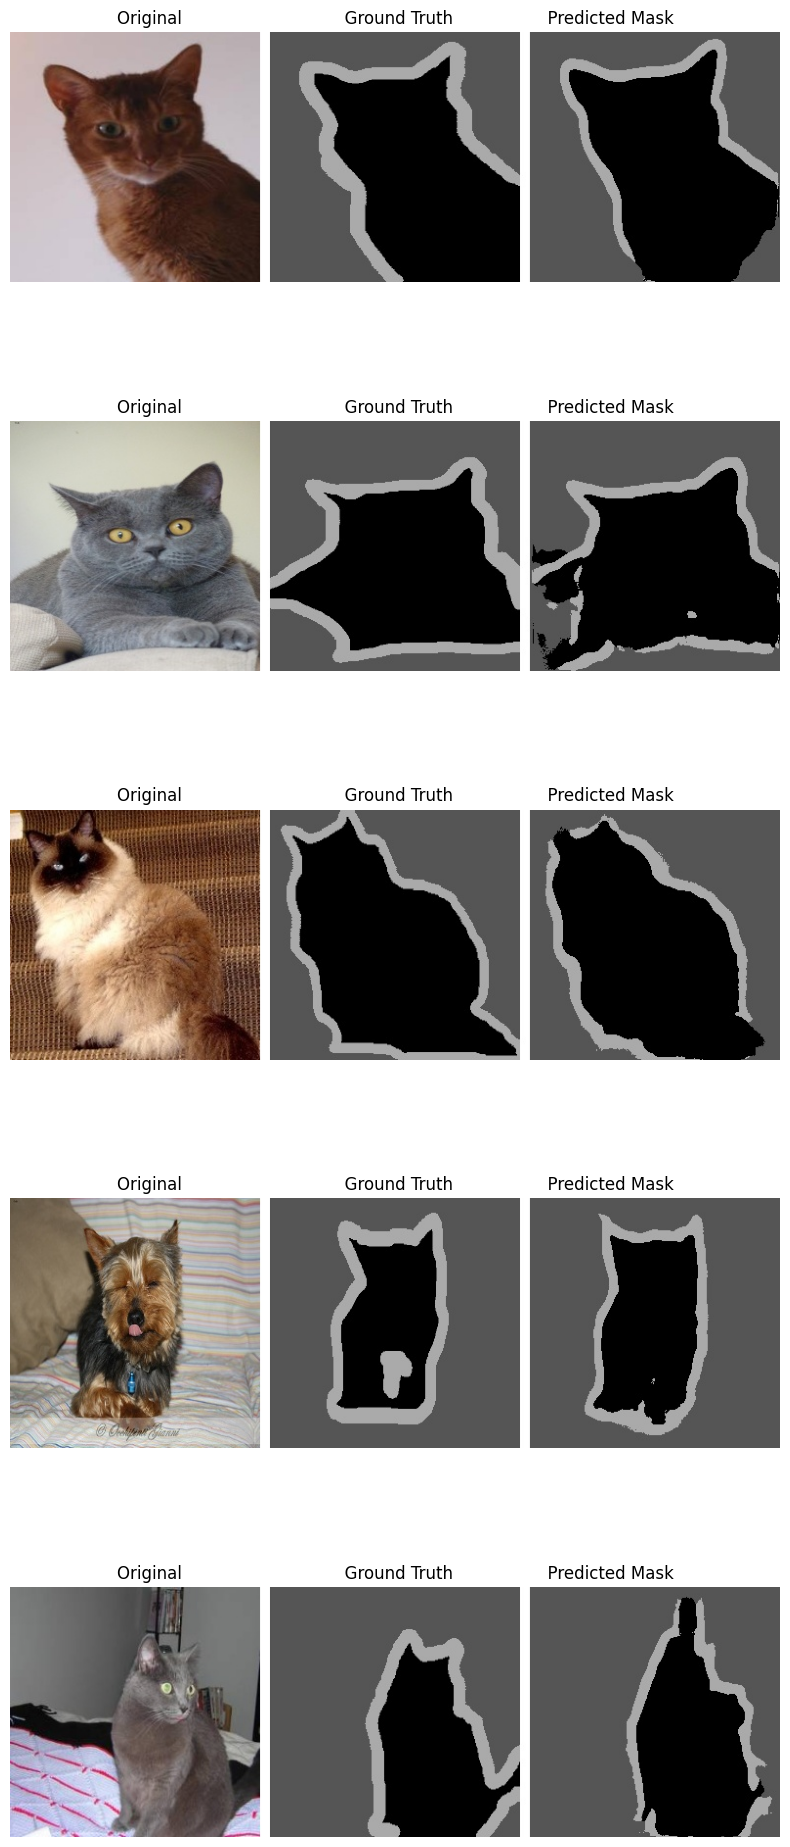

In [ ]:
def plot_images_vertically(image_paths, titles):
    # Create a figure with a grid of 5 rows and 1 column
    plt.figure(figsize=(8, 20))  # Adjust the figure size if necessary

    # Loop through each image and plot it
    for i, (image_path, title) in enumerate(zip(image_paths, titles)):
        plt.subplot(5, 1, i + 1)  # 5 rows, 1 column, index (i+1) for the current subplot
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')  # Hide the axis

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

# Example usage
image_paths = [
    "/content/drive/MyDrive/pet_seg/results/Abyssinian_210.jpg",
    "/content/drive/MyDrive/pet_seg/results/British_Shorthair_58.jpg",
    "/content/drive/MyDrive/pet_seg/results/Ragdoll_208.jpg",
    "/content/drive/MyDrive/pet_seg/results/yorkshire_terrier_64.jpg",
    "/content/drive/MyDrive/pet_seg/results/Russian_Blue_215.jpg"
]
titles = [
    "Original                               Ground Truth                  Predicted Mask",
    "Original                               Ground Truth                  Predicted Mask",
    "Original                               Ground Truth                  Predicted Mask",
    "Original                               Ground Truth                  Predicted Mask",
    "Original                               Ground Truth                  Predicted Mask"
]

plot_images_vertically(image_paths, titles)